<a href="https://colab.research.google.com/github/reagan13/gpt2-distilbert-thesis-files/blob/main/Hybrid_Concat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pip install libraries

Python library used for evaluating sequence labeling tasks, such as Named Entity Recognition (NER) and part-of-speech tagging.

In [ ]:
!pip install seqeval


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=fe5296795a6d164f3195e30416ebf74b6952533e92c1fc35b4212916e29ac46e
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


# Upload Dataset(Optional if using Google Colab)

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving final_dataset.json to final_dataset.json


# MOUNT DRIVE (Optional if You use colab)

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')
SAVE_PATH = "/content/drive/MyDrive/gpt2_hybrid_fusion_Concat_droupout_2"
os.makedirs(SAVE_PATH, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Libraries and Load dataset

This code imports necessary libraries for working with PyTorch, data visualization, evaluation metrics, and JSON handling. It defines a function load_dataset that loads and returns a dataset from a specified JSON file. The function reads the JSON file, parses its content, and outputs it as a list of dictionaries.

In [ ]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2TokenizerFast, DistilBertTokenizerFast, GPT2Model, DistilBertModel, AdamW, get_linear_schedule_with_warmup
from typing import Dict, List, Optional, Tuple
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from seqeval.metrics import precision_score as seq_precision, recall_score as seq_recall, f1_score as seq_f1
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast
import time
from google.colab import drive
from tabulate import tabulate



# Functions

## Detect and Mapping the labels

This code defines the detect_labels function, which processes a dataset to identify unique categories, intents, and named entity recognition (NER) labels. The function iterates through each sample in the dataset, extracting and adding unique values to sets for categories, intents, and NER labels. It also creates mappings (encoders) to assign an integer index to each unique category, intent, and NER label, which are then returned as a dictionary. The function prints out the encoders for categories, intents, and NER labels.

In [ ]:
# Updated detect_labels to use BIO scheme like HybridFusionMultiTask
def detect_labels(data: List[Dict]) -> Dict[str, Dict]:
    unique_categories = set()
    unique_intents = set()
    unique_ner_labels = set(["O"])  # "O" is the default label for tokens outside entities

    for sample in data:
        unique_categories.add(sample["category"])
        unique_intents.add(sample["intent"])
        ner_labels = sample["ner_labels_only"]  # Convert string to list of dicts
        ner_labels = json.loads(ner_labels) # Parse string to list of dictionaries
        for label in ner_labels:
            label_type = label["label"]
            unique_ner_labels.add(f"B-{label_type}")  # Add "B-" prefix for beginning of entity
            unique_ner_labels.add(f"I-{label_type}")  # Add "I-" prefix for inside of entity

    category_encoder = {cat: idx for idx, cat in enumerate(sorted(unique_categories))}
    intent_encoder = {intent: idx for idx, intent in enumerate(sorted(unique_intents))}
    ner_label_encoder = {ner: idx for idx, ner in enumerate(sorted(unique_ner_labels))}

    print("Category encoder:", category_encoder)
    print("Intent encoder:", intent_encoder)
    print("NER label encoder:", ner_label_encoder)

    return {
        "category_encoder": category_encoder,
        "intent_encoder": intent_encoder,
        "ner_label_encoder": ner_label_encoder
    }


## Tokenize the text

This code is a function that tokenizes input text using both GPT-2 and DistilBERT tokenizers. It processes the text by truncating or padding it to a maximum length, and returns tokenized outputs in the form of input_ids and attention_mask for each model. These tokenized inputs are then ready to be fed into the model for multitask learning.

In [ ]:
def tokenize_text(text: str, gpt2_tokenizer, distilbert_tokenizer, max_length: int = 128) -> Tuple[dict, dict]:
    gpt2_inputs = gpt2_tokenizer(
        text,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    distilbert_inputs = distilbert_tokenizer(
        text,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    return {
        "gpt2_input_ids": gpt2_inputs["input_ids"].squeeze(0),
        "gpt2_attention_mask": gpt2_inputs["attention_mask"].squeeze(0)
    }, {
        "distilbert_input_ids": distilbert_inputs["input_ids"].squeeze(0),
        "distilbert_attention_mask": distilbert_inputs["attention_mask"].squeeze(0)
    }

## Aligning Ner Labels

The align_ner_labels function aligns Named Entity Recognition (NER) labels with tokenized input from DistilBERT and GPT2. It tokenizes the text, maps each token to its character offset, and then assigns appropriate NER labels based on the positions of entities in the text. It ensures that the labels are correctly aligned with the tokens, using the BIO (Begin, Inside, Outside) scheme. The function returns a list of integers representing the aligned NER labels, which can then be used for training or evaluation.

In [ ]:
def align_ner_labels(text: str, ner_labels: List[Dict], tokenizer, ner_label_encoder: Dict, max_length: int = 128) -> List[int]:
    encoding = tokenizer(
        text,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_offsets_mapping=True,
        return_tensors="pt"
    )
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])
    token_to_char_map = encoding["offset_mapping"][0].tolist()

    ner_aligned = [ner_label_encoder["O"]] * len(tokens)

    for label in ner_labels:
        label_text = label["text"]
        label_type = label["label"]
        label_start = text.find(label_text)
        label_end = label_start + len(label_text)

        for i, (start, end) in enumerate(token_to_char_map):
            if start == 0 and end == 0:
                continue
            if start >= label_start and end <= label_end:
                prefix = "B-" if ner_aligned[i] == ner_label_encoder["O"] else "I-"
                ner_aligned[i] = ner_label_encoder[f"{prefix}{label_type}"]

    ner_aligned = ner_aligned[:max_length]
    return ner_aligned

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Split Dataset

In [ ]:
def split_dataset(data: List[Dict], train_ratio=0.8, val_ratio=0.1):
    train_data, temp_data = train_test_split(data, train_size=train_ratio, random_state=42)
    val_data, test_data = train_test_split(temp_data, train_size=val_ratio / (1 - train_ratio), random_state=42)
    return train_data, val_data, test_data

# Class and Data Loaders

## Create Custom Dataset

The MultiTaskDataset class is a custom dataset for multitask learning, designed to handle text data for Intent Classification, Category Classification, and Named Entity Recognition (NER). It tokenizes the input text using both GPT-2 and DistilBERT tokenizers, aligns the NER labels with the tokenized text, and encodes the labels (category, intent, NER) using provided label encoders. The dataset returns tokenized inputs for both models and the associated labels as tensors for training in multitask settings.

In [ ]:
class MultiTaskDataset(Dataset):
    def __init__(self, data: List[Dict], gpt2_tokenizer, distilbert_tokenizer, label_encoders, max_length: int = 128):
        self.data = data
        self.gpt2_tokenizer = gpt2_tokenizer
        self.distilbert_tokenizer = distilbert_tokenizer
        self.label_encoders = label_encoders
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        text = sample["instruction"]
        category = self.label_encoders["category_encoder"][sample["category"]]
        intent = self.label_encoders["intent_encoder"][sample["intent"]]
        ner_labels_str = sample["ner_labels_only"]
        ner_labels = ast.literal_eval(ner_labels_str) if ner_labels_str != "[]" else []

        gpt2_inputs, distilbert_inputs = tokenize_text(text, self.gpt2_tokenizer, self.distilbert_tokenizer, self.max_length)
        ner_labels_aligned = align_ner_labels(
            text, ner_labels, self.distilbert_tokenizer, self.label_encoders["ner_label_encoder"], self.max_length
        )

        return {
            "gpt2_input_ids": gpt2_inputs["gpt2_input_ids"],
            "gpt2_attention_mask": gpt2_inputs["gpt2_attention_mask"],
            "distilbert_input_ids": distilbert_inputs["distilbert_input_ids"],
            "distilbert_attention_mask": distilbert_inputs["distilbert_attention_mask"],
            "category_labels": category,
            "intent_labels": intent,
            "ner_labels": torch.tensor(ner_labels_aligned)
        }

## DataLoaders

The get_dataloaders function creates DataLoader objects for the training, validation, and test datasets. It initializes MultiTaskDataset for each dataset and then creates corresponding DataLoader instances with specified batch sizes and the number of workers for parallel data loading. These DataLoaders are used to efficiently load data in batches during model training and evaluation.

In [ ]:
def get_dataloaders(train_data, val_data, test_data, gpt2_tokenizer, distilbert_tokenizer, label_encoders, batch_size=16, num_workers=0):
    train_dataset = MultiTaskDataset(train_data, gpt2_tokenizer, distilbert_tokenizer, label_encoders)
    val_dataset = MultiTaskDataset(val_data, gpt2_tokenizer, distilbert_tokenizer, label_encoders)
    test_dataset = MultiTaskDataset(test_data, gpt2_tokenizer, distilbert_tokenizer, label_encoders)
    return (
        DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
        DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers),
        DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    )

# Hybrid Model Architecture

This code defines a multi-task learning model for text classification, leveraging both GPT-2 and DistilBERT base models. It uses a fusion module to combine features from both models with cross-attention and a fusion gate. The model performs three tasks: intent classification, category classification, and named entity recognition (NER). It includes separate fusion and attention mechanisms for each task, followed by classification heads to generate predictions. The model also supports loss computation if labels for all tasks are provided, enabling joint training across multiple tasks. In the code, the parameters of the base models (GPT-2 and DistilBERT) are frozen to prevent their weights from being updated during training. This is done by setting requires_grad = False for all parameters of both models, ensuring that only the task-specific components, such as the FusionModule, attention layers, and classification heads, are trained.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2Model, DistilBertModel
from typing import Optional, Dict

class ConcatFusionMultiTask(nn.Module):
    def __init__(self, num_intents: int, num_categories: int, num_ner_labels: int,
                 fusion_dim: int = 768, dropout_rate: float = 0.2):
        super().__init__()
        # Load pre-trained models
        self.gpt2 = GPT2Model.from_pretrained('gpt2')
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Freeze base models
        for param in self.gpt2.parameters():
            param.requires_grad = False
        for param in self.distilbert.parameters():
            param.requires_grad = False

        gpt2_dim = self.gpt2.config.n_embd  # 768
        bert_dim = self.distilbert.config.hidden_size  # 768

        # Fusion via concatenation and refinement
        self.fusion_mlp = nn.Sequential(
            nn.Linear(gpt2_dim + bert_dim, fusion_dim),
            nn.GELU(),
            nn.LayerNorm(fusion_dim),
            nn.Dropout(dropout_rate)
        )

        # Task-specific heads
        self.intent_head = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(fusion_dim // 2, num_intents)
        )
        self.category_head = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(fusion_dim // 2, num_categories)
        )
        self.ner_head = nn.Linear(fusion_dim, num_ner_labels)

    def forward(self, gpt2_input_ids: torch.Tensor, gpt2_attention_mask: torch.Tensor,
                distilbert_input_ids: torch.Tensor, distilbert_attention_mask: torch.Tensor,
                intent_labels: Optional[torch.Tensor] = None,
                category_labels: Optional[torch.Tensor] = None,
                ner_labels: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        # Get base model outputs
        gpt2_outputs = self.gpt2(input_ids=gpt2_input_ids, attention_mask=gpt2_attention_mask)
        distilbert_outputs = self.distilbert(input_ids=distilbert_input_ids, attention_mask=distilbert_attention_mask)

        gpt2_features = gpt2_outputs.last_hidden_state  # [batch, seq_len, gpt2_dim]
        bert_features = distilbert_outputs.last_hidden_state  # [batch, seq_len, bert_dim]

        # Concatenate features
        fused_input = torch.cat([gpt2_features, bert_features], dim=-1)  # [batch, seq_len, gpt2_dim + bert_dim]

        # Refine concatenated features
        fused_features = self.fusion_mlp(fused_input)  # [batch, seq_len, fusion_dim]

        # Pooling for intent and category (mean over sequence)
        pooled_features = (fused_features * gpt2_attention_mask.unsqueeze(-1)).sum(dim=1) / gpt2_attention_mask.sum(dim=1, keepdim=True)

        # Task-specific outputs
        intent_logits = self.intent_head(pooled_features)  # [batch, num_intents]
        category_logits = self.category_head(pooled_features)  # [batch, num_categories]
        ner_logits = self.ner_head(fused_features)  # [batch, seq_len, num_ner_labels]

        # Compute loss if labels are provided
        loss = None
        if all(label is not None for label in [intent_labels, category_labels, ner_labels]):
            intent_loss = F.cross_entropy(intent_logits, intent_labels)
            category_loss = F.cross_entropy(category_logits, category_labels)
            active_loss = distilbert_attention_mask.view(-1) == 1
            active_logits = ner_logits.view(-1, ner_logits.size(-1))[active_loss]
            active_labels = ner_labels.view(-1)[active_loss]
            ner_loss = F.cross_entropy(active_logits, active_labels)
            loss = intent_loss + category_loss + ner_loss

        return {
            'intent_logits': intent_logits,
            'category_logits': category_logits,
            'ner_logits': ner_logits,
            'loss': loss
        }

## Training Model

The train_model_with_mixed_precision function trains a multitask model using mixed-precision training for improved performance and memory efficiency. It tracks multiple metrics, including training loss, validation loss, intent accuracy, category accuracy, and NER F1 score. The function leverages gradient accumulation for efficient updates and autocast for automatic mixed precision during forward and backward passes. It computes and reports the metrics for both training and validation phases, and filters out "O" labels in NER for accurate F1 score calculation. The model is trained for a specified number of epochs on a GPU device.

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, label_encoders, num_epochs=5, device="cuda", accumulation_steps=4):
    model.to(device)
    ner_label_decoder = {v: k for k, v in label_encoders["ner_label_encoder"].items()}
    metrics = {
        "train_losses": [], "val_losses": [], "train_intent_acc": [], "train_category_f1": [], "train_ner_micro_f1": [],
        "val_intent_acc": [], "val_category_f1": [], "val_ner_macro_f1": [], "epoch_times": []
    }

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f"\nEpoch {epoch + 1}/{num_epochs} (Device: {device})")
        print("-" * 50)

        # Training
        model.train()
        train_loss = 0.0
        train_intent_preds, train_intent_labels = [], []
        train_category_preds, train_category_labels = [], []
        train_ner_preds, train_ner_labels = [], []
        optimizer.zero_grad()

        for i, batch in enumerate(tqdm(train_loader, desc="Training")):
            batch_start = time.time()
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                gpt2_input_ids=inputs["gpt2_input_ids"],
                gpt2_attention_mask=inputs["gpt2_attention_mask"],
                distilbert_input_ids=inputs["distilbert_input_ids"],
                distilbert_attention_mask=inputs["distilbert_attention_mask"],
                intent_labels=inputs["intent_labels"],
                category_labels=inputs["category_labels"],
                ner_labels=inputs["ner_labels"]
            )
            loss = outputs["loss"] / accumulation_steps
            loss.backward()
            train_loss += loss.item()

            train_intent_preds.extend(outputs["intent_logits"].argmax(dim=-1).cpu().numpy())
            train_intent_labels.extend(inputs["intent_labels"].cpu().numpy())
            train_category_preds.extend(outputs["category_logits"].argmax(dim=-1).cpu().numpy())
            train_category_labels.extend(inputs["category_labels"].cpu().numpy())
            train_ner_preds.extend(outputs["ner_logits"].argmax(dim=-1).cpu().numpy())
            train_ner_labels.extend(inputs["ner_labels"].cpu().numpy())

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
            print(f"Batch {i + 1} Latency: {time.time() - batch_start:.4f}s", end='\r')

        avg_train_loss = train_loss / len(train_loader)
        train_intent_acc = accuracy_score(train_intent_labels, train_intent_preds)
        train_category_f1 = f1_score(train_category_labels, train_category_preds, average='weighted')
        train_ner_true = [[ner_label_decoder[l] for l in seq] for seq in train_ner_labels]
        train_ner_pred = [[ner_label_decoder[p] for p in seq] for seq in train_ner_preds]
        train_ner_micro_f1 = seq_f1(train_ner_true, train_ner_pred, average='micro')

        # Validation
        model.eval()
        val_loss = 0.0
        val_intent_preds, val_intent_labels = [], []
        val_category_preds, val_category_labels = [], []
        val_ner_preds, val_ner_labels = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                inputs = {k: v.to(device) for k, v in batch.items()}
                outputs = model(
                    gpt2_input_ids=inputs["gpt2_input_ids"],
                    gpt2_attention_mask=inputs["gpt2_attention_mask"],
                    distilbert_input_ids=inputs["distilbert_input_ids"],
                    distilbert_attention_mask=inputs["distilbert_attention_mask"],
                    intent_labels=inputs["intent_labels"],
                    category_labels=inputs["category_labels"],
                    ner_labels=inputs["ner_labels"]
                )
                val_loss += outputs["loss"].item()
                val_intent_preds.extend(outputs["intent_logits"].argmax(dim=-1).cpu().numpy())
                val_intent_labels.extend(inputs["intent_labels"].cpu().numpy())
                val_category_preds.extend(outputs["category_logits"].argmax(dim=-1).cpu().numpy())
                val_category_labels.extend(inputs["category_labels"].cpu().numpy())
                val_ner_preds.extend(outputs["ner_logits"].argmax(dim=-1).cpu().numpy())
                val_ner_labels.extend(inputs["ner_labels"].cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_intent_acc = accuracy_score(val_intent_labels, val_intent_preds)
        val_category_f1 = f1_score(val_category_labels, val_category_preds, average='weighted')
        val_ner_true = [[ner_label_decoder[l] for l in seq] for seq in val_ner_labels]
        val_ner_pred = [[ner_label_decoder[p] for p in seq] for seq in val_ner_preds]
        val_ner_macro_f1 = seq_f1(val_ner_true, val_ner_pred, average='macro')

        epoch_time = time.time() - start_time
        metrics["train_losses"].append(avg_train_loss)
        metrics["val_losses"].append(avg_val_loss)
        metrics["train_intent_acc"].append(train_intent_acc)
        metrics["train_category_f1"].append(train_category_f1)
        metrics["train_ner_micro_f1"].append(train_ner_micro_f1)
        metrics["val_intent_acc"].append(val_intent_acc)
        metrics["val_category_f1"].append(val_category_f1)
        metrics["val_ner_macro_f1"].append(val_ner_macro_f1)
        metrics["epoch_times"].append(epoch_time)

        fit_status = "Good"
        if epoch > 0:
            if avg_train_loss < metrics["train_losses"][-2] and avg_val_loss > metrics["val_losses"][-2]:
                fit_status = "Overfitting"
            elif avg_train_loss > 0.5 and avg_val_loss > 0.5:
                fit_status = "Underfitting"

        print(f"Training Loss: {avg_train_loss:.4f} | Intent Acc: {train_intent_acc:.4f} | Category Weighted F1: {train_category_f1:.4f} | NER Micro F1: {train_ner_micro_f1:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f} | Intent Acc: {val_intent_acc:.4f} | Category Weighted F1: {val_category_f1:.4f} | NER Macro F1: {val_ner_macro_f1:.4f}")
        print(f"Epoch Time: {epoch_time:.2f}s | Fit Status: {fit_status}")

    return metrics

## Creating Optimizer and Scheduler

The setup_optimizer_and_scheduler function sets up the AdamW optimizer and a learning rate scheduler for training a hybrid multi-task model. It takes the model, training DataLoader, learning rate, number of epochs, and warmup steps as inputs. The optimizer is initialized with the model's parameters, and the scheduler is configured to adjust the learning rate over the course of training, with a warmup phase if specified. The function returns both the optimizer and the scheduler for training.

In [ ]:
def setup_optimizer_and_scheduler(model, train_loader, lr=2e-5, num_epochs=5, warmup_steps=0):
    optimizer = AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    return optimizer, scheduler

## Save Training Model History and results

This function saves the training metrics and evaluation results, including confusion matrices for intent and category, into a JSON file. It filters out unnecessary data (like predictions and labels) and stores the relevant information in a structured format. The file is saved to the specified save_path with the name "training_history.json".

In [ ]:
def save_training_artifacts(model, gpt2_tokenizer, distilbert_tokenizer, label_encoders, metrics, test_results, save_path):
    torch.save(model.state_dict(), os.path.join(save_path, "model.pth"))
    gpt2_tokenizer.save_pretrained(os.path.join(save_path, "gpt2_tokenizer"))
    distilbert_tokenizer.save_pretrained(os.path.join(save_path, "distilbert_tokenizer"))
    with open(os.path.join(save_path, "label_encoders.json"), "w", encoding="utf-8") as f:
        json.dump(label_encoders, f, ensure_ascii=False, indent=4)
    with open(os.path.join(save_path, "training_metrics.json"), "w", encoding="utf-8") as f:
        json.dump(metrics, f, ensure_ascii=False, indent=4)
    with open(os.path.join(save_path, "test_results.json"), "w", encoding="utf-8") as f:
        json.dump(test_results, f, ensure_ascii=False, indent=4)
    print(f"Artifacts saved to {save_path}")

# Initialize

## Define Hyperparameters

In [ ]:
lr = 2e-5 #learning rate
batch_size = 16
num_epochs = 5
warmup_steps = 0
num_workers = 0
accumulation_steps = 4
device = "cuda" if torch.cuda.is_available() else "cpu"
# dropout_rate: float = 0.2
#datasplit ratio = 80% traing data, 10% val data, 10% test data

## Tokenizer Set Up

In [ ]:
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
if gpt2_tokenizer.pad_token is None:
    gpt2_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

## Data Splitting and Detect Labels Set Up

In [ ]:
# train_data, val_data, test_data = get_dataset_splits("final_dataset_temp.json", SAVE_PATH)
# Load the three separate JSON datasets
with open("train.json", "r") as f:
    train_data = json.load(f)

with open("val.json", "r") as f:
    val_data = json.load(f)

with open("test.json", "r") as f:
    test_data = json.load(f)

label_encoders = detect_labels(train_data + val_data + test_data)


## Data Loader and Model Set Up

In [ ]:
model = ConcatFusionMultiTask(
    num_intents=len(label_encoders["intent_encoder"]),
    num_categories=len(label_encoders["category_encoder"]),
    num_ner_labels=len(label_encoders["ner_label_encoder"])
)
if gpt2_tokenizer.pad_token_id is not None:
    model.gpt2.resize_token_embeddings(len(gpt2_tokenizer))

train_loader, val_loader, test_loader = get_dataloaders(
    train_data, val_data, test_data,
    gpt2_tokenizer, distilbert_tokenizer, label_encoders,
    batch_size=batch_size, num_workers=num_workers
)

# Training

The code snippet executes the training and loads the dataset and tokenizes it using GPT-2 and DistilBERT, and splits the data into training, validation, and test sets. A hybrid multi-task model is created and trained using mixed precision. The model is then evaluated for intent classification, category classification, and named entity recognition (NER). The results are printed and saved to Google Drive, including the model's state, tokenizers, label encoders, metrics plots, and training history.

In [ ]:
optimizer, scheduler = setup_optimizer_and_scheduler(model, train_loader, lr=lr, num_epochs=num_epochs)

metrics = train_model(model, train_loader, val_loader, optimizer, scheduler, label_encoders, num_epochs=num_epochs, device=device, accumulation_steps=accumulation_steps)




Splitting dataset and saving...
Saved train split to /content/drive/MyDrive/gpt2_hybrid_fusion_approach3_droupout_2/train.json
Saved val split to /content/drive/MyDrive/gpt2_hybrid_fusion_approach3_droupout_2/val.json
Saved test split to /content/drive/MyDrive/gpt2_hybrid_fusion_approach3_droupout_2/test.json
Category encoder: {'account': 0, 'cancel': 1, 'contact': 2, 'delivery': 3, 'feedback': 4, 'invoice': 5, 'order': 6, 'payment': 7, 'refund': 8, 'shipping': 9, 'subscription': 10}
Intent encoder: {'cancel_order': 0, 'change_order': 1, 'change_shipping_address': 2, 'check_cancellation_fee': 3, 'check_invoice': 4, 'check_payment_methods': 5, 'check_refund_policy': 6, 'complaint': 7, 'contact_customer_service': 8, 'contact_human_agent': 9, 'create_account': 10, 'delete_account': 11, 'delivery_options': 12, 'delivery_period': 13, 'edit_account': 14, 'get_invoice': 15, 'get_refund': 16, 'newsletter_subscription': 17, 'payment_issue': 18, 'place_order': 19, 'recover_password': 20, 'regist

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/5 (Device: cuda)
--------------------------------------------------


Training:   0%|          | 2/1344 [00:01<14:54,  1.50it/s]

Training:   0%|          | 3/1344 [00:01<09:53,  2.26it/s]

Training:   0%|          | 5/1344 [00:02<06:26,  3.47it/s]

Training:   1%|          | 7/1344 [00:02<05:03,  4.41it/s]

Training:   1%|          | 9/1344 [00:02<04:25,  5.04it/s]

Training:   1%|          | 11/1344 [00:03<04:11,  5.31it/s]

Training:   1%|          | 13/1344 [00:03<04:10,  5.31it/s]

Training:   1%|          | 15/1344 [00:03<04:09,  5.32it/s]

Training:   1%|▏         | 17/1344 [00:04<04:09,  5.32it/s]

Training:   1%|▏         | 19/1344 [00:04<04:05,  5.40it/s]

Training:   2%|▏         | 21/1344 [00:05<04:07,  5.35it/s]

Training:   2%|▏         | 23/1344 [00:05<04:06,  5.35it/s]

Training:   2%|▏         | 25/1344 [00:05<04:09,  5.29it/s]

Training:   2%|▏         | 27/1344 [00:06<04:11,  5.24it/s]

Training:   2%|▏         | 29/1344 [00:06<04:02,  5.42it/s]

Training:   2%|▏         | 31/1344 [00:06<03:56,  5.55it/s]

Training:   2%|▏         | 33/1344 [00:07<03:55,  5.56it/s]

Training:   3%|▎         | 35/1344 [00:07<03:52,  5.64it/s]

Training:   3%|▎         | 37/1344 [00:07<03:55,  5.55it/s]

Training:   3%|▎         | 39/1344 [00:08<03:52,  5.62it/s]

Training:   3%|▎         | 41/1344 [00:08<03:50,  5.66it/s]

Training:   3%|▎         | 43/1344 [00:09<03:49,  5.68it/s]

Training:   3%|▎         | 45/1344 [00:09<03:48,  5.68it/s]

Training:   3%|▎         | 47/1344 [00:09<03:48,  5.67it/s]

Training:   4%|▎         | 49/1344 [00:10<03:48,  5.67it/s]

Training:   4%|▍         | 51/1344 [00:10<03:50,  5.60it/s]

Training:   4%|▍         | 53/1344 [00:10<03:48,  5.64it/s]

Training:   4%|▍         | 55/1344 [00:11<03:48,  5.65it/s]

Training:   4%|▍         | 57/1344 [00:11<03:46,  5.68it/s]

Training:   4%|▍         | 59/1344 [00:11<03:46,  5.67it/s]

Training:   5%|▍         | 61/1344 [00:12<03:45,  5.69it/s]

Training:   5%|▍         | 63/1344 [00:12<03:45,  5.68it/s]

Training:   5%|▍         | 65/1344 [00:12<03:44,  5.69it/s]

Training:   5%|▍         | 67/1344 [00:13<03:44,  5.69it/s]

Training:   5%|▌         | 69/1344 [00:13<03:46,  5.62it/s]

Training:   5%|▌         | 71/1344 [00:13<03:49,  5.56it/s]

Training:   5%|▌         | 73/1344 [00:14<03:46,  5.61it/s]

Training:   6%|▌         | 75/1344 [00:14<03:45,  5.63it/s]

Training:   6%|▌         | 77/1344 [00:15<03:44,  5.65it/s]

Training:   6%|▌         | 79/1344 [00:15<03:44,  5.64it/s]

Training:   6%|▌         | 81/1344 [00:15<03:44,  5.62it/s]

Training:   6%|▌         | 83/1344 [00:16<03:43,  5.64it/s]

Training:   6%|▋         | 85/1344 [00:16<03:50,  5.47it/s]

Training:   6%|▋         | 87/1344 [00:16<03:54,  5.37it/s]

Training:   7%|▋         | 89/1344 [00:17<03:57,  5.29it/s]

Training:   7%|▋         | 91/1344 [00:17<03:56,  5.30it/s]

Training:   7%|▋         | 93/1344 [00:18<04:00,  5.21it/s]

Training:   7%|▋         | 95/1344 [00:18<03:58,  5.23it/s]

Training:   7%|▋         | 97/1344 [00:18<04:01,  5.16it/s]

Training:   7%|▋         | 99/1344 [00:19<03:59,  5.19it/s]

Training:   8%|▊         | 101/1344 [00:19<03:53,  5.32it/s]

Training:   8%|▊         | 103/1344 [00:19<03:46,  5.48it/s]

Training:   8%|▊         | 105/1344 [00:20<03:43,  5.54it/s]

Training:   8%|▊         | 107/1344 [00:20<03:40,  5.60it/s]

Training:   8%|▊         | 109/1344 [00:20<03:42,  5.55it/s]

Training:   8%|▊         | 111/1344 [00:21<03:39,  5.61it/s]

Training:   8%|▊         | 113/1344 [00:21<03:38,  5.63it/s]

Training:   9%|▊         | 115/1344 [00:22<03:39,  5.61it/s]

Training:   9%|▊         | 117/1344 [00:22<03:38,  5.61it/s]

Training:   9%|▉         | 119/1344 [00:22<03:37,  5.63it/s]

Training:   9%|▉         | 121/1344 [00:23<03:37,  5.62it/s]

Training:   9%|▉         | 123/1344 [00:23<03:36,  5.64it/s]

Training:   9%|▉         | 125/1344 [00:23<03:36,  5.63it/s]

Training:   9%|▉         | 127/1344 [00:24<03:35,  5.66it/s]

Training:  10%|▉         | 129/1344 [00:24<03:35,  5.64it/s]

Training:  10%|▉         | 131/1344 [00:24<03:34,  5.65it/s]

Training:  10%|▉         | 133/1344 [00:25<03:35,  5.62it/s]

Training:  10%|█         | 135/1344 [00:25<03:37,  5.56it/s]

Training:  10%|█         | 137/1344 [00:25<03:37,  5.55it/s]

Training:  10%|█         | 139/1344 [00:26<03:35,  5.58it/s]

Training:  10%|█         | 141/1344 [00:26<03:33,  5.63it/s]

Training:  11%|█         | 143/1344 [00:27<03:33,  5.63it/s]

Training:  11%|█         | 145/1344 [00:27<03:35,  5.57it/s]

Training:  11%|█         | 147/1344 [00:27<03:33,  5.61it/s]

Training:  11%|█         | 149/1344 [00:28<03:33,  5.59it/s]

Training:  11%|█         | 151/1344 [00:28<03:32,  5.60it/s]

Training:  11%|█▏        | 153/1344 [00:28<03:32,  5.60it/s]

Training:  12%|█▏        | 155/1344 [00:29<03:35,  5.53it/s]

Training:  12%|█▏        | 157/1344 [00:29<03:39,  5.41it/s]

Training:  12%|█▏        | 159/1344 [00:29<03:42,  5.34it/s]

Training:  12%|█▏        | 161/1344 [00:30<03:42,  5.31it/s]

Training:  12%|█▏        | 163/1344 [00:30<03:44,  5.27it/s]

Training:  12%|█▏        | 165/1344 [00:31<03:46,  5.20it/s]

Training:  12%|█▏        | 167/1344 [00:31<03:44,  5.24it/s]

Training:  13%|█▎        | 169/1344 [00:31<03:47,  5.16it/s]

Training:  13%|█▎        | 171/1344 [00:32<03:48,  5.14it/s]

Training:  13%|█▎        | 173/1344 [00:32<03:42,  5.26it/s]

Training:  13%|█▎        | 175/1344 [00:32<03:37,  5.38it/s]

Training:  13%|█▎        | 177/1344 [00:33<03:32,  5.49it/s]

Training:  13%|█▎        | 179/1344 [00:33<03:30,  5.55it/s]

Training:  13%|█▎        | 181/1344 [00:34<03:28,  5.57it/s]

Training:  14%|█▎        | 183/1344 [00:34<03:27,  5.60it/s]

Training:  14%|█▍        | 185/1344 [00:34<03:26,  5.60it/s]

Training:  14%|█▍        | 187/1344 [00:35<03:26,  5.61it/s]

Training:  14%|█▍        | 189/1344 [00:35<03:25,  5.63it/s]

Training:  14%|█▍        | 191/1344 [00:35<03:26,  5.59it/s]

Training:  14%|█▍        | 193/1344 [00:36<03:25,  5.61it/s]

Training:  15%|█▍        | 195/1344 [00:36<03:25,  5.60it/s]

Training:  15%|█▍        | 197/1344 [00:36<03:24,  5.62it/s]

Training:  15%|█▍        | 199/1344 [00:37<03:25,  5.57it/s]

Training:  15%|█▍        | 201/1344 [00:37<03:25,  5.55it/s]

Training:  15%|█▌        | 202/1344 [00:37<03:39,  5.20it/s]

Training:  15%|█▌        | 204/1344 [00:38<03:41,  5.14it/s]

Training:  15%|█▌        | 206/1344 [00:38<03:35,  5.27it/s]

Training:  15%|█▌        | 207/1344 [00:38<03:53,  4.87it/s]

Training:  16%|█▌        | 209/1344 [00:39<03:45,  5.04it/s]

Training:  16%|█▌        | 211/1344 [00:39<03:38,  5.18it/s]

Training:  16%|█▌        | 213/1344 [00:40<03:51,  4.89it/s]

Training:  16%|█▌        | 215/1344 [00:40<03:36,  5.23it/s]

Training:  16%|█▌        | 217/1344 [00:40<03:29,  5.37it/s]

Training:  16%|█▋        | 219/1344 [00:41<03:26,  5.44it/s]

Training:  16%|█▋        | 221/1344 [00:41<03:23,  5.52it/s]

Training:  17%|█▋        | 223/1344 [00:41<03:22,  5.54it/s]

Training:  17%|█▋        | 225/1344 [00:42<03:22,  5.53it/s]

Training:  17%|█▋        | 227/1344 [00:42<03:27,  5.39it/s]

Training:  17%|█▋        | 229/1344 [00:43<03:29,  5.31it/s]

Training:  17%|█▋        | 231/1344 [00:43<03:31,  5.25it/s]

Training:  17%|█▋        | 233/1344 [00:43<03:33,  5.21it/s]

Training:  17%|█▋        | 235/1344 [00:44<03:35,  5.15it/s]

Training:  18%|█▊        | 237/1344 [00:44<03:35,  5.14it/s]

Training:  18%|█▊        | 239/1344 [00:44<03:35,  5.12it/s]

Training:  18%|█▊        | 241/1344 [00:45<03:33,  5.16it/s]

Training:  18%|█▊        | 243/1344 [00:45<03:26,  5.33it/s]

Training:  18%|█▊        | 245/1344 [00:46<03:23,  5.40it/s]

Training:  18%|█▊        | 247/1344 [00:46<03:20,  5.46it/s]

Training:  19%|█▊        | 249/1344 [00:46<03:20,  5.46it/s]

Training:  19%|█▊        | 251/1344 [00:47<03:20,  5.46it/s]

Training:  19%|█▉        | 253/1344 [00:47<03:18,  5.49it/s]

Training:  19%|█▉        | 255/1344 [00:47<03:16,  5.53it/s]

Training:  19%|█▉        | 257/1344 [00:48<03:18,  5.48it/s]

Training:  19%|█▉        | 259/1344 [00:48<03:20,  5.42it/s]

Training:  19%|█▉        | 261/1344 [00:49<03:18,  5.46it/s]

Training:  20%|█▉        | 263/1344 [00:49<03:16,  5.51it/s]

Training:  20%|█▉        | 265/1344 [00:49<03:15,  5.53it/s]

Training:  20%|█▉        | 267/1344 [00:50<03:14,  5.53it/s]

Training:  20%|██        | 269/1344 [00:50<03:14,  5.53it/s]

Training:  20%|██        | 271/1344 [00:50<03:14,  5.52it/s]

Training:  20%|██        | 273/1344 [00:51<03:15,  5.49it/s]

Training:  20%|██        | 275/1344 [00:51<03:14,  5.48it/s]

Training:  21%|██        | 277/1344 [00:51<03:14,  5.50it/s]

Training:  21%|██        | 279/1344 [00:52<03:12,  5.53it/s]

Training:  21%|██        | 281/1344 [00:52<03:12,  5.52it/s]

Training:  21%|██        | 283/1344 [00:52<03:12,  5.51it/s]

Training:  21%|██        | 285/1344 [00:53<03:12,  5.51it/s]

Training:  21%|██▏       | 287/1344 [00:53<03:12,  5.50it/s]

Training:  22%|██▏       | 289/1344 [00:54<03:11,  5.50it/s]

Training:  22%|██▏       | 291/1344 [00:54<03:11,  5.51it/s]

Training:  22%|██▏       | 293/1344 [00:54<03:10,  5.51it/s]

Training:  22%|██▏       | 295/1344 [00:55<03:11,  5.47it/s]

Training:  22%|██▏       | 297/1344 [00:55<03:15,  5.35it/s]

Training:  22%|██▏       | 299/1344 [00:55<03:20,  5.21it/s]

Training:  22%|██▏       | 301/1344 [00:56<03:21,  5.17it/s]

Training:  23%|██▎       | 303/1344 [00:56<03:21,  5.17it/s]

Training:  23%|██▎       | 305/1344 [00:57<03:22,  5.12it/s]

Training:  23%|██▎       | 307/1344 [00:57<03:21,  5.16it/s]

Training:  23%|██▎       | 309/1344 [00:57<03:23,  5.08it/s]

Training:  23%|██▎       | 311/1344 [00:58<03:23,  5.07it/s]

Training:  23%|██▎       | 313/1344 [00:58<03:14,  5.30it/s]

Training:  23%|██▎       | 315/1344 [00:59<03:13,  5.32it/s]

Training:  24%|██▎       | 317/1344 [00:59<03:09,  5.41it/s]

Training:  24%|██▎       | 319/1344 [00:59<03:08,  5.45it/s]

Training:  24%|██▍       | 321/1344 [01:00<03:08,  5.41it/s]

Training:  24%|██▍       | 323/1344 [01:00<03:08,  5.42it/s]

Training:  24%|██▍       | 325/1344 [01:00<03:07,  5.43it/s]

Training:  24%|██▍       | 327/1344 [01:01<03:06,  5.45it/s]

Training:  24%|██▍       | 329/1344 [01:01<03:06,  5.43it/s]

Training:  25%|██▍       | 331/1344 [01:02<03:07,  5.41it/s]

Training:  25%|██▍       | 333/1344 [01:02<03:06,  5.43it/s]

Training:  25%|██▍       | 335/1344 [01:02<03:05,  5.45it/s]

Training:  25%|██▌       | 337/1344 [01:03<03:04,  5.46it/s]

Training:  25%|██▌       | 339/1344 [01:03<03:03,  5.46it/s]

Training:  25%|██▌       | 341/1344 [01:03<03:03,  5.46it/s]

Training:  26%|██▌       | 343/1344 [01:04<03:03,  5.46it/s]

Training:  26%|██▌       | 345/1344 [01:04<03:03,  5.45it/s]

Training:  26%|██▌       | 347/1344 [01:04<03:02,  5.45it/s]

Training:  26%|██▌       | 349/1344 [01:05<03:03,  5.43it/s]

Training:  26%|██▌       | 351/1344 [01:05<03:02,  5.45it/s]

Training:  26%|██▋       | 353/1344 [01:06<03:02,  5.42it/s]

Training:  26%|██▋       | 355/1344 [01:06<03:02,  5.42it/s]

Training:  27%|██▋       | 357/1344 [01:06<03:02,  5.42it/s]

Training:  27%|██▋       | 359/1344 [01:07<03:03,  5.37it/s]

Training:  27%|██▋       | 361/1344 [01:07<03:03,  5.35it/s]

Training:  27%|██▋       | 363/1344 [01:07<03:02,  5.37it/s]

Training:  27%|██▋       | 365/1344 [01:08<03:02,  5.38it/s]

Training:  27%|██▋       | 367/1344 [01:08<03:05,  5.26it/s]

Training:  27%|██▋       | 369/1344 [01:09<03:09,  5.15it/s]

Training:  28%|██▊       | 371/1344 [01:09<03:11,  5.08it/s]

Training:  28%|██▊       | 373/1344 [01:09<03:10,  5.10it/s]

Training:  28%|██▊       | 375/1344 [01:10<03:10,  5.09it/s]

Training:  28%|██▊       | 377/1344 [01:10<03:09,  5.09it/s]

Training:  28%|██▊       | 379/1344 [01:11<03:08,  5.11it/s]

Training:  28%|██▊       | 380/1344 [01:11<03:11,  5.04it/s]

Training:  28%|██▊       | 382/1344 [01:11<03:06,  5.15it/s]

Training:  29%|██▊       | 384/1344 [01:11<03:03,  5.24it/s]

Training:  29%|██▊       | 386/1344 [01:12<03:03,  5.21it/s]

Training:  29%|██▉       | 388/1344 [01:12<02:59,  5.32it/s]

Training:  29%|██▉       | 390/1344 [01:13<02:57,  5.37it/s]

Training:  29%|██▉       | 392/1344 [01:13<02:58,  5.34it/s]

Training:  29%|██▉       | 394/1344 [01:13<02:56,  5.38it/s]

Training:  29%|██▉       | 396/1344 [01:14<02:56,  5.38it/s]

Training:  30%|██▉       | 398/1344 [01:14<02:58,  5.31it/s]

Training:  30%|██▉       | 400/1344 [01:14<02:58,  5.29it/s]

Training:  30%|██▉       | 402/1344 [01:15<02:57,  5.31it/s]

Training:  30%|███       | 404/1344 [01:15<02:56,  5.34it/s]

Training:  30%|███       | 406/1344 [01:16<02:56,  5.33it/s]

Training:  30%|███       | 408/1344 [01:16<02:55,  5.35it/s]

Training:  31%|███       | 410/1344 [01:16<02:54,  5.34it/s]

Training:  31%|███       | 412/1344 [01:17<02:55,  5.30it/s]

Training:  31%|███       | 414/1344 [01:17<02:53,  5.35it/s]

Training:  31%|███       | 416/1344 [01:17<02:54,  5.31it/s]

Training:  31%|███       | 418/1344 [01:18<02:53,  5.34it/s]

Training:  31%|███▏      | 420/1344 [01:18<02:53,  5.33it/s]

Training:  31%|███▏      | 422/1344 [01:19<02:52,  5.35it/s]

Training:  32%|███▏      | 424/1344 [01:19<02:52,  5.34it/s]

Training:  32%|███▏      | 426/1344 [01:19<02:51,  5.36it/s]

Training:  32%|███▏      | 428/1344 [01:20<02:51,  5.35it/s]

Training:  32%|███▏      | 430/1344 [01:20<02:50,  5.37it/s]

Training:  32%|███▏      | 432/1344 [01:20<02:52,  5.29it/s]

Training:  32%|███▏      | 434/1344 [01:21<02:50,  5.32it/s]

Training:  32%|███▏      | 435/1344 [01:21<02:51,  5.29it/s]

Training:  32%|███▏      | 436/1344 [01:21<02:55,  5.17it/s]

Training:  33%|███▎      | 439/1344 [01:22<02:55,  5.15it/s]

Training:  33%|███▎      | 441/1344 [01:22<02:55,  5.15it/s]

Training:  33%|███▎      | 443/1344 [01:23<02:57,  5.09it/s]

Training:  33%|███▎      | 445/1344 [01:23<02:56,  5.11it/s]

Training:  33%|███▎      | 447/1344 [01:23<02:57,  5.06it/s]

Training:  33%|███▎      | 449/1344 [01:24<02:57,  5.04it/s]

Training:  34%|███▎      | 451/1344 [01:24<02:56,  5.06it/s]

Training:  34%|███▎      | 453/1344 [01:25<02:51,  5.19it/s]

Training:  34%|███▍      | 455/1344 [01:25<02:49,  5.25it/s]

Training:  34%|███▍      | 457/1344 [01:25<02:48,  5.26it/s]

Training:  34%|███▍      | 459/1344 [01:26<02:46,  5.30it/s]

Training:  34%|███▍      | 461/1344 [01:26<02:47,  5.28it/s]

Training:  34%|███▍      | 463/1344 [01:26<02:47,  5.27it/s]

Training:  35%|███▍      | 465/1344 [01:27<02:46,  5.27it/s]

Training:  35%|███▍      | 467/1344 [01:27<02:45,  5.29it/s]

Training:  35%|███▍      | 469/1344 [01:28<02:45,  5.29it/s]

Training:  35%|███▌      | 471/1344 [01:28<02:45,  5.28it/s]

Training:  35%|███▌      | 473/1344 [01:28<02:44,  5.29it/s]

Training:  35%|███▌      | 475/1344 [01:29<02:43,  5.31it/s]

Training:  35%|███▌      | 477/1344 [01:29<02:43,  5.29it/s]

Training:  36%|███▌      | 479/1344 [01:30<02:44,  5.26it/s]

Training:  36%|███▌      | 481/1344 [01:30<02:43,  5.28it/s]

Training:  36%|███▌      | 483/1344 [01:30<02:43,  5.28it/s]

Training:  36%|███▌      | 485/1344 [01:31<02:42,  5.28it/s]

Training:  36%|███▌      | 487/1344 [01:31<02:42,  5.29it/s]

Training:  36%|███▋      | 489/1344 [01:31<02:42,  5.26it/s]

Training:  37%|███▋      | 491/1344 [01:32<02:41,  5.27it/s]

Training:  37%|███▋      | 493/1344 [01:32<02:41,  5.28it/s]

Training:  37%|███▋      | 495/1344 [01:33<02:40,  5.29it/s]

Training:  37%|███▋      | 497/1344 [01:33<02:40,  5.28it/s]

Training:  37%|███▋      | 499/1344 [01:33<02:40,  5.27it/s]

Training:  37%|███▋      | 501/1344 [01:34<02:41,  5.22it/s]

Training:  37%|███▋      | 503/1344 [01:34<02:39,  5.26it/s]

Training:  38%|███▊      | 504/1344 [01:34<02:43,  5.15it/s]

Training:  38%|███▊      | 506/1344 [01:35<02:46,  5.03it/s]

Training:  38%|███▊      | 507/1344 [01:35<02:48,  4.98it/s]

Training:  38%|███▊      | 510/1344 [01:35<02:46,  5.02it/s]

Training:  38%|███▊      | 512/1344 [01:36<02:47,  4.97it/s]

Training:  38%|███▊      | 513/1344 [01:36<02:46,  4.99it/s]

Training:  38%|███▊      | 514/1344 [01:36<02:46,  4.98it/s]

Training:  38%|███▊      | 516/1344 [01:37<02:46,  4.98it/s]

Training:  39%|███▊      | 519/1344 [01:37<02:42,  5.08it/s]

Training:  39%|███▉      | 521/1344 [01:38<02:39,  5.14it/s]

Training:  39%|███▉      | 523/1344 [01:38<02:37,  5.20it/s]

Training:  39%|███▉      | 525/1344 [01:38<02:36,  5.22it/s]

Training:  39%|███▉      | 527/1344 [01:39<02:36,  5.22it/s]

Training:  39%|███▉      | 529/1344 [01:39<02:35,  5.24it/s]

Training:  40%|███▉      | 531/1344 [01:40<02:35,  5.24it/s]

Training:  40%|███▉      | 533/1344 [01:40<02:34,  5.26it/s]

Training:  40%|███▉      | 535/1344 [01:40<02:33,  5.26it/s]

Training:  40%|███▉      | 537/1344 [01:41<02:34,  5.23it/s]

Training:  40%|████      | 539/1344 [01:41<02:33,  5.25it/s]

Training:  40%|████      | 541/1344 [01:41<02:32,  5.26it/s]

Training:  40%|████      | 543/1344 [01:42<02:33,  5.22it/s]

Training:  41%|████      | 545/1344 [01:42<02:33,  5.21it/s]

Training:  41%|████      | 547/1344 [01:43<02:31,  5.25it/s]

Training:  41%|████      | 549/1344 [01:43<02:31,  5.24it/s]

Training:  41%|████      | 551/1344 [01:43<02:31,  5.23it/s]

Training:  41%|████      | 553/1344 [01:44<02:31,  5.22it/s]

Training:  41%|████▏     | 555/1344 [01:44<02:31,  5.20it/s]

Training:  41%|████▏     | 557/1344 [01:45<02:32,  5.18it/s]

Training:  42%|████▏     | 559/1344 [01:45<02:31,  5.17it/s]

Training:  42%|████▏     | 561/1344 [01:45<02:31,  5.18it/s]

Training:  42%|████▏     | 563/1344 [01:46<02:29,  5.21it/s]

Training:  42%|████▏     | 565/1344 [01:46<02:30,  5.19it/s]

Training:  42%|████▏     | 567/1344 [01:47<02:29,  5.19it/s]

Training:  42%|████▏     | 569/1344 [01:47<02:28,  5.21it/s]

Training:  42%|████▏     | 570/1344 [01:47<02:29,  5.17it/s]

Training:  42%|████▏     | 571/1344 [01:47<02:32,  5.09it/s]

Training:  43%|████▎     | 572/1344 [01:47<02:34,  5.01it/s]

Training:  43%|████▎     | 575/1344 [01:48<02:34,  4.98it/s]

Training:  43%|████▎     | 576/1344 [01:48<02:37,  4.89it/s]

Training:  43%|████▎     | 577/1344 [01:49<02:36,  4.89it/s]

Training:  43%|████▎     | 578/1344 [01:49<02:36,  4.90it/s]

Training:  43%|████▎     | 580/1344 [01:49<02:35,  4.92it/s]

Training:  43%|████▎     | 581/1344 [01:49<02:36,  4.89it/s]

Training:  43%|████▎     | 582/1344 [01:50<02:37,  4.85it/s]

Training:  43%|████▎     | 584/1344 [01:50<02:36,  4.86it/s]

Training:  44%|████▎     | 586/1344 [01:50<02:32,  4.97it/s]

Training:  44%|████▍     | 588/1344 [01:51<02:30,  5.02it/s]

Training:  44%|████▍     | 590/1344 [01:51<02:27,  5.10it/s]

Training:  44%|████▍     | 592/1344 [01:52<02:25,  5.16it/s]

Training:  44%|████▍     | 594/1344 [01:52<02:24,  5.19it/s]

Training:  44%|████▍     | 596/1344 [01:52<02:24,  5.19it/s]

Training:  44%|████▍     | 598/1344 [01:53<02:23,  5.19it/s]

Training:  45%|████▍     | 600/1344 [01:53<02:24,  5.15it/s]

Training:  45%|████▍     | 602/1344 [01:53<02:23,  5.18it/s]

Training:  45%|████▍     | 604/1344 [01:54<02:23,  5.17it/s]

Training:  45%|████▌     | 606/1344 [01:54<02:22,  5.17it/s]

Training:  45%|████▌     | 608/1344 [01:55<02:21,  5.19it/s]

Training:  45%|████▌     | 610/1344 [01:55<02:21,  5.20it/s]

Training:  46%|████▌     | 612/1344 [01:55<02:21,  5.16it/s]

Training:  46%|████▌     | 614/1344 [01:56<02:20,  5.19it/s]

Training:  46%|████▌     | 615/1344 [01:56<02:20,  5.19it/s]

Training:  46%|████▌     | 617/1344 [01:56<02:22,  5.11it/s]

Training:  46%|████▌     | 619/1344 [01:57<02:20,  5.15it/s]

Training:  46%|████▌     | 621/1344 [01:57<02:19,  5.18it/s]

Training:  46%|████▋     | 623/1344 [01:58<02:19,  5.15it/s]

Training:  47%|████▋     | 625/1344 [01:58<02:19,  5.16it/s]

Training:  47%|████▋     | 627/1344 [01:58<02:18,  5.17it/s]

Training:  47%|████▋     | 629/1344 [01:59<02:18,  5.17it/s]

Training:  47%|████▋     | 631/1344 [01:59<02:18,  5.16it/s]

Training:  47%|████▋     | 633/1344 [01:59<02:17,  5.18it/s]

Training:  47%|████▋     | 635/1344 [02:00<02:16,  5.19it/s]

Training:  47%|████▋     | 637/1344 [02:00<02:16,  5.19it/s]

Training:  47%|████▋     | 638/1344 [02:00<02:18,  5.09it/s]

Training:  48%|████▊     | 639/1344 [02:01<02:19,  5.04it/s]

Training:  48%|████▊     | 641/1344 [02:01<02:21,  4.98it/s]

Training:  48%|████▊     | 642/1344 [02:01<02:21,  4.95it/s]

Training:  48%|████▊     | 643/1344 [02:01<02:22,  4.93it/s]

Training:  48%|████▊     | 646/1344 [02:02<02:20,  4.98it/s]

Training:  48%|████▊     | 647/1344 [02:02<02:19,  4.99it/s]

Training:  48%|████▊     | 648/1344 [02:02<02:20,  4.96it/s]

Training:  48%|████▊     | 649/1344 [02:03<02:21,  4.91it/s]

Training:  48%|████▊     | 650/1344 [02:03<02:21,  4.92it/s]

Training:  49%|████▊     | 652/1344 [02:03<02:20,  4.92it/s]

Training:  49%|████▊     | 654/1344 [02:04<02:16,  5.06it/s]

Training:  49%|████▉     | 656/1344 [02:04<02:14,  5.13it/s]

Training:  49%|████▉     | 658/1344 [02:04<02:13,  5.15it/s]

Training:  49%|████▉     | 660/1344 [02:05<02:12,  5.17it/s]

Training:  49%|████▉     | 662/1344 [02:05<02:10,  5.22it/s]

Training:  49%|████▉     | 664/1344 [02:06<02:10,  5.20it/s]

Training:  50%|████▉     | 666/1344 [02:06<02:10,  5.20it/s]

Training:  50%|████▉     | 668/1344 [02:06<02:09,  5.20it/s]

Training:  50%|████▉     | 670/1344 [02:07<02:09,  5.21it/s]

Training:  50%|█████     | 672/1344 [02:07<02:08,  5.22it/s]

Training:  50%|█████     | 673/1344 [02:07<02:08,  5.21it/s]

Training:  50%|█████     | 675/1344 [02:08<02:09,  5.15it/s]

Training:  50%|█████     | 677/1344 [02:08<02:08,  5.20it/s]

Training:  51%|█████     | 679/1344 [02:08<02:07,  5.23it/s]

Training:  51%|█████     | 681/1344 [02:09<02:07,  5.20it/s]

Training:  51%|█████     | 683/1344 [02:09<02:07,  5.19it/s]

Training:  51%|█████     | 685/1344 [02:10<02:06,  5.22it/s]

Training:  51%|█████     | 687/1344 [02:10<02:05,  5.23it/s]

Training:  51%|█████▏    | 689/1344 [02:10<02:05,  5.24it/s]

Training:  51%|█████▏    | 691/1344 [02:11<02:05,  5.19it/s]

Training:  52%|█████▏    | 693/1344 [02:11<02:05,  5.20it/s]

Training:  52%|█████▏    | 695/1344 [02:12<02:04,  5.23it/s]

Training:  52%|█████▏    | 697/1344 [02:12<02:03,  5.24it/s]

Training:  52%|█████▏    | 699/1344 [02:12<02:03,  5.24it/s]

Training:  52%|█████▏    | 701/1344 [02:13<02:03,  5.20it/s]

Training:  52%|█████▏    | 703/1344 [02:13<02:03,  5.21it/s]

Training:  52%|█████▏    | 705/1344 [02:13<02:04,  5.12it/s]

Training:  53%|█████▎    | 706/1344 [02:14<02:06,  5.05it/s]

Training:  53%|█████▎    | 707/1344 [02:14<02:08,  4.95it/s]

Training:  53%|█████▎    | 709/1344 [02:14<02:07,  4.99it/s]

Training:  53%|█████▎    | 711/1344 [02:15<02:06,  5.01it/s]

Training:  53%|█████▎    | 713/1344 [02:15<02:06,  5.01it/s]

Training:  53%|█████▎    | 715/1344 [02:15<02:04,  5.04it/s]

Training:  53%|█████▎    | 717/1344 [02:16<02:05,  5.00it/s]

Training:  53%|█████▎    | 718/1344 [02:16<02:06,  4.96it/s]

Training:  54%|█████▎    | 721/1344 [02:17<02:02,  5.07it/s]

Training:  54%|█████▍    | 723/1344 [02:17<02:00,  5.15it/s]

Training:  54%|█████▍    | 725/1344 [02:17<01:59,  5.19it/s]

Training:  54%|█████▍    | 727/1344 [02:18<02:00,  5.13it/s]

Training:  54%|█████▍    | 729/1344 [02:18<01:59,  5.14it/s]

Training:  54%|█████▍    | 731/1344 [02:19<01:57,  5.22it/s]

Training:  55%|█████▍    | 733/1344 [02:19<01:56,  5.24it/s]

Training:  55%|█████▍    | 735/1344 [02:19<01:55,  5.26it/s]

Training:  55%|█████▍    | 737/1344 [02:20<01:56,  5.22it/s]

Training:  55%|█████▍    | 739/1344 [02:20<01:55,  5.25it/s]

Training:  55%|█████▌    | 741/1344 [02:21<01:55,  5.23it/s]

Training:  55%|█████▌    | 743/1344 [02:21<01:55,  5.21it/s]

Training:  55%|█████▌    | 745/1344 [02:21<01:55,  5.21it/s]

Training:  56%|█████▌    | 747/1344 [02:22<01:54,  5.21it/s]

Training:  56%|█████▌    | 749/1344 [02:22<01:53,  5.23it/s]

Training:  56%|█████▌    | 751/1344 [02:22<01:52,  5.26it/s]

Training:  56%|█████▌    | 753/1344 [02:23<01:52,  5.26it/s]

Training:  56%|█████▌    | 755/1344 [02:23<01:51,  5.28it/s]

Training:  56%|█████▋    | 757/1344 [02:24<01:51,  5.27it/s]

Training:  56%|█████▋    | 759/1344 [02:24<01:50,  5.28it/s]

Training:  57%|█████▋    | 761/1344 [02:24<01:50,  5.30it/s]

Training:  57%|█████▋    | 763/1344 [02:25<01:49,  5.29it/s]

Training:  57%|█████▋    | 765/1344 [02:25<01:49,  5.28it/s]

Training:  57%|█████▋    | 767/1344 [02:25<01:49,  5.28it/s]

Training:  57%|█████▋    | 769/1344 [02:26<01:49,  5.27it/s]

Training:  57%|█████▋    | 771/1344 [02:26<01:49,  5.23it/s]

Training:  58%|█████▊    | 773/1344 [02:27<01:51,  5.13it/s]

Training:  58%|█████▊    | 775/1344 [02:27<01:50,  5.13it/s]

Training:  58%|█████▊    | 777/1344 [02:27<01:50,  5.11it/s]

Training:  58%|█████▊    | 779/1344 [02:28<01:50,  5.09it/s]

Training:  58%|█████▊    | 781/1344 [02:28<01:52,  4.99it/s]

Training:  58%|█████▊    | 782/1344 [02:28<01:52,  5.00it/s]

Training:  58%|█████▊    | 783/1344 [02:29<01:52,  4.98it/s]

Training:  58%|█████▊    | 785/1344 [02:29<01:52,  4.97it/s]

Training:  58%|█████▊    | 786/1344 [02:29<01:52,  4.97it/s]

Training:  59%|█████▊    | 788/1344 [02:30<01:51,  4.98it/s]

Training:  59%|█████▉    | 790/1344 [02:30<01:47,  5.13it/s]

Training:  59%|█████▉    | 792/1344 [02:30<01:46,  5.19it/s]

Training:  59%|█████▉    | 794/1344 [02:31<01:44,  5.24it/s]

Training:  59%|█████▉    | 796/1344 [02:31<01:44,  5.24it/s]

Training:  59%|█████▉    | 798/1344 [02:32<01:43,  5.28it/s]

Training:  60%|█████▉    | 800/1344 [02:32<01:43,  5.25it/s]

Training:  60%|█████▉    | 802/1344 [02:32<01:44,  5.21it/s]

Training:  60%|█████▉    | 804/1344 [02:33<01:43,  5.22it/s]

Training:  60%|█████▉    | 806/1344 [02:33<01:42,  5.24it/s]

Training:  60%|██████    | 808/1344 [02:33<01:42,  5.24it/s]

Training:  60%|██████    | 810/1344 [02:34<01:41,  5.27it/s]

Training:  60%|██████    | 812/1344 [02:34<01:40,  5.27it/s]

Training:  61%|██████    | 814/1344 [02:35<01:40,  5.27it/s]

Training:  61%|██████    | 816/1344 [02:35<01:40,  5.25it/s]

Training:  61%|██████    | 818/1344 [02:35<01:39,  5.27it/s]

Training:  61%|██████    | 820/1344 [02:36<01:39,  5.26it/s]

Training:  61%|██████    | 822/1344 [02:36<01:39,  5.27it/s]

Training:  61%|██████▏   | 824/1344 [02:36<01:39,  5.22it/s]

Training:  61%|██████▏   | 826/1344 [02:37<01:38,  5.24it/s]

Training:  62%|██████▏   | 828/1344 [02:37<01:38,  5.25it/s]

Training:  62%|██████▏   | 830/1344 [02:38<01:37,  5.25it/s]

Training:  62%|██████▏   | 832/1344 [02:38<01:37,  5.26it/s]

Training:  62%|██████▏   | 834/1344 [02:38<01:36,  5.26it/s]

Training:  62%|██████▏   | 836/1344 [02:39<01:36,  5.27it/s]

Training:  62%|██████▏   | 838/1344 [02:39<01:35,  5.28it/s]

Training:  62%|██████▎   | 840/1344 [02:40<01:36,  5.25it/s]

Training:  63%|██████▎   | 842/1344 [02:40<01:37,  5.15it/s]

Training:  63%|██████▎   | 844/1344 [02:40<01:38,  5.06it/s]

Training:  63%|██████▎   | 846/1344 [02:41<01:39,  5.02it/s]

Training:  63%|██████▎   | 848/1344 [02:41<01:37,  5.07it/s]

Training:  63%|██████▎   | 850/1344 [02:42<01:37,  5.07it/s]

Training:  63%|██████▎   | 852/1344 [02:42<01:37,  5.03it/s]

Training:  64%|██████▎   | 854/1344 [02:42<01:37,  5.04it/s]

Training:  64%|██████▎   | 856/1344 [02:43<01:35,  5.08it/s]

Training:  64%|██████▍   | 858/1344 [02:43<01:34,  5.16it/s]

Training:  64%|██████▍   | 860/1344 [02:43<01:33,  5.16it/s]

Training:  64%|██████▍   | 862/1344 [02:44<01:32,  5.21it/s]

Training:  64%|██████▍   | 864/1344 [02:44<01:32,  5.21it/s]

Training:  64%|██████▍   | 866/1344 [02:45<01:31,  5.24it/s]

Training:  65%|██████▍   | 868/1344 [02:45<01:30,  5.24it/s]

Training:  65%|██████▍   | 870/1344 [02:45<01:30,  5.23it/s]

Training:  65%|██████▍   | 872/1344 [02:46<01:30,  5.24it/s]

Training:  65%|██████▌   | 874/1344 [02:46<01:29,  5.28it/s]

Training:  65%|██████▌   | 876/1344 [02:47<01:28,  5.28it/s]

Training:  65%|██████▌   | 878/1344 [02:47<01:28,  5.24it/s]

Training:  65%|██████▌   | 880/1344 [02:47<01:29,  5.19it/s]

Training:  66%|██████▌   | 882/1344 [02:48<01:28,  5.21it/s]

Training:  66%|██████▌   | 884/1344 [02:48<01:28,  5.21it/s]

Training:  66%|██████▌   | 886/1344 [02:48<01:27,  5.26it/s]

Training:  66%|██████▌   | 888/1344 [02:49<01:26,  5.26it/s]

Training:  66%|██████▌   | 890/1344 [02:49<01:25,  5.30it/s]

Training:  66%|██████▋   | 892/1344 [02:50<01:25,  5.29it/s]

Training:  67%|██████▋   | 894/1344 [02:50<01:25,  5.27it/s]

Training:  67%|██████▋   | 896/1344 [02:50<01:25,  5.25it/s]

Training:  67%|██████▋   | 898/1344 [02:51<01:24,  5.29it/s]

Training:  67%|██████▋   | 900/1344 [02:51<01:24,  5.27it/s]

Training:  67%|██████▋   | 902/1344 [02:52<01:24,  5.21it/s]

Training:  67%|██████▋   | 904/1344 [02:52<01:24,  5.23it/s]

Training:  67%|██████▋   | 906/1344 [02:52<01:23,  5.25it/s]

Training:  68%|██████▊   | 908/1344 [02:53<01:23,  5.23it/s]

Training:  68%|██████▊   | 910/1344 [02:53<01:25,  5.06it/s]

Training:  68%|██████▊   | 912/1344 [02:53<01:25,  5.07it/s]

Training:  68%|██████▊   | 914/1344 [02:54<01:24,  5.08it/s]

Training:  68%|██████▊   | 916/1344 [02:54<01:24,  5.04it/s]

Training:  68%|██████▊   | 918/1344 [02:55<01:24,  5.02it/s]

Training:  68%|██████▊   | 919/1344 [02:55<01:25,  4.96it/s]

Training:  69%|██████▊   | 921/1344 [02:55<01:25,  4.97it/s]

Training:  69%|██████▊   | 923/1344 [02:56<01:24,  4.98it/s]

Training:  69%|██████▉   | 925/1344 [02:56<01:22,  5.07it/s]

Training:  69%|██████▉   | 927/1344 [02:56<01:21,  5.15it/s]

Training:  69%|██████▉   | 929/1344 [02:57<01:19,  5.20it/s]

Training:  69%|██████▉   | 931/1344 [02:57<01:19,  5.21it/s]

Training:  69%|██████▉   | 933/1344 [02:58<01:18,  5.21it/s]

Training:  70%|██████▉   | 935/1344 [02:58<01:18,  5.23it/s]

Training:  70%|██████▉   | 937/1344 [02:58<01:17,  5.25it/s]

Training:  70%|██████▉   | 939/1344 [02:59<01:16,  5.27it/s]

Training:  70%|███████   | 941/1344 [02:59<01:18,  5.16it/s]

Training:  70%|███████   | 943/1344 [03:00<01:17,  5.17it/s]

Training:  70%|███████   | 945/1344 [03:00<01:17,  5.17it/s]

Training:  70%|███████   | 947/1344 [03:00<01:16,  5.21it/s]

Training:  71%|███████   | 949/1344 [03:01<01:15,  5.22it/s]

Training:  71%|███████   | 951/1344 [03:01<01:15,  5.23it/s]

Training:  71%|███████   | 953/1344 [03:01<01:14,  5.26it/s]

Training:  71%|███████   | 955/1344 [03:02<01:14,  5.24it/s]

Training:  71%|███████   | 957/1344 [03:02<01:14,  5.17it/s]

Training:  71%|███████▏  | 959/1344 [03:03<01:13,  5.20it/s]

Training:  72%|███████▏  | 961/1344 [03:03<01:13,  5.20it/s]

Training:  72%|███████▏  | 963/1344 [03:03<01:13,  5.20it/s]

Training:  72%|███████▏  | 965/1344 [03:04<01:12,  5.21it/s]

Training:  72%|███████▏  | 967/1344 [03:04<01:12,  5.23it/s]

Training:  72%|███████▏  | 969/1344 [03:05<01:12,  5.21it/s]

Training:  72%|███████▏  | 971/1344 [03:05<01:11,  5.23it/s]

Training:  72%|███████▏  | 973/1344 [03:05<01:12,  5.12it/s]

Training:  73%|███████▎  | 975/1344 [03:06<01:11,  5.18it/s]

Training:  73%|███████▎  | 976/1344 [03:06<01:12,  5.06it/s]

Training:  73%|███████▎  | 979/1344 [03:06<01:12,  5.06it/s]

Training:  73%|███████▎  | 981/1344 [03:07<01:12,  5.02it/s]

Training:  73%|███████▎  | 983/1344 [03:07<01:12,  5.00it/s]

Training:  73%|███████▎  | 984/1344 [03:07<01:12,  4.95it/s]

Training:  73%|███████▎  | 987/1344 [03:08<01:11,  4.97it/s]

Training:  74%|███████▎  | 988/1344 [03:08<01:13,  4.88it/s]

Training:  74%|███████▎  | 989/1344 [03:09<01:13,  4.84it/s]

Training:  74%|███████▎  | 991/1344 [03:09<01:11,  4.94it/s]

Training:  74%|███████▍  | 993/1344 [03:09<01:09,  5.09it/s]

Training:  74%|███████▍  | 995/1344 [03:10<01:07,  5.14it/s]

Training:  74%|███████▍  | 997/1344 [03:10<01:06,  5.20it/s]

Training:  74%|███████▍  | 999/1344 [03:10<01:06,  5.21it/s]

Training:  74%|███████▍  | 1001/1344 [03:11<01:05,  5.22it/s]

Training:  75%|███████▍  | 1003/1344 [03:11<01:05,  5.19it/s]

Training:  75%|███████▍  | 1005/1344 [03:12<01:05,  5.21it/s]

Training:  75%|███████▍  | 1007/1344 [03:12<01:04,  5.20it/s]

Training:  75%|███████▌  | 1009/1344 [03:12<01:04,  5.22it/s]

Training:  75%|███████▌  | 1011/1344 [03:13<01:03,  5.21it/s]

Training:  75%|███████▌  | 1013/1344 [03:13<01:03,  5.22it/s]

Training:  76%|███████▌  | 1015/1344 [03:14<01:03,  5.20it/s]

Training:  76%|███████▌  | 1017/1344 [03:14<01:02,  5.23it/s]

Training:  76%|███████▌  | 1019/1344 [03:14<01:02,  5.24it/s]

Training:  76%|███████▌  | 1021/1344 [03:15<01:01,  5.21it/s]

Training:  76%|███████▌  | 1023/1344 [03:15<01:01,  5.24it/s]

Training:  76%|███████▋  | 1025/1344 [03:15<01:01,  5.21it/s]

Training:  76%|███████▋  | 1027/1344 [03:16<01:00,  5.23it/s]

Training:  77%|███████▋  | 1029/1344 [03:16<01:00,  5.24it/s]

Training:  77%|███████▋  | 1031/1344 [03:17<00:59,  5.23it/s]

Training:  77%|███████▋  | 1033/1344 [03:17<00:59,  5.24it/s]

Training:  77%|███████▋  | 1035/1344 [03:17<00:59,  5.24it/s]

Training:  77%|███████▋  | 1037/1344 [03:18<00:58,  5.22it/s]

Training:  77%|███████▋  | 1039/1344 [03:18<00:58,  5.23it/s]

Training:  77%|███████▋  | 1041/1344 [03:19<00:58,  5.18it/s]

Training:  78%|███████▊  | 1042/1344 [03:19<00:58,  5.17it/s]

Training:  78%|███████▊  | 1044/1344 [03:19<00:59,  5.02it/s]

Training:  78%|███████▊  | 1045/1344 [03:19<00:59,  5.01it/s]

Training:  78%|███████▊  | 1046/1344 [03:20<01:00,  4.95it/s]

Training:  78%|███████▊  | 1047/1344 [03:20<01:00,  4.88it/s]

Training:  78%|███████▊  | 1048/1344 [03:20<01:01,  4.85it/s]

Training:  78%|███████▊  | 1050/1344 [03:20<00:59,  4.92it/s]

Training:  78%|███████▊  | 1052/1344 [03:21<00:58,  4.95it/s]

Training:  78%|███████▊  | 1053/1344 [03:21<00:58,  4.95it/s]

Training:  78%|███████▊  | 1055/1344 [03:21<00:58,  4.96it/s]

Training:  79%|███████▊  | 1056/1344 [03:22<00:59,  4.84it/s]

Training:  79%|███████▊  | 1058/1344 [03:22<00:58,  4.86it/s]

Training:  79%|███████▉  | 1060/1344 [03:22<00:56,  5.01it/s]

Training:  79%|███████▉  | 1062/1344 [03:23<00:55,  5.09it/s]

Training:  79%|███████▉  | 1064/1344 [03:23<00:54,  5.17it/s]

Training:  79%|███████▉  | 1066/1344 [03:24<00:53,  5.23it/s]

Training:  79%|███████▉  | 1067/1344 [03:24<00:53,  5.20it/s]

Training:  80%|███████▉  | 1069/1344 [03:24<00:53,  5.15it/s]

Training:  80%|███████▉  | 1071/1344 [03:24<00:52,  5.17it/s]

Training:  80%|███████▉  | 1073/1344 [03:25<00:52,  5.13it/s]

Training:  80%|███████▉  | 1075/1344 [03:25<00:51,  5.20it/s]

Training:  80%|████████  | 1077/1344 [03:26<00:51,  5.23it/s]

Training:  80%|████████  | 1079/1344 [03:26<00:50,  5.23it/s]

Training:  80%|████████  | 1081/1344 [03:26<00:50,  5.19it/s]

Training:  81%|████████  | 1083/1344 [03:27<00:50,  5.20it/s]

Training:  81%|████████  | 1085/1344 [03:27<00:50,  5.15it/s]

Training:  81%|████████  | 1087/1344 [03:28<00:49,  5.21it/s]

Training:  81%|████████  | 1089/1344 [03:28<00:49,  5.20it/s]

Training:  81%|████████  | 1091/1344 [03:28<00:48,  5.21it/s]

Training:  81%|████████▏ | 1093/1344 [03:29<00:48,  5.22it/s]

Training:  81%|████████▏ | 1095/1344 [03:29<00:47,  5.23it/s]

Training:  82%|████████▏ | 1097/1344 [03:29<00:47,  5.20it/s]

Training:  82%|████████▏ | 1099/1344 [03:30<00:47,  5.15it/s]

Training:  82%|████████▏ | 1101/1344 [03:30<00:47,  5.10it/s]

Training:  82%|████████▏ | 1103/1344 [03:31<00:46,  5.15it/s]

Training:  82%|████████▏ | 1105/1344 [03:31<00:46,  5.16it/s]

Training:  82%|████████▏ | 1107/1344 [03:31<00:45,  5.17it/s]

Training:  83%|████████▎ | 1109/1344 [03:32<00:45,  5.21it/s]

Training:  83%|████████▎ | 1111/1344 [03:32<00:45,  5.11it/s]

Training:  83%|████████▎ | 1113/1344 [03:33<00:45,  5.05it/s]

Training:  83%|████████▎ | 1114/1344 [03:33<00:45,  5.00it/s]

Training:  83%|████████▎ | 1117/1344 [03:33<00:45,  5.01it/s]

Training:  83%|████████▎ | 1119/1344 [03:34<00:45,  4.97it/s]

Training:  83%|████████▎ | 1120/1344 [03:34<00:45,  4.93it/s]

Training:  83%|████████▎ | 1121/1344 [03:34<00:45,  4.93it/s]

Training:  83%|████████▎ | 1122/1344 [03:34<00:45,  4.91it/s]

Training:  84%|████████▎ | 1123/1344 [03:35<00:45,  4.87it/s]

Training:  84%|████████▎ | 1125/1344 [03:35<00:44,  4.90it/s]

Training:  84%|████████▍ | 1127/1344 [03:35<00:42,  5.05it/s]

Training:  84%|████████▍ | 1129/1344 [03:36<00:41,  5.14it/s]

Training:  84%|████████▍ | 1131/1344 [03:36<00:41,  5.18it/s]

Training:  84%|████████▍ | 1133/1344 [03:37<00:40,  5.21it/s]

Training:  84%|████████▍ | 1135/1344 [03:37<00:39,  5.24it/s]

Training:  85%|████████▍ | 1137/1344 [03:37<00:39,  5.22it/s]

Training:  85%|████████▍ | 1139/1344 [03:38<00:39,  5.22it/s]

Training:  85%|████████▍ | 1141/1344 [03:38<00:38,  5.22it/s]

Training:  85%|████████▌ | 1143/1344 [03:39<00:38,  5.25it/s]

Training:  85%|████████▌ | 1145/1344 [03:39<00:37,  5.26it/s]

Training:  85%|████████▌ | 1147/1344 [03:39<00:37,  5.25it/s]

Training:  85%|████████▌ | 1149/1344 [03:40<00:37,  5.23it/s]

Training:  86%|████████▌ | 1151/1344 [03:40<00:36,  5.22it/s]

Training:  86%|████████▌ | 1153/1344 [03:40<00:36,  5.18it/s]

Training:  86%|████████▌ | 1155/1344 [03:41<00:36,  5.22it/s]

Training:  86%|████████▌ | 1157/1344 [03:41<00:35,  5.21it/s]

Training:  86%|████████▌ | 1159/1344 [03:42<00:35,  5.23it/s]

Training:  86%|████████▋ | 1161/1344 [03:42<00:35,  5.22it/s]

Training:  87%|████████▋ | 1163/1344 [03:42<00:34,  5.18it/s]

Training:  87%|████████▋ | 1165/1344 [03:43<00:34,  5.20it/s]

Training:  87%|████████▋ | 1167/1344 [03:43<00:33,  5.22it/s]

Training:  87%|████████▋ | 1169/1344 [03:44<00:33,  5.17it/s]

Training:  87%|████████▋ | 1171/1344 [03:44<00:33,  5.18it/s]

Training:  87%|████████▋ | 1173/1344 [03:44<00:32,  5.19it/s]

Training:  87%|████████▋ | 1175/1344 [03:45<00:32,  5.21it/s]

Training:  88%|████████▊ | 1177/1344 [03:45<00:32,  5.20it/s]

Training:  88%|████████▊ | 1178/1344 [03:45<00:32,  5.09it/s]

Training:  88%|████████▊ | 1180/1344 [03:46<00:32,  5.05it/s]

Training:  88%|████████▊ | 1182/1344 [03:46<00:32,  5.05it/s]

Training:  88%|████████▊ | 1184/1344 [03:46<00:31,  5.04it/s]

Training:  88%|████████▊ | 1186/1344 [03:47<00:31,  5.08it/s]

Training:  88%|████████▊ | 1188/1344 [03:47<00:31,  4.99it/s]

Training:  88%|████████▊ | 1189/1344 [03:47<00:31,  4.98it/s]

Training:  89%|████████▊ | 1190/1344 [03:48<00:31,  4.96it/s]

Training:  89%|████████▊ | 1191/1344 [03:48<00:31,  4.91it/s]

Training:  89%|████████▊ | 1192/1344 [03:48<00:31,  4.86it/s]

Training:  89%|████████▉ | 1194/1344 [03:48<00:30,  4.95it/s]

Training:  89%|████████▉ | 1196/1344 [03:49<00:29,  5.04it/s]

Training:  89%|████████▉ | 1198/1344 [03:49<00:28,  5.12it/s]

Training:  89%|████████▉ | 1200/1344 [03:50<00:27,  5.16it/s]

Training:  89%|████████▉ | 1202/1344 [03:50<00:27,  5.21it/s]

Training:  90%|████████▉ | 1204/1344 [03:50<00:26,  5.20it/s]

Training:  90%|████████▉ | 1206/1344 [03:51<00:26,  5.22it/s]

Training:  90%|████████▉ | 1208/1344 [03:51<00:26,  5.21it/s]

Training:  90%|█████████ | 1210/1344 [03:52<00:25,  5.20it/s]

Training:  90%|█████████ | 1212/1344 [03:52<00:25,  5.17it/s]

Training:  90%|█████████ | 1214/1344 [03:52<00:24,  5.21it/s]

Training:  90%|█████████ | 1216/1344 [03:53<00:24,  5.21it/s]

Training:  91%|█████████ | 1218/1344 [03:53<00:24,  5.23it/s]

Training:  91%|█████████ | 1220/1344 [03:54<00:23,  5.17it/s]

Training:  91%|█████████ | 1222/1344 [03:54<00:23,  5.20it/s]

Training:  91%|█████████ | 1224/1344 [03:54<00:23,  5.19it/s]

Training:  91%|█████████ | 1226/1344 [03:55<00:22,  5.20it/s]

Training:  91%|█████████▏| 1228/1344 [03:55<00:22,  5.15it/s]

Training:  92%|█████████▏| 1230/1344 [03:55<00:21,  5.20it/s]

Training:  92%|█████████▏| 1232/1344 [03:56<00:21,  5.21it/s]

Training:  92%|█████████▏| 1234/1344 [03:56<00:21,  5.19it/s]

Training:  92%|█████████▏| 1236/1344 [03:57<00:20,  5.16it/s]

Training:  92%|█████████▏| 1238/1344 [03:57<00:20,  5.21it/s]

Training:  92%|█████████▏| 1240/1344 [03:57<00:19,  5.21it/s]

Training:  92%|█████████▏| 1242/1344 [03:58<00:19,  5.23it/s]

Training:  93%|█████████▎| 1244/1344 [03:58<00:19,  5.16it/s]

Training:  93%|█████████▎| 1246/1344 [03:59<00:19,  5.11it/s]

Training:  93%|█████████▎| 1247/1344 [03:59<00:19,  5.04it/s]

Training:  93%|█████████▎| 1248/1344 [03:59<00:19,  4.95it/s]

Training:  93%|█████████▎| 1251/1344 [04:00<00:18,  4.99it/s]

Training:  93%|█████████▎| 1253/1344 [04:00<00:18,  4.99it/s]

Training:  93%|█████████▎| 1255/1344 [04:00<00:17,  5.03it/s]

Training:  93%|█████████▎| 1256/1344 [04:01<00:17,  4.98it/s]

Training:  94%|█████████▎| 1257/1344 [04:01<00:17,  4.97it/s]

Training:  94%|█████████▎| 1258/1344 [04:01<00:17,  4.96it/s]

Training:  94%|█████████▎| 1259/1344 [04:01<00:17,  4.95it/s]

Training:  94%|█████████▍| 1261/1344 [04:02<00:16,  5.00it/s]

Training:  94%|█████████▍| 1263/1344 [04:02<00:15,  5.13it/s]

Training:  94%|█████████▍| 1265/1344 [04:02<00:15,  5.15it/s]

Training:  94%|█████████▍| 1267/1344 [04:03<00:14,  5.17it/s]

Training:  94%|█████████▍| 1269/1344 [04:03<00:14,  5.18it/s]

Training:  95%|█████████▍| 1271/1344 [04:03<00:14,  5.20it/s]

Training:  95%|█████████▍| 1273/1344 [04:04<00:13,  5.21it/s]

Training:  95%|█████████▍| 1275/1344 [04:04<00:13,  5.21it/s]

Training:  95%|█████████▌| 1277/1344 [04:05<00:12,  5.18it/s]

Training:  95%|█████████▌| 1279/1344 [04:05<00:12,  5.19it/s]

Training:  95%|█████████▌| 1281/1344 [04:05<00:12,  5.17it/s]

Training:  95%|█████████▌| 1283/1344 [04:06<00:11,  5.20it/s]

Training:  96%|█████████▌| 1285/1344 [04:06<00:11,  5.19it/s]

Training:  96%|█████████▌| 1287/1344 [04:07<00:10,  5.21it/s]

Training:  96%|█████████▌| 1289/1344 [04:07<00:10,  5.22it/s]

Training:  96%|█████████▌| 1291/1344 [04:07<00:10,  5.23it/s]

Training:  96%|█████████▌| 1293/1344 [04:08<00:09,  5.24it/s]

Training:  96%|█████████▋| 1295/1344 [04:08<00:09,  5.23it/s]

Training:  97%|█████████▋| 1297/1344 [04:08<00:09,  5.18it/s]

Training:  97%|█████████▋| 1299/1344 [04:09<00:08,  5.17it/s]

Training:  97%|█████████▋| 1301/1344 [04:09<00:08,  5.18it/s]

Training:  97%|█████████▋| 1303/1344 [04:10<00:07,  5.20it/s]

Training:  97%|█████████▋| 1305/1344 [04:10<00:07,  5.21it/s]

Training:  97%|█████████▋| 1307/1344 [04:10<00:07,  5.20it/s]

Training:  97%|█████████▋| 1309/1344 [04:11<00:06,  5.21it/s]

Training:  98%|█████████▊| 1311/1344 [04:11<00:06,  5.22it/s]

Training:  98%|█████████▊| 1313/1344 [04:12<00:06,  5.09it/s]

Training:  98%|█████████▊| 1315/1344 [04:12<00:05,  5.09it/s]

Training:  98%|█████████▊| 1317/1344 [04:12<00:05,  5.06it/s]

Training:  98%|█████████▊| 1319/1344 [04:13<00:04,  5.05it/s]

Training:  98%|█████████▊| 1321/1344 [04:13<00:04,  5.03it/s]

Training:  98%|█████████▊| 1323/1344 [04:14<00:04,  5.06it/s]

Training:  99%|█████████▊| 1325/1344 [04:14<00:03,  5.03it/s]

Training:  99%|█████████▊| 1326/1344 [04:14<00:03,  4.95it/s]

Training:  99%|█████████▊| 1327/1344 [04:14<00:03,  4.95it/s]

Training:  99%|█████████▉| 1329/1344 [04:15<00:02,  5.01it/s]

Training:  99%|█████████▉| 1331/1344 [04:15<00:02,  5.08it/s]

Training:  99%|█████████▉| 1333/1344 [04:16<00:02,  5.08it/s]

Training:  99%|█████████▉| 1335/1344 [04:16<00:01,  5.16it/s]

Training:  99%|█████████▉| 1337/1344 [04:16<00:01,  5.18it/s]

Training: 100%|█████████▉| 1339/1344 [04:17<00:00,  5.19it/s]

Training: 100%|█████████▉| 1341/1344 [04:17<00:00,  5.22it/s]

Training: 100%|█████████▉| 1343/1344 [04:17<00:00,  5.18it/s]

Training: 100%|██████████| 1344/1344 [04:18<00:00,  5.21it/s]


Validation: 100%|██████████| 168/168 [00:31<00:00,  5.30it/s]


Training Loss: 1.4942 | Intent Acc: 0.0635 | Category Weighted F1: 0.1248 | NER Micro F1: 0.0013
Validation Loss: 5.5851 | Intent Acc: 0.1477 | Category Weighted F1: 0.1871 | NER Macro F1: 0.0000
Epoch Time: 295.28s | Fit Status: Good

Epoch 2/5 (Device: cuda)
--------------------------------------------------


Training:   0%|          | 2/1344 [00:00<04:17,  5.21it/s]

Training:   0%|          | 4/1344 [00:00<04:20,  5.15it/s]

Training:   0%|          | 6/1344 [00:01<04:21,  5.12it/s]

Training:   1%|          | 8/1344 [00:01<04:19,  5.15it/s]

Training:   1%|          | 10/1344 [00:01<04:19,  5.14it/s]

Training:   1%|          | 12/1344 [00:02<04:19,  5.14it/s]

Training:   1%|          | 14/1344 [00:02<04:17,  5.16it/s]

Training:   1%|          | 16/1344 [00:03<04:17,  5.16it/s]

Training:   1%|▏         | 18/1344 [00:03<04:17,  5.16it/s]

Training:   1%|▏         | 20/1344 [00:03<04:17,  5.14it/s]

Training:   2%|▏         | 22/1344 [00:04<04:20,  5.07it/s]

Training:   2%|▏         | 24/1344 [00:04<04:18,  5.11it/s]

Training:   2%|▏         | 26/1344 [00:05<04:18,  5.10it/s]

Training:   2%|▏         | 28/1344 [00:05<04:16,  5.14it/s]

Training:   2%|▏         | 30/1344 [00:05<04:16,  5.13it/s]

Training:   2%|▏         | 32/1344 [00:06<04:14,  5.15it/s]

Training:   3%|▎         | 34/1344 [00:06<04:13,  5.17it/s]

Training:   3%|▎         | 36/1344 [00:07<04:13,  5.15it/s]

Training:   3%|▎         | 38/1344 [00:07<04:13,  5.14it/s]

Training:   3%|▎         | 40/1344 [00:07<04:12,  5.16it/s]

Training:   3%|▎         | 42/1344 [00:08<04:14,  5.11it/s]

Training:   3%|▎         | 44/1344 [00:08<04:13,  5.14it/s]

Training:   3%|▎         | 46/1344 [00:08<04:12,  5.15it/s]

Training:   3%|▎         | 47/1344 [00:09<04:12,  5.14it/s]

Training:   4%|▎         | 49/1344 [00:09<04:17,  5.03it/s]

Training:   4%|▎         | 50/1344 [00:09<04:23,  4.91it/s]

Training:   4%|▍         | 51/1344 [00:09<04:25,  4.88it/s]

Training:   4%|▍         | 53/1344 [00:10<04:23,  4.90it/s]

Training:   4%|▍         | 54/1344 [00:10<04:26,  4.84it/s]

Training:   4%|▍         | 55/1344 [00:10<04:27,  4.81it/s]

Training:   4%|▍         | 56/1344 [00:11<04:29,  4.77it/s]

Training:   4%|▍         | 57/1344 [00:11<04:27,  4.82it/s]

Training:   4%|▍         | 58/1344 [00:11<04:25,  4.85it/s]

Training:   4%|▍         | 59/1344 [00:11<04:26,  4.83it/s]

Training:   5%|▍         | 61/1344 [00:12<04:21,  4.90it/s]

Training:   5%|▍         | 63/1344 [00:12<04:18,  4.95it/s]

Training:   5%|▍         | 65/1344 [00:12<04:13,  5.04it/s]

Training:   5%|▍         | 67/1344 [00:13<04:10,  5.10it/s]

Training:   5%|▌         | 69/1344 [00:13<04:08,  5.13it/s]

Training:   5%|▌         | 71/1344 [00:14<04:08,  5.12it/s]

Training:   5%|▌         | 73/1344 [00:14<04:06,  5.16it/s]

Training:   6%|▌         | 75/1344 [00:14<04:06,  5.16it/s]

Training:   6%|▌         | 77/1344 [00:15<04:06,  5.14it/s]

Training:   6%|▌         | 79/1344 [00:15<04:05,  5.16it/s]

Training:   6%|▌         | 81/1344 [00:15<04:04,  5.16it/s]

Training:   6%|▌         | 83/1344 [00:16<04:03,  5.18it/s]

Training:   6%|▋         | 85/1344 [00:16<04:04,  5.15it/s]

Training:   6%|▋         | 87/1344 [00:17<04:03,  5.16it/s]

Training:   7%|▋         | 89/1344 [00:17<04:06,  5.08it/s]

Training:   7%|▋         | 91/1344 [00:17<04:03,  5.14it/s]

Training:   7%|▋         | 93/1344 [00:18<04:03,  5.14it/s]

Training:   7%|▋         | 95/1344 [00:18<04:02,  5.15it/s]

Training:   7%|▋         | 97/1344 [00:19<03:59,  5.20it/s]

Training:   7%|▋         | 99/1344 [00:19<04:00,  5.18it/s]

Training:   8%|▊         | 101/1344 [00:19<04:00,  5.16it/s]

Training:   8%|▊         | 103/1344 [00:20<03:59,  5.17it/s]

Training:   8%|▊         | 105/1344 [00:20<04:00,  5.14it/s]

Training:   8%|▊         | 107/1344 [00:21<03:59,  5.16it/s]

Training:   8%|▊         | 109/1344 [00:21<03:59,  5.16it/s]

Training:   8%|▊         | 111/1344 [00:21<03:59,  5.14it/s]

Training:   8%|▊         | 113/1344 [00:22<03:59,  5.15it/s]

Training:   8%|▊         | 114/1344 [00:22<04:00,  5.12it/s]

Training:   9%|▊         | 115/1344 [00:22<04:05,  5.00it/s]

Training:   9%|▊         | 116/1344 [00:22<04:10,  4.90it/s]

Training:   9%|▊         | 117/1344 [00:23<04:13,  4.85it/s]

Training:   9%|▉         | 119/1344 [00:23<04:12,  4.85it/s]

Training:   9%|▉         | 120/1344 [00:23<04:11,  4.87it/s]

Training:   9%|▉         | 123/1344 [00:24<04:06,  4.95it/s]

Training:   9%|▉         | 124/1344 [00:24<04:06,  4.95it/s]

Training:   9%|▉         | 125/1344 [00:24<04:08,  4.90it/s]

Training:   9%|▉         | 126/1344 [00:24<04:07,  4.92it/s]

Training:   9%|▉         | 127/1344 [00:25<04:11,  4.84it/s]

Training:  10%|▉         | 129/1344 [00:25<04:08,  4.89it/s]

Training:  10%|▉         | 131/1344 [00:25<04:02,  4.99it/s]

Training:  10%|▉         | 133/1344 [00:26<04:00,  5.03it/s]

Training:  10%|█         | 135/1344 [00:26<03:56,  5.11it/s]

Training:  10%|█         | 137/1344 [00:27<03:55,  5.13it/s]

Training:  10%|█         | 139/1344 [00:27<03:53,  5.15it/s]

Training:  10%|█         | 141/1344 [00:27<03:53,  5.15it/s]

Training:  11%|█         | 143/1344 [00:28<03:51,  5.18it/s]

Training:  11%|█         | 145/1344 [00:28<03:51,  5.18it/s]

Training:  11%|█         | 147/1344 [00:28<03:50,  5.20it/s]

Training:  11%|█         | 149/1344 [00:29<03:52,  5.13it/s]

Training:  11%|█         | 151/1344 [00:29<03:50,  5.17it/s]

Training:  11%|█▏        | 153/1344 [00:30<03:50,  5.16it/s]

Training:  12%|█▏        | 155/1344 [00:30<03:49,  5.19it/s]

Training:  12%|█▏        | 157/1344 [00:30<03:52,  5.10it/s]

Training:  12%|█▏        | 159/1344 [00:31<03:50,  5.14it/s]

Training:  12%|█▏        | 161/1344 [00:31<03:51,  5.12it/s]

Training:  12%|█▏        | 163/1344 [00:32<03:49,  5.15it/s]

Training:  12%|█▏        | 165/1344 [00:32<03:48,  5.16it/s]

Training:  12%|█▏        | 167/1344 [00:32<03:47,  5.17it/s]

Training:  13%|█▎        | 169/1344 [00:33<03:47,  5.16it/s]

Training:  13%|█▎        | 171/1344 [00:33<03:47,  5.15it/s]

Training:  13%|█▎        | 173/1344 [00:34<03:47,  5.14it/s]

Training:  13%|█▎        | 175/1344 [00:34<03:46,  5.15it/s]

Training:  13%|█▎        | 177/1344 [00:34<03:45,  5.17it/s]

Training:  13%|█▎        | 179/1344 [00:35<03:46,  5.15it/s]

Training:  13%|█▎        | 181/1344 [00:35<03:45,  5.16it/s]

Training:  14%|█▎        | 182/1344 [00:35<03:47,  5.11it/s]

Training:  14%|█▎        | 184/1344 [00:36<03:50,  5.03it/s]

Training:  14%|█▍        | 186/1344 [00:36<03:49,  5.04it/s]

Training:  14%|█▍        | 187/1344 [00:36<03:50,  5.03it/s]

Training:  14%|█▍        | 189/1344 [00:37<03:52,  4.97it/s]

Training:  14%|█▍        | 191/1344 [00:37<03:52,  4.96it/s]

Training:  14%|█▍        | 192/1344 [00:37<03:56,  4.88it/s]

Training:  14%|█▍        | 193/1344 [00:38<03:56,  4.87it/s]

Training:  14%|█▍        | 194/1344 [00:38<03:56,  4.85it/s]

Training:  15%|█▍        | 195/1344 [00:38<04:00,  4.77it/s]

Training:  15%|█▍        | 196/1344 [00:38<04:03,  4.72it/s]

Training:  15%|█▍        | 198/1344 [00:39<03:54,  4.89it/s]

Training:  15%|█▍        | 200/1344 [00:39<03:47,  5.02it/s]

Training:  15%|█▌        | 202/1344 [00:39<03:44,  5.10it/s]

Training:  15%|█▌        | 204/1344 [00:40<03:42,  5.13it/s]

Training:  15%|█▌        | 206/1344 [00:40<03:40,  5.16it/s]

Training:  15%|█▌        | 208/1344 [00:40<03:38,  5.19it/s]

Training:  16%|█▌        | 210/1344 [00:41<03:39,  5.16it/s]

Training:  16%|█▌        | 212/1344 [00:41<03:39,  5.15it/s]

Training:  16%|█▌        | 214/1344 [00:42<03:38,  5.17it/s]

Training:  16%|█▌        | 216/1344 [00:42<03:38,  5.16it/s]

Training:  16%|█▌        | 218/1344 [00:42<03:37,  5.18it/s]

Training:  16%|█▋        | 220/1344 [00:43<03:37,  5.16it/s]

Training:  17%|█▋        | 222/1344 [00:43<03:37,  5.15it/s]

Training:  17%|█▋        | 224/1344 [00:44<03:39,  5.11it/s]

Training:  17%|█▋        | 226/1344 [00:44<03:37,  5.15it/s]

Training:  17%|█▋        | 228/1344 [00:44<03:37,  5.12it/s]

Training:  17%|█▋        | 230/1344 [00:45<03:38,  5.11it/s]

Training:  17%|█▋        | 232/1344 [00:45<03:38,  5.09it/s]

Training:  17%|█▋        | 234/1344 [00:46<03:36,  5.14it/s]

Training:  18%|█▊        | 236/1344 [00:46<03:35,  5.14it/s]

Training:  18%|█▊        | 238/1344 [00:46<03:34,  5.17it/s]

Training:  18%|█▊        | 240/1344 [00:47<03:33,  5.18it/s]

Training:  18%|█▊        | 242/1344 [00:47<03:32,  5.18it/s]

Training:  18%|█▊        | 244/1344 [00:48<03:33,  5.16it/s]

Training:  18%|█▊        | 246/1344 [00:48<03:33,  5.13it/s]

Training:  18%|█▊        | 248/1344 [00:48<03:33,  5.13it/s]

Training:  19%|█▊        | 250/1344 [00:49<03:37,  5.02it/s]

Training:  19%|█▊        | 251/1344 [00:49<03:41,  4.93it/s]

Training:  19%|█▉        | 253/1344 [00:49<03:41,  4.93it/s]

Training:  19%|█▉        | 255/1344 [00:50<03:38,  4.98it/s]

Training:  19%|█▉        | 256/1344 [00:50<03:43,  4.87it/s]

Training:  19%|█▉        | 257/1344 [00:50<03:44,  4.83it/s]

Training:  19%|█▉        | 259/1344 [00:51<03:41,  4.91it/s]

Training:  19%|█▉        | 260/1344 [00:51<03:42,  4.88it/s]

Training:  19%|█▉        | 261/1344 [00:51<03:45,  4.80it/s]

Training:  19%|█▉        | 262/1344 [00:51<03:44,  4.81it/s]

Training:  20%|█▉        | 263/1344 [00:51<03:44,  4.81it/s]

Training:  20%|█▉        | 265/1344 [00:52<03:39,  4.91it/s]

Training:  20%|█▉        | 267/1344 [00:52<03:33,  5.04it/s]

Training:  20%|██        | 269/1344 [00:53<03:31,  5.09it/s]

Training:  20%|██        | 271/1344 [00:53<03:28,  5.15it/s]

Training:  20%|██        | 273/1344 [00:53<03:29,  5.12it/s]

Training:  20%|██        | 275/1344 [00:54<03:28,  5.12it/s]

Training:  21%|██        | 277/1344 [00:54<03:27,  5.13it/s]

Training:  21%|██        | 279/1344 [00:55<03:26,  5.15it/s]

Training:  21%|██        | 281/1344 [00:55<03:27,  5.13it/s]

Training:  21%|██        | 283/1344 [00:55<03:28,  5.09it/s]

Training:  21%|██        | 285/1344 [00:56<03:26,  5.14it/s]

Training:  21%|██▏       | 287/1344 [00:56<03:25,  5.14it/s]

Training:  22%|██▏       | 289/1344 [00:56<03:24,  5.15it/s]

Training:  22%|██▏       | 291/1344 [00:57<03:25,  5.13it/s]

Training:  22%|██▏       | 293/1344 [00:57<03:24,  5.15it/s]

Training:  22%|██▏       | 295/1344 [00:58<03:23,  5.14it/s]

Training:  22%|██▏       | 297/1344 [00:58<03:23,  5.15it/s]

Training:  22%|██▏       | 299/1344 [00:58<03:23,  5.13it/s]

Training:  22%|██▏       | 301/1344 [00:59<03:22,  5.15it/s]

Training:  23%|██▎       | 303/1344 [00:59<03:23,  5.12it/s]

Training:  23%|██▎       | 305/1344 [01:00<03:22,  5.14it/s]

Training:  23%|██▎       | 307/1344 [01:00<03:23,  5.10it/s]

Training:  23%|██▎       | 309/1344 [01:00<03:21,  5.14it/s]

Training:  23%|██▎       | 311/1344 [01:01<03:20,  5.16it/s]

Training:  23%|██▎       | 313/1344 [01:01<03:20,  5.13it/s]

Training:  23%|██▎       | 315/1344 [01:02<03:19,  5.16it/s]

Training:  24%|██▎       | 317/1344 [01:02<03:23,  5.04it/s]

Training:  24%|██▎       | 319/1344 [01:02<03:26,  4.95it/s]

Training:  24%|██▍       | 321/1344 [01:03<03:24,  5.01it/s]

Training:  24%|██▍       | 323/1344 [01:03<03:23,  5.02it/s]

Training:  24%|██▍       | 325/1344 [01:04<03:23,  5.01it/s]

Training:  24%|██▍       | 326/1344 [01:04<03:23,  4.99it/s]

Training:  24%|██▍       | 327/1344 [01:04<03:26,  4.93it/s]

Training:  24%|██▍       | 328/1344 [01:04<03:27,  4.91it/s]

Training:  24%|██▍       | 329/1344 [01:04<03:30,  4.81it/s]

Training:  25%|██▍       | 330/1344 [01:05<03:31,  4.79it/s]

Training:  25%|██▍       | 332/1344 [01:05<03:26,  4.89it/s]

Training:  25%|██▍       | 334/1344 [01:05<03:22,  5.00it/s]

Training:  25%|██▌       | 336/1344 [01:06<03:20,  5.04it/s]

Training:  25%|██▌       | 338/1344 [01:06<03:17,  5.10it/s]

Training:  25%|██▌       | 340/1344 [01:07<03:16,  5.12it/s]

Training:  25%|██▌       | 342/1344 [01:07<03:14,  5.16it/s]

Training:  26%|██▌       | 344/1344 [01:07<03:14,  5.14it/s]

Training:  26%|██▌       | 346/1344 [01:08<03:15,  5.10it/s]

Training:  26%|██▌       | 348/1344 [01:08<03:15,  5.09it/s]

Training:  26%|██▌       | 350/1344 [01:09<03:16,  5.07it/s]

Training:  26%|██▌       | 352/1344 [01:09<03:14,  5.09it/s]

Training:  26%|██▋       | 354/1344 [01:09<03:14,  5.09it/s]

Training:  26%|██▋       | 356/1344 [01:10<03:13,  5.11it/s]

Training:  27%|██▋       | 358/1344 [01:10<03:11,  5.14it/s]

Training:  27%|██▋       | 360/1344 [01:10<03:12,  5.11it/s]

Training:  27%|██▋       | 362/1344 [01:11<03:12,  5.11it/s]

Training:  27%|██▋       | 364/1344 [01:11<03:11,  5.11it/s]

Training:  27%|██▋       | 366/1344 [01:12<03:10,  5.13it/s]

Training:  27%|██▋       | 368/1344 [01:12<03:09,  5.15it/s]

Training:  28%|██▊       | 370/1344 [01:12<03:08,  5.16it/s]

Training:  28%|██▊       | 372/1344 [01:13<03:08,  5.15it/s]

Training:  28%|██▊       | 374/1344 [01:13<03:07,  5.16it/s]

Training:  28%|██▊       | 376/1344 [01:14<03:08,  5.14it/s]

Training:  28%|██▊       | 378/1344 [01:14<03:08,  5.14it/s]

Training:  28%|██▊       | 380/1344 [01:14<03:08,  5.12it/s]

Training:  28%|██▊       | 382/1344 [01:15<03:07,  5.13it/s]

Training:  28%|██▊       | 383/1344 [01:15<03:08,  5.09it/s]

Training:  29%|██▊       | 385/1344 [01:15<03:10,  5.04it/s]

Training:  29%|██▉       | 387/1344 [01:16<03:10,  5.03it/s]

Training:  29%|██▉       | 388/1344 [01:16<03:11,  5.00it/s]

Training:  29%|██▉       | 390/1344 [01:16<03:14,  4.91it/s]

Training:  29%|██▉       | 391/1344 [01:17<03:13,  4.92it/s]

Training:  29%|██▉       | 393/1344 [01:17<03:13,  4.90it/s]

Training:  29%|██▉       | 395/1344 [01:17<03:13,  4.90it/s]

Training:  29%|██▉       | 396/1344 [01:18<03:14,  4.86it/s]

Training:  30%|██▉       | 397/1344 [01:18<03:14,  4.87it/s]

Training:  30%|██▉       | 399/1344 [01:18<03:12,  4.91it/s]

Training:  30%|██▉       | 401/1344 [01:19<03:05,  5.07it/s]

Training:  30%|██▉       | 403/1344 [01:19<03:04,  5.10it/s]

Training:  30%|███       | 405/1344 [01:19<03:04,  5.10it/s]

Training:  30%|███       | 407/1344 [01:20<03:02,  5.13it/s]

Training:  30%|███       | 409/1344 [01:20<03:04,  5.06it/s]

Training:  31%|███       | 411/1344 [01:21<03:03,  5.09it/s]

Training:  31%|███       | 413/1344 [01:21<03:03,  5.09it/s]

Training:  31%|███       | 415/1344 [01:21<03:02,  5.09it/s]

Training:  31%|███       | 417/1344 [01:22<03:01,  5.10it/s]

Training:  31%|███       | 419/1344 [01:22<03:00,  5.13it/s]

Training:  31%|███▏      | 421/1344 [01:23<02:59,  5.16it/s]

Training:  31%|███▏      | 423/1344 [01:23<02:59,  5.14it/s]

Training:  32%|███▏      | 425/1344 [01:23<02:58,  5.14it/s]

Training:  32%|███▏      | 427/1344 [01:24<02:59,  5.11it/s]

Training:  32%|███▏      | 429/1344 [01:24<02:59,  5.10it/s]

Training:  32%|███▏      | 431/1344 [01:25<02:58,  5.12it/s]

Training:  32%|███▏      | 433/1344 [01:25<02:57,  5.13it/s]

Training:  32%|███▏      | 435/1344 [01:25<02:57,  5.11it/s]

Training:  33%|███▎      | 437/1344 [01:26<02:56,  5.13it/s]

Training:  33%|███▎      | 438/1344 [01:26<02:57,  5.10it/s]

Training:  33%|███▎      | 440/1344 [01:26<02:58,  5.07it/s]

Training:  33%|███▎      | 442/1344 [01:27<02:57,  5.09it/s]

Training:  33%|███▎      | 444/1344 [01:27<02:56,  5.09it/s]

Training:  33%|███▎      | 446/1344 [01:27<02:56,  5.10it/s]

Training:  33%|███▎      | 448/1344 [01:28<02:55,  5.12it/s]

Training:  33%|███▎      | 450/1344 [01:28<02:56,  5.06it/s]

Training:  34%|███▎      | 451/1344 [01:28<02:58,  5.00it/s]

Training:  34%|███▎      | 453/1344 [01:29<02:59,  4.96it/s]

Training:  34%|███▍      | 454/1344 [01:29<02:59,  4.96it/s]

Training:  34%|███▍      | 455/1344 [01:29<03:00,  4.92it/s]

Training:  34%|███▍      | 457/1344 [01:30<03:00,  4.91it/s]

Training:  34%|███▍      | 458/1344 [01:30<02:59,  4.93it/s]

Training:  34%|███▍      | 459/1344 [01:30<03:00,  4.91it/s]

Training:  34%|███▍      | 460/1344 [01:30<03:00,  4.90it/s]

Training:  34%|███▍      | 461/1344 [01:31<03:01,  4.88it/s]

Training:  34%|███▍      | 462/1344 [01:31<03:01,  4.85it/s]

Training:  34%|███▍      | 463/1344 [01:31<03:00,  4.87it/s]

Training:  35%|███▍      | 464/1344 [01:31<03:04,  4.78it/s]

Training:  35%|███▍      | 466/1344 [01:32<02:59,  4.90it/s]

Training:  35%|███▍      | 468/1344 [01:32<02:53,  5.04it/s]

Training:  35%|███▍      | 470/1344 [01:32<02:51,  5.08it/s]

Training:  35%|███▌      | 472/1344 [01:33<02:50,  5.12it/s]

Training:  35%|███▌      | 474/1344 [01:33<02:50,  5.11it/s]

Training:  35%|███▌      | 476/1344 [01:33<02:49,  5.11it/s]

Training:  36%|███▌      | 478/1344 [01:34<02:48,  5.15it/s]

Training:  36%|███▌      | 480/1344 [01:34<02:49,  5.10it/s]

Training:  36%|███▌      | 482/1344 [01:35<02:47,  5.16it/s]

Training:  36%|███▌      | 484/1344 [01:35<02:47,  5.14it/s]

Training:  36%|███▌      | 486/1344 [01:35<02:47,  5.12it/s]

Training:  36%|███▋      | 488/1344 [01:36<02:46,  5.14it/s]

Training:  36%|███▋      | 490/1344 [01:36<02:46,  5.13it/s]

Training:  37%|███▋      | 492/1344 [01:37<02:46,  5.11it/s]

Training:  37%|███▋      | 494/1344 [01:37<02:45,  5.14it/s]

Training:  37%|███▋      | 496/1344 [01:37<02:46,  5.08it/s]

Training:  37%|███▋      | 498/1344 [01:38<02:46,  5.09it/s]

Training:  37%|███▋      | 500/1344 [01:38<02:45,  5.11it/s]

Training:  37%|███▋      | 502/1344 [01:39<02:45,  5.10it/s]

Training:  38%|███▊      | 504/1344 [01:39<02:44,  5.12it/s]

Training:  38%|███▊      | 506/1344 [01:39<02:43,  5.12it/s]

Training:  38%|███▊      | 507/1344 [01:40<02:45,  5.07it/s]

Training:  38%|███▊      | 509/1344 [01:40<02:45,  5.03it/s]

Training:  38%|███▊      | 511/1344 [01:40<02:43,  5.09it/s]

Training:  38%|███▊      | 513/1344 [01:41<02:42,  5.11it/s]

Training:  38%|███▊      | 515/1344 [01:41<02:41,  5.13it/s]

Training:  38%|███▊      | 517/1344 [01:42<02:43,  5.05it/s]

Training:  39%|███▊      | 519/1344 [01:42<02:45,  4.99it/s]

Training:  39%|███▊      | 520/1344 [01:42<02:45,  4.98it/s]

Training:  39%|███▉      | 523/1344 [01:43<02:44,  5.00it/s]

Training:  39%|███▉      | 524/1344 [01:43<02:56,  4.66it/s]

Training:  39%|███▉      | 525/1344 [01:43<03:21,  4.06it/s]

Training:  39%|███▉      | 526/1344 [01:44<03:37,  3.76it/s]

Training:  39%|███▉      | 527/1344 [01:44<03:37,  3.76it/s]

Training:  39%|███▉      | 528/1344 [01:44<03:42,  3.66it/s]

Training:  39%|███▉      | 529/1344 [01:44<03:48,  3.57it/s]

Training:  39%|███▉      | 530/1344 [01:45<03:31,  3.84it/s]

Training:  40%|███▉      | 531/1344 [01:45<03:24,  3.97it/s]

Training:  40%|███▉      | 532/1344 [01:45<03:43,  3.64it/s]

Training:  40%|███▉      | 533/1344 [01:46<03:49,  3.53it/s]

Training:  40%|███▉      | 534/1344 [01:46<03:44,  3.61it/s]

Training:  40%|███▉      | 535/1344 [01:46<03:32,  3.81it/s]

Training:  40%|███▉      | 536/1344 [01:46<03:31,  3.83it/s]

Training:  40%|███▉      | 537/1344 [01:47<03:25,  3.92it/s]

Training:  40%|████      | 538/1344 [01:47<03:29,  3.85it/s]

Training:  40%|████      | 539/1344 [01:47<03:18,  4.05it/s]

Training:  40%|████      | 540/1344 [01:47<03:12,  4.18it/s]

Training:  40%|████      | 541/1344 [01:47<03:07,  4.29it/s]

Training:  40%|████      | 542/1344 [01:48<03:02,  4.40it/s]

Training:  40%|████      | 544/1344 [01:48<02:53,  4.61it/s]

Training:  41%|████      | 546/1344 [01:48<02:43,  4.88it/s]

Training:  41%|████      | 548/1344 [01:49<02:39,  4.98it/s]

Training:  41%|████      | 550/1344 [01:49<02:36,  5.08it/s]

Training:  41%|████      | 552/1344 [01:50<02:35,  5.09it/s]

Training:  41%|████      | 554/1344 [01:50<02:34,  5.10it/s]

Training:  41%|████▏     | 556/1344 [01:50<02:34,  5.10it/s]

Training:  42%|████▏     | 558/1344 [01:51<02:33,  5.13it/s]

Training:  42%|████▏     | 560/1344 [01:51<02:32,  5.12it/s]

Training:  42%|████▏     | 562/1344 [01:52<02:31,  5.15it/s]

Training:  42%|████▏     | 564/1344 [01:52<02:33,  5.09it/s]

Training:  42%|████▏     | 566/1344 [01:52<02:32,  5.11it/s]

Training:  42%|████▏     | 568/1344 [01:53<02:31,  5.11it/s]

Training:  42%|████▏     | 570/1344 [01:53<02:31,  5.11it/s]

Training:  43%|████▎     | 572/1344 [01:54<02:30,  5.13it/s]

Training:  43%|████▎     | 574/1344 [01:54<02:30,  5.13it/s]

Training:  43%|████▎     | 576/1344 [01:54<02:29,  5.12it/s]

Training:  43%|████▎     | 578/1344 [01:55<02:28,  5.15it/s]

Training:  43%|████▎     | 580/1344 [01:55<02:29,  5.12it/s]

Training:  43%|████▎     | 581/1344 [01:55<02:29,  5.09it/s]

Training:  43%|████▎     | 582/1344 [01:56<02:34,  4.94it/s]

Training:  43%|████▎     | 583/1344 [01:56<02:36,  4.87it/s]

Training:  44%|████▎     | 585/1344 [01:56<02:34,  4.91it/s]

Training:  44%|████▎     | 586/1344 [01:56<02:33,  4.94it/s]

Training:  44%|████▎     | 587/1344 [01:57<02:34,  4.89it/s]

Training:  44%|████▍     | 589/1344 [01:57<02:32,  4.96it/s]

Training:  44%|████▍     | 590/1344 [01:57<02:32,  4.93it/s]

Training:  44%|████▍     | 591/1344 [01:57<02:32,  4.94it/s]

Training:  44%|████▍     | 592/1344 [01:58<02:32,  4.92it/s]

Training:  44%|████▍     | 594/1344 [01:58<02:30,  4.97it/s]

Training:  44%|████▍     | 595/1344 [01:58<02:31,  4.94it/s]

Training:  44%|████▍     | 597/1344 [01:59<02:30,  4.96it/s]

Training:  45%|████▍     | 599/1344 [01:59<02:26,  5.08it/s]

Training:  45%|████▍     | 601/1344 [01:59<02:25,  5.10it/s]

Training:  45%|████▍     | 603/1344 [02:00<02:24,  5.14it/s]

Training:  45%|████▌     | 605/1344 [02:00<02:24,  5.13it/s]

Training:  45%|████▌     | 607/1344 [02:01<02:23,  5.14it/s]

Training:  45%|████▌     | 609/1344 [02:01<02:22,  5.14it/s]

Training:  45%|████▌     | 611/1344 [02:01<02:24,  5.08it/s]

Training:  46%|████▌     | 613/1344 [02:02<02:23,  5.11it/s]

Training:  46%|████▌     | 615/1344 [02:02<02:22,  5.11it/s]

Training:  46%|████▌     | 617/1344 [02:03<02:21,  5.13it/s]

Training:  46%|████▌     | 619/1344 [02:03<02:21,  5.12it/s]

Training:  46%|████▌     | 621/1344 [02:03<02:20,  5.13it/s]

Training:  46%|████▋     | 623/1344 [02:04<02:20,  5.14it/s]

Training:  47%|████▋     | 625/1344 [02:04<02:20,  5.10it/s]

Training:  47%|████▋     | 627/1344 [02:04<02:19,  5.15it/s]

Training:  47%|████▋     | 629/1344 [02:05<02:18,  5.16it/s]

Training:  47%|████▋     | 631/1344 [02:05<02:18,  5.14it/s]

Training:  47%|████▋     | 633/1344 [02:06<02:19,  5.11it/s]

Training:  47%|████▋     | 635/1344 [02:06<02:19,  5.09it/s]

Training:  47%|████▋     | 637/1344 [02:06<02:19,  5.08it/s]

Training:  48%|████▊     | 639/1344 [02:07<02:18,  5.08it/s]

Training:  48%|████▊     | 641/1344 [02:07<02:17,  5.10it/s]

Training:  48%|████▊     | 643/1344 [02:08<02:17,  5.10it/s]

Training:  48%|████▊     | 645/1344 [02:08<02:17,  5.08it/s]

Training:  48%|████▊     | 647/1344 [02:08<02:17,  5.09it/s]

Training:  48%|████▊     | 649/1344 [02:09<02:19,  4.99it/s]

Training:  48%|████▊     | 650/1344 [02:09<02:19,  4.98it/s]

Training:  48%|████▊     | 651/1344 [02:09<02:21,  4.90it/s]

Training:  49%|████▊     | 652/1344 [02:09<02:20,  4.91it/s]

Training:  49%|████▊     | 654/1344 [02:10<02:18,  4.97it/s]

Training:  49%|████▊     | 655/1344 [02:10<02:19,  4.94it/s]

Training:  49%|████▉     | 656/1344 [02:10<02:19,  4.92it/s]

Training:  49%|████▉     | 657/1344 [02:10<02:19,  4.92it/s]

Training:  49%|████▉     | 659/1344 [02:11<02:18,  4.95it/s]

Training:  49%|████▉     | 661/1344 [02:11<02:18,  4.94it/s]

Training:  49%|████▉     | 662/1344 [02:11<02:18,  4.92it/s]

Training:  49%|████▉     | 663/1344 [02:12<02:20,  4.86it/s]

Training:  49%|████▉     | 665/1344 [02:12<02:17,  4.93it/s]

Training:  50%|████▉     | 667/1344 [02:12<02:15,  5.01it/s]

Training:  50%|████▉     | 669/1344 [02:13<02:13,  5.07it/s]

Training:  50%|████▉     | 671/1344 [02:13<02:12,  5.06it/s]

Training:  50%|█████     | 673/1344 [02:14<02:12,  5.05it/s]

Training:  50%|█████     | 675/1344 [02:14<02:11,  5.09it/s]

Training:  50%|█████     | 677/1344 [02:14<02:10,  5.09it/s]

Training:  51%|█████     | 679/1344 [02:15<02:09,  5.12it/s]

Training:  51%|█████     | 681/1344 [02:15<02:10,  5.07it/s]

Training:  51%|█████     | 683/1344 [02:16<02:09,  5.10it/s]

Training:  51%|█████     | 685/1344 [02:16<02:08,  5.13it/s]

Training:  51%|█████     | 687/1344 [02:16<02:08,  5.10it/s]

Training:  51%|█████▏    | 689/1344 [02:17<02:09,  5.05it/s]

Training:  51%|█████▏    | 691/1344 [02:17<02:09,  5.05it/s]

Training:  52%|█████▏    | 693/1344 [02:18<02:09,  5.03it/s]

Training:  52%|█████▏    | 695/1344 [02:18<02:07,  5.08it/s]

Training:  52%|█████▏    | 697/1344 [02:18<02:07,  5.06it/s]

Training:  52%|█████▏    | 699/1344 [02:19<02:06,  5.10it/s]

Training:  52%|█████▏    | 701/1344 [02:19<02:06,  5.10it/s]

Training:  52%|█████▏    | 703/1344 [02:20<02:04,  5.13it/s]

Training:  52%|█████▏    | 705/1344 [02:20<02:04,  5.12it/s]

Training:  53%|█████▎    | 706/1344 [02:20<02:05,  5.10it/s]

Training:  53%|█████▎    | 708/1344 [02:21<02:05,  5.06it/s]

Training:  53%|█████▎    | 710/1344 [02:21<02:05,  5.07it/s]

Training:  53%|█████▎    | 712/1344 [02:21<02:04,  5.10it/s]

Training:  53%|█████▎    | 714/1344 [02:22<02:03,  5.12it/s]

Training:  53%|█████▎    | 715/1344 [02:22<02:04,  5.05it/s]

Training:  53%|█████▎    | 717/1344 [02:22<02:06,  4.96it/s]

Training:  53%|█████▎    | 719/1344 [02:23<02:05,  4.97it/s]

Training:  54%|█████▎    | 721/1344 [02:23<02:05,  4.95it/s]

Training:  54%|█████▍    | 723/1344 [02:24<02:05,  4.93it/s]

Training:  54%|█████▍    | 725/1344 [02:24<02:04,  4.96it/s]

Training:  54%|█████▍    | 726/1344 [02:24<02:05,  4.92it/s]

Training:  54%|█████▍    | 727/1344 [02:24<02:05,  4.92it/s]

Training:  54%|█████▍    | 728/1344 [02:25<02:06,  4.87it/s]

Training:  54%|█████▍    | 730/1344 [02:25<02:06,  4.86it/s]

Training:  54%|█████▍    | 732/1344 [02:25<02:05,  4.86it/s]

Training:  55%|█████▍    | 734/1344 [02:26<02:01,  5.00it/s]

Training:  55%|█████▍    | 736/1344 [02:26<02:01,  5.00it/s]

Training:  55%|█████▍    | 738/1344 [02:27<01:59,  5.07it/s]

Training:  55%|█████▌    | 740/1344 [02:27<01:58,  5.09it/s]

Training:  55%|█████▌    | 742/1344 [02:27<01:58,  5.09it/s]

Training:  55%|█████▌    | 744/1344 [02:28<01:57,  5.12it/s]

Training:  56%|█████▌    | 746/1344 [02:28<01:56,  5.12it/s]

Training:  56%|█████▌    | 748/1344 [02:29<01:56,  5.12it/s]

Training:  56%|█████▌    | 750/1344 [02:29<01:55,  5.15it/s]

Training:  56%|█████▌    | 752/1344 [02:29<01:55,  5.12it/s]

Training:  56%|█████▌    | 754/1344 [02:30<01:55,  5.10it/s]

Training:  56%|█████▋    | 756/1344 [02:30<01:55,  5.10it/s]

Training:  56%|█████▋    | 758/1344 [02:31<01:55,  5.07it/s]

Training:  57%|█████▋    | 760/1344 [02:31<01:55,  5.07it/s]

Training:  57%|█████▋    | 762/1344 [02:31<01:53,  5.12it/s]

Training:  57%|█████▋    | 764/1344 [02:32<01:53,  5.11it/s]

Training:  57%|█████▋    | 766/1344 [02:32<01:53,  5.09it/s]

Training:  57%|█████▋    | 768/1344 [02:32<01:53,  5.07it/s]

Training:  57%|█████▋    | 770/1344 [02:33<01:52,  5.11it/s]

Training:  57%|█████▋    | 772/1344 [02:33<01:52,  5.09it/s]

Training:  58%|█████▊    | 774/1344 [02:34<01:51,  5.11it/s]

Training:  58%|█████▊    | 776/1344 [02:34<01:51,  5.11it/s]

Training:  58%|█████▊    | 778/1344 [02:34<01:50,  5.11it/s]

Training:  58%|█████▊    | 780/1344 [02:35<01:50,  5.12it/s]

Training:  58%|█████▊    | 782/1344 [02:35<01:49,  5.11it/s]

Training:  58%|█████▊    | 783/1344 [02:35<01:51,  5.03it/s]

Training:  58%|█████▊    | 784/1344 [02:36<01:53,  4.95it/s]

Training:  58%|█████▊    | 785/1344 [02:36<01:53,  4.92it/s]

Training:  59%|█████▊    | 787/1344 [02:36<01:53,  4.93it/s]

Training:  59%|█████▊    | 788/1344 [02:36<01:53,  4.89it/s]

Training:  59%|█████▊    | 789/1344 [02:37<01:54,  4.85it/s]

Training:  59%|█████▉    | 790/1344 [02:37<01:54,  4.84it/s]

Training:  59%|█████▉    | 791/1344 [02:37<01:54,  4.83it/s]

Training:  59%|█████▉    | 792/1344 [02:37<01:55,  4.78it/s]

Training:  59%|█████▉    | 793/1344 [02:38<01:54,  4.80it/s]

Training:  59%|█████▉    | 794/1344 [02:38<01:55,  4.77it/s]

Training:  59%|█████▉    | 795/1344 [02:38<01:55,  4.77it/s]

Training:  59%|█████▉    | 796/1344 [02:38<01:54,  4.80it/s]

Training:  59%|█████▉    | 797/1344 [02:38<01:54,  4.78it/s]

Training:  59%|█████▉    | 799/1344 [02:39<01:51,  4.91it/s]

Training:  60%|█████▉    | 801/1344 [02:39<01:48,  5.00it/s]

Training:  60%|█████▉    | 803/1344 [02:40<01:46,  5.07it/s]

Training:  60%|█████▉    | 805/1344 [02:40<01:46,  5.08it/s]

Training:  60%|██████    | 807/1344 [02:40<01:44,  5.12it/s]

Training:  60%|██████    | 809/1344 [02:41<01:45,  5.09it/s]

Training:  60%|██████    | 811/1344 [02:41<01:43,  5.13it/s]

Training:  60%|██████    | 813/1344 [02:42<01:44,  5.10it/s]

Training:  61%|██████    | 815/1344 [02:42<01:43,  5.12it/s]

Training:  61%|██████    | 817/1344 [02:42<01:43,  5.12it/s]

Training:  61%|██████    | 818/1344 [02:42<01:43,  5.10it/s]

Training:  61%|██████    | 820/1344 [02:43<01:43,  5.06it/s]

Training:  61%|██████    | 822/1344 [02:43<01:42,  5.11it/s]

Training:  61%|██████▏   | 824/1344 [02:44<01:41,  5.13it/s]

Training:  61%|██████▏   | 826/1344 [02:44<01:40,  5.15it/s]

Training:  62%|██████▏   | 828/1344 [02:44<01:40,  5.14it/s]

Training:  62%|██████▏   | 829/1344 [02:45<01:41,  5.08it/s]

Training:  62%|██████▏   | 830/1344 [02:45<01:46,  4.85it/s]

Training:  62%|██████▏   | 831/1344 [02:45<01:52,  4.55it/s]

Training:  62%|██████▏   | 833/1344 [02:46<01:48,  4.70it/s]

Training:  62%|██████▏   | 834/1344 [02:46<01:47,  4.72it/s]

Training:  62%|██████▏   | 835/1344 [02:46<02:00,  4.24it/s]

Training:  62%|██████▏   | 837/1344 [02:46<01:51,  4.55it/s]

Training:  62%|██████▏   | 838/1344 [02:47<01:54,  4.40it/s]

Training:  62%|██████▏   | 839/1344 [02:47<01:57,  4.29it/s]

Training:  62%|██████▎   | 840/1344 [02:47<01:56,  4.31it/s]

Training:  63%|██████▎   | 841/1344 [02:47<01:54,  4.41it/s]

Training:  63%|██████▎   | 842/1344 [02:48<01:54,  4.40it/s]

Training:  63%|██████▎   | 843/1344 [02:48<01:52,  4.44it/s]

Training:  63%|██████▎   | 844/1344 [02:48<01:49,  4.56it/s]

Training:  63%|██████▎   | 845/1344 [02:48<01:49,  4.55it/s]

Training:  63%|██████▎   | 846/1344 [02:48<01:48,  4.60it/s]

Training:  63%|██████▎   | 847/1344 [02:49<01:53,  4.38it/s]

Training:  63%|██████▎   | 848/1344 [02:49<01:55,  4.29it/s]

Training:  63%|██████▎   | 849/1344 [02:49<01:58,  4.18it/s]

Training:  63%|██████▎   | 850/1344 [02:49<01:57,  4.22it/s]

Training:  63%|██████▎   | 851/1344 [02:50<01:57,  4.18it/s]

Training:  63%|██████▎   | 852/1344 [02:50<01:57,  4.18it/s]

Training:  63%|██████▎   | 853/1344 [02:50<01:56,  4.21it/s]

Training:  64%|██████▎   | 854/1344 [02:50<01:59,  4.10it/s]

Training:  64%|██████▎   | 855/1344 [02:51<01:59,  4.10it/s]

Training:  64%|██████▎   | 856/1344 [02:51<02:00,  4.06it/s]

Training:  64%|██████▍   | 857/1344 [02:51<02:01,  3.99it/s]

Training:  64%|██████▍   | 858/1344 [02:51<01:58,  4.10it/s]

Training:  64%|██████▍   | 859/1344 [02:52<01:56,  4.16it/s]

Training:  64%|██████▍   | 860/1344 [02:52<01:55,  4.20it/s]

Training:  64%|██████▍   | 861/1344 [02:52<01:55,  4.20it/s]

Training:  64%|██████▍   | 862/1344 [02:52<01:52,  4.28it/s]

Training:  64%|██████▍   | 863/1344 [02:53<01:50,  4.36it/s]

Training:  64%|██████▍   | 864/1344 [02:53<01:51,  4.29it/s]

Training:  64%|██████▍   | 865/1344 [02:53<01:51,  4.29it/s]

Training:  64%|██████▍   | 866/1344 [02:53<01:49,  4.36it/s]

Training:  65%|██████▍   | 867/1344 [02:53<01:48,  4.40it/s]

Training:  65%|██████▍   | 868/1344 [02:54<01:46,  4.46it/s]

Training:  65%|██████▍   | 869/1344 [02:54<01:46,  4.45it/s]

Training:  65%|██████▍   | 870/1344 [02:54<01:44,  4.53it/s]

Training:  65%|██████▍   | 871/1344 [02:54<01:45,  4.50it/s]

Training:  65%|██████▍   | 872/1344 [02:55<01:46,  4.45it/s]

Training:  65%|██████▍   | 873/1344 [02:55<01:46,  4.43it/s]

Training:  65%|██████▌   | 874/1344 [02:55<01:45,  4.46it/s]

Training:  65%|██████▌   | 875/1344 [02:55<01:45,  4.43it/s]

Training:  65%|██████▌   | 876/1344 [02:56<01:48,  4.33it/s]

Training:  65%|██████▌   | 877/1344 [02:56<01:47,  4.36it/s]

Training:  65%|██████▌   | 878/1344 [02:56<01:48,  4.31it/s]

Training:  65%|██████▌   | 879/1344 [02:56<02:01,  3.82it/s]

Training:  65%|██████▌   | 880/1344 [02:57<02:06,  3.66it/s]

Training:  66%|██████▌   | 881/1344 [02:57<02:05,  3.69it/s]

Training:  66%|██████▌   | 882/1344 [02:57<01:55,  3.99it/s]

Training:  66%|██████▌   | 884/1344 [02:57<01:43,  4.45it/s]

Training:  66%|██████▌   | 886/1344 [02:58<01:35,  4.77it/s]

Training:  66%|██████▌   | 888/1344 [02:58<01:32,  4.93it/s]

Training:  66%|██████▌   | 890/1344 [02:59<01:30,  5.03it/s]

Training:  66%|██████▋   | 892/1344 [02:59<01:28,  5.09it/s]

Training:  67%|██████▋   | 894/1344 [02:59<01:28,  5.10it/s]

Training:  67%|██████▋   | 896/1344 [03:00<01:27,  5.13it/s]

Training:  67%|██████▋   | 898/1344 [03:00<01:27,  5.11it/s]

Training:  67%|██████▋   | 900/1344 [03:01<01:26,  5.12it/s]

Training:  67%|██████▋   | 902/1344 [03:01<01:25,  5.14it/s]

Training:  67%|██████▋   | 904/1344 [03:01<01:26,  5.09it/s]

Training:  67%|██████▋   | 906/1344 [03:02<01:25,  5.11it/s]

Training:  68%|██████▊   | 908/1344 [03:02<01:25,  5.09it/s]

Training:  68%|██████▊   | 910/1344 [03:03<01:25,  5.09it/s]

Training:  68%|██████▊   | 912/1344 [03:03<01:24,  5.09it/s]

Training:  68%|██████▊   | 913/1344 [03:03<01:25,  5.07it/s]

Training:  68%|██████▊   | 914/1344 [03:03<01:25,  5.02it/s]

Training:  68%|██████▊   | 916/1344 [03:04<01:25,  4.99it/s]

Training:  68%|██████▊   | 917/1344 [03:04<01:26,  4.95it/s]

Training:  68%|██████▊   | 918/1344 [03:04<01:26,  4.95it/s]

Training:  68%|██████▊   | 919/1344 [03:04<01:27,  4.88it/s]

Training:  69%|██████▊   | 921/1344 [03:05<01:26,  4.89it/s]

Training:  69%|██████▊   | 922/1344 [03:05<01:26,  4.87it/s]

Training:  69%|██████▉   | 924/1344 [03:05<01:26,  4.87it/s]

Training:  69%|██████▉   | 925/1344 [03:06<01:26,  4.86it/s]

Training:  69%|██████▉   | 926/1344 [03:06<01:26,  4.81it/s]

Training:  69%|██████▉   | 927/1344 [03:06<01:27,  4.79it/s]

Training:  69%|██████▉   | 929/1344 [03:06<01:25,  4.87it/s]

Training:  69%|██████▉   | 931/1344 [03:07<01:23,  4.95it/s]

Training:  69%|██████▉   | 933/1344 [03:07<01:22,  4.98it/s]

Training:  70%|██████▉   | 935/1344 [03:08<01:20,  5.07it/s]

Training:  70%|██████▉   | 937/1344 [03:08<01:20,  5.06it/s]

Training:  70%|██████▉   | 939/1344 [03:08<01:19,  5.10it/s]

Training:  70%|███████   | 941/1344 [03:09<01:19,  5.09it/s]

Training:  70%|███████   | 943/1344 [03:09<01:18,  5.10it/s]

Training:  70%|███████   | 945/1344 [03:10<01:18,  5.08it/s]

Training:  70%|███████   | 947/1344 [03:10<01:17,  5.10it/s]

Training:  71%|███████   | 949/1344 [03:10<01:17,  5.07it/s]

Training:  71%|███████   | 951/1344 [03:11<01:18,  5.04it/s]

Training:  71%|███████   | 953/1344 [03:11<01:17,  5.02it/s]

Training:  71%|███████   | 955/1344 [03:12<01:16,  5.06it/s]

Training:  71%|███████   | 957/1344 [03:12<01:15,  5.10it/s]

Training:  71%|███████▏  | 959/1344 [03:12<01:15,  5.09it/s]

Training:  72%|███████▏  | 961/1344 [03:13<01:15,  5.08it/s]

Training:  72%|███████▏  | 963/1344 [03:13<01:14,  5.09it/s]

Training:  72%|███████▏  | 965/1344 [03:14<01:14,  5.08it/s]

Training:  72%|███████▏  | 967/1344 [03:14<01:14,  5.07it/s]

Training:  72%|███████▏  | 969/1344 [03:14<01:14,  5.07it/s]

Training:  72%|███████▏  | 971/1344 [03:15<01:13,  5.10it/s]

Training:  72%|███████▏  | 973/1344 [03:15<01:12,  5.09it/s]

Training:  73%|███████▎  | 975/1344 [03:16<01:12,  5.09it/s]

Training:  73%|███████▎  | 977/1344 [03:16<01:11,  5.12it/s]

Training:  73%|███████▎  | 979/1344 [03:16<01:11,  5.10it/s]

Training:  73%|███████▎  | 981/1344 [03:17<01:11,  5.06it/s]

Training:  73%|███████▎  | 982/1344 [03:17<01:11,  5.07it/s]

Training:  73%|███████▎  | 983/1344 [03:17<01:12,  4.97it/s]

Training:  73%|███████▎  | 986/1344 [03:18<01:12,  4.93it/s]

Training:  73%|███████▎  | 987/1344 [03:18<01:12,  4.90it/s]

Training:  74%|███████▎  | 988/1344 [03:18<01:13,  4.83it/s]

Training:  74%|███████▎  | 990/1344 [03:19<01:12,  4.90it/s]

Training:  74%|███████▎  | 991/1344 [03:19<01:11,  4.90it/s]

Training:  74%|███████▍  | 992/1344 [03:19<01:12,  4.84it/s]

Training:  74%|███████▍  | 993/1344 [03:19<01:13,  4.79it/s]

Training:  74%|███████▍  | 996/1344 [03:20<01:10,  4.92it/s]

Training:  74%|███████▍  | 997/1344 [03:20<01:11,  4.85it/s]

Training:  74%|███████▍  | 999/1344 [03:20<01:10,  4.91it/s]

Training:  74%|███████▍  | 1001/1344 [03:21<01:08,  5.02it/s]

Training:  75%|███████▍  | 1003/1344 [03:21<01:08,  5.00it/s]

Training:  75%|███████▍  | 1005/1344 [03:22<01:07,  5.04it/s]

Training:  75%|███████▍  | 1007/1344 [03:22<01:06,  5.05it/s]

Training:  75%|███████▌  | 1009/1344 [03:22<01:06,  5.05it/s]

Training:  75%|███████▌  | 1011/1344 [03:23<01:05,  5.10it/s]

Training:  75%|███████▌  | 1012/1344 [03:23<01:05,  5.06it/s]

Training:  75%|███████▌  | 1014/1344 [03:23<01:05,  5.02it/s]

Training:  76%|███████▌  | 1016/1344 [03:24<01:05,  5.03it/s]

Training:  76%|███████▌  | 1018/1344 [03:24<01:04,  5.05it/s]

Training:  76%|███████▌  | 1020/1344 [03:25<01:04,  5.03it/s]

Training:  76%|███████▌  | 1022/1344 [03:25<01:03,  5.07it/s]

Training:  76%|███████▌  | 1024/1344 [03:25<01:02,  5.10it/s]

Training:  76%|███████▋  | 1026/1344 [03:26<01:02,  5.12it/s]

Training:  76%|███████▋  | 1027/1344 [03:26<01:02,  5.11it/s]

Training:  77%|███████▋  | 1029/1344 [03:26<01:02,  5.07it/s]

Training:  77%|███████▋  | 1031/1344 [03:27<01:01,  5.11it/s]

Training:  77%|███████▋  | 1033/1344 [03:27<01:00,  5.11it/s]

Training:  77%|███████▋  | 1035/1344 [03:28<01:00,  5.13it/s]

Training:  77%|███████▋  | 1037/1344 [03:28<01:00,  5.09it/s]

Training:  77%|███████▋  | 1039/1344 [03:28<00:59,  5.13it/s]

Training:  77%|███████▋  | 1041/1344 [03:29<00:59,  5.12it/s]

Training:  78%|███████▊  | 1043/1344 [03:29<00:58,  5.12it/s]

Training:  78%|███████▊  | 1045/1344 [03:30<00:58,  5.11it/s]

Training:  78%|███████▊  | 1046/1344 [03:30<00:58,  5.09it/s]

Training:  78%|███████▊  | 1047/1344 [03:30<00:59,  5.00it/s]

Training:  78%|███████▊  | 1048/1344 [03:30<01:00,  4.93it/s]

Training:  78%|███████▊  | 1049/1344 [03:30<01:00,  4.84it/s]

Training:  78%|███████▊  | 1050/1344 [03:31<01:00,  4.83it/s]

Training:  78%|███████▊  | 1053/1344 [03:31<00:59,  4.89it/s]

Training:  78%|███████▊  | 1055/1344 [03:32<00:59,  4.90it/s]

Training:  79%|███████▊  | 1056/1344 [03:32<00:58,  4.90it/s]

Training:  79%|███████▊  | 1058/1344 [03:32<00:58,  4.87it/s]

Training:  79%|███████▉  | 1059/1344 [03:32<00:59,  4.80it/s]

Training:  79%|███████▉  | 1060/1344 [03:33<00:59,  4.76it/s]

Training:  79%|███████▉  | 1061/1344 [03:33<00:59,  4.75it/s]

Training:  79%|███████▉  | 1063/1344 [03:33<00:58,  4.82it/s]

Training:  79%|███████▉  | 1065/1344 [03:34<00:56,  4.94it/s]

Training:  79%|███████▉  | 1067/1344 [03:34<00:55,  4.99it/s]

Training:  80%|███████▉  | 1069/1344 [03:34<00:54,  5.03it/s]

Training:  80%|███████▉  | 1071/1344 [03:35<00:53,  5.08it/s]

Training:  80%|███████▉  | 1073/1344 [03:35<00:53,  5.06it/s]

Training:  80%|███████▉  | 1075/1344 [03:36<00:53,  5.07it/s]

Training:  80%|████████  | 1077/1344 [03:36<00:52,  5.09it/s]

Training:  80%|████████  | 1079/1344 [03:36<00:51,  5.12it/s]

Training:  80%|████████  | 1081/1344 [03:37<00:51,  5.14it/s]

Training:  81%|████████  | 1083/1344 [03:37<00:51,  5.12it/s]

Training:  81%|████████  | 1085/1344 [03:38<00:51,  5.07it/s]

Training:  81%|████████  | 1087/1344 [03:38<00:50,  5.10it/s]

Training:  81%|████████  | 1089/1344 [03:38<00:50,  5.10it/s]

Training:  81%|████████  | 1091/1344 [03:39<00:49,  5.11it/s]

Training:  81%|████████▏ | 1093/1344 [03:39<00:48,  5.12it/s]

Training:  81%|████████▏ | 1095/1344 [03:40<00:48,  5.11it/s]

Training:  82%|████████▏ | 1097/1344 [03:40<00:48,  5.12it/s]

Training:  82%|████████▏ | 1099/1344 [03:40<00:48,  5.09it/s]

Training:  82%|████████▏ | 1101/1344 [03:41<00:47,  5.12it/s]

Training:  82%|████████▏ | 1103/1344 [03:41<00:47,  5.11it/s]

Training:  82%|████████▏ | 1105/1344 [03:41<00:46,  5.11it/s]

Training:  82%|████████▏ | 1107/1344 [03:42<00:46,  5.08it/s]

Training:  83%|████████▎ | 1109/1344 [03:42<00:46,  5.08it/s]

Training:  83%|████████▎ | 1111/1344 [03:43<00:45,  5.08it/s]

Training:  83%|████████▎ | 1113/1344 [03:43<00:45,  5.12it/s]

Training:  83%|████████▎ | 1115/1344 [03:43<00:45,  4.98it/s]

Training:  83%|████████▎ | 1117/1344 [03:44<00:45,  5.01it/s]

Training:  83%|████████▎ | 1118/1344 [03:44<00:45,  4.99it/s]

Training:  83%|████████▎ | 1119/1344 [03:44<00:45,  4.92it/s]

Training:  83%|████████▎ | 1120/1344 [03:45<00:46,  4.86it/s]

Training:  83%|████████▎ | 1122/1344 [03:45<00:45,  4.91it/s]

Training:  84%|████████▎ | 1123/1344 [03:45<00:44,  4.95it/s]

Training:  84%|████████▎ | 1124/1344 [03:45<00:44,  4.94it/s]

Training:  84%|████████▎ | 1125/1344 [03:46<00:44,  4.93it/s]

Training:  84%|████████▍ | 1126/1344 [03:46<00:44,  4.89it/s]

Training:  84%|████████▍ | 1127/1344 [03:46<00:44,  4.86it/s]

Training:  84%|████████▍ | 1128/1344 [03:46<00:44,  4.83it/s]

Training:  84%|████████▍ | 1130/1344 [03:47<00:43,  4.91it/s]

Training:  84%|████████▍ | 1132/1344 [03:47<00:42,  5.00it/s]

Training:  84%|████████▍ | 1134/1344 [03:47<00:41,  5.06it/s]

Training:  85%|████████▍ | 1136/1344 [03:48<00:41,  5.06it/s]

Training:  85%|████████▍ | 1138/1344 [03:48<00:41,  5.01it/s]

Training:  85%|████████▍ | 1140/1344 [03:49<00:40,  5.04it/s]

Training:  85%|████████▍ | 1142/1344 [03:49<00:39,  5.07it/s]

Training:  85%|████████▌ | 1144/1344 [03:49<00:39,  5.12it/s]

Training:  85%|████████▌ | 1146/1344 [03:50<00:38,  5.13it/s]

Training:  85%|████████▌ | 1148/1344 [03:50<00:38,  5.13it/s]

Training:  86%|████████▌ | 1150/1344 [03:50<00:37,  5.13it/s]

Training:  86%|████████▌ | 1152/1344 [03:51<00:37,  5.13it/s]

Training:  86%|████████▌ | 1154/1344 [03:51<00:36,  5.14it/s]

Training:  86%|████████▌ | 1156/1344 [03:52<00:36,  5.10it/s]

Training:  86%|████████▌ | 1157/1344 [03:52<00:36,  5.10it/s]

Training:  86%|████████▌ | 1159/1344 [03:52<00:36,  5.05it/s]

Training:  86%|████████▋ | 1161/1344 [03:53<00:36,  5.07it/s]

Training:  87%|████████▋ | 1163/1344 [03:53<00:35,  5.11it/s]

Training:  87%|████████▋ | 1165/1344 [03:53<00:35,  5.06it/s]

Training:  87%|████████▋ | 1167/1344 [03:54<00:34,  5.11it/s]

Training:  87%|████████▋ | 1169/1344 [03:54<00:34,  5.09it/s]

Training:  87%|████████▋ | 1171/1344 [03:55<00:34,  5.09it/s]

Training:  87%|████████▋ | 1173/1344 [03:55<00:33,  5.10it/s]

Training:  87%|████████▋ | 1175/1344 [03:55<00:33,  5.11it/s]

Training:  88%|████████▊ | 1177/1344 [03:56<00:32,  5.10it/s]

Training:  88%|████████▊ | 1179/1344 [03:56<00:32,  5.10it/s]

Training:  88%|████████▊ | 1180/1344 [03:56<00:32,  5.06it/s]

Training:  88%|████████▊ | 1181/1344 [03:57<00:32,  4.97it/s]

Training:  88%|████████▊ | 1183/1344 [03:57<00:32,  4.92it/s]

Training:  88%|████████▊ | 1185/1344 [03:57<00:32,  4.89it/s]

Training:  88%|████████▊ | 1187/1344 [03:58<00:31,  4.97it/s]

Training:  88%|████████▊ | 1188/1344 [03:58<00:31,  4.91it/s]

Training:  88%|████████▊ | 1189/1344 [03:58<00:31,  4.85it/s]

Training:  89%|████████▊ | 1190/1344 [03:58<00:31,  4.83it/s]

Training:  89%|████████▊ | 1191/1344 [03:59<00:31,  4.80it/s]

Training:  89%|████████▉ | 1193/1344 [03:59<00:31,  4.85it/s]

Training:  89%|████████▉ | 1194/1344 [03:59<00:31,  4.77it/s]

Training:  89%|████████▉ | 1195/1344 [04:00<00:31,  4.76it/s]

Training:  89%|████████▉ | 1198/1344 [04:00<00:29,  4.90it/s]

Training:  89%|████████▉ | 1200/1344 [04:01<00:28,  4.99it/s]

Training:  89%|████████▉ | 1202/1344 [04:01<00:28,  5.03it/s]

Training:  90%|████████▉ | 1204/1344 [04:01<00:27,  5.04it/s]

Training:  90%|████████▉ | 1205/1344 [04:01<00:27,  5.07it/s]

Training:  90%|████████▉ | 1206/1344 [04:02<00:27,  4.94it/s]

Training:  90%|████████▉ | 1207/1344 [04:02<00:30,  4.56it/s]

Training:  90%|████████▉ | 1208/1344 [04:02<00:30,  4.50it/s]

Training:  90%|█████████ | 1210/1344 [04:03<00:29,  4.48it/s]

Training:  90%|█████████ | 1212/1344 [04:03<00:27,  4.77it/s]

Training:  90%|█████████ | 1214/1344 [04:03<00:26,  4.89it/s]

Training:  90%|█████████ | 1216/1344 [04:04<00:25,  5.00it/s]

Training:  91%|█████████ | 1218/1344 [04:04<00:25,  5.03it/s]

Training:  91%|█████████ | 1220/1344 [04:05<00:24,  5.05it/s]

Training:  91%|█████████ | 1222/1344 [04:05<00:23,  5.09it/s]

Training:  91%|█████████ | 1224/1344 [04:05<00:23,  5.06it/s]

Training:  91%|█████████ | 1226/1344 [04:06<00:23,  5.05it/s]

Training:  91%|█████████▏| 1228/1344 [04:06<00:23,  5.04it/s]

Training:  92%|█████████▏| 1230/1344 [04:07<00:22,  5.05it/s]

Training:  92%|█████████▏| 1232/1344 [04:07<00:22,  5.08it/s]

Training:  92%|█████████▏| 1234/1344 [04:07<00:21,  5.10it/s]

Training:  92%|█████████▏| 1236/1344 [04:08<00:21,  5.10it/s]

Training:  92%|█████████▏| 1238/1344 [04:08<00:20,  5.10it/s]

Training:  92%|█████████▏| 1239/1344 [04:08<00:20,  5.08it/s]

Training:  92%|█████████▏| 1241/1344 [04:09<00:20,  5.03it/s]

Training:  92%|█████████▏| 1243/1344 [04:09<00:20,  5.03it/s]

Training:  93%|█████████▎| 1245/1344 [04:10<00:19,  5.03it/s]

Training:  93%|█████████▎| 1246/1344 [04:10<00:19,  5.01it/s]

Training:  93%|█████████▎| 1247/1344 [04:10<00:19,  4.99it/s]

Training:  93%|█████████▎| 1249/1344 [04:10<00:19,  4.93it/s]

Training:  93%|█████████▎| 1251/1344 [04:11<00:18,  4.94it/s]

Training:  93%|█████████▎| 1252/1344 [04:11<00:19,  4.81it/s]

Training:  93%|█████████▎| 1254/1344 [04:11<00:18,  4.91it/s]

Training:  93%|█████████▎| 1256/1344 [04:12<00:17,  4.99it/s]

Training:  94%|█████████▎| 1257/1344 [04:12<00:17,  5.01it/s]

Training:  94%|█████████▎| 1258/1344 [04:12<00:17,  4.94it/s]

Training:  94%|█████████▎| 1259/1344 [04:12<00:17,  4.87it/s]

Training:  94%|█████████▍| 1260/1344 [04:13<00:17,  4.86it/s]

Training:  94%|█████████▍| 1261/1344 [04:13<00:17,  4.82it/s]

Training:  94%|█████████▍| 1262/1344 [04:13<00:17,  4.77it/s]

Training:  94%|█████████▍| 1264/1344 [04:13<00:16,  4.84it/s]

Training:  94%|█████████▍| 1266/1344 [04:14<00:15,  4.99it/s]

Training:  94%|█████████▍| 1268/1344 [04:14<00:15,  5.00it/s]

Training:  94%|█████████▍| 1270/1344 [04:15<00:14,  5.07it/s]

Training:  95%|█████████▍| 1272/1344 [04:15<00:14,  5.07it/s]

Training:  95%|█████████▍| 1274/1344 [04:15<00:13,  5.09it/s]

Training:  95%|█████████▍| 1276/1344 [04:16<00:13,  5.06it/s]

Training:  95%|█████████▌| 1278/1344 [04:16<00:12,  5.09it/s]

Training:  95%|█████████▌| 1280/1344 [04:17<00:12,  5.10it/s]

Training:  95%|█████████▌| 1282/1344 [04:17<00:12,  5.11it/s]

Training:  96%|█████████▌| 1284/1344 [04:17<00:11,  5.09it/s]

Training:  96%|█████████▌| 1286/1344 [04:18<00:11,  5.08it/s]

Training:  96%|█████████▌| 1288/1344 [04:18<00:11,  5.05it/s]

Training:  96%|█████████▌| 1290/1344 [04:19<00:10,  5.08it/s]

Training:  96%|█████████▌| 1292/1344 [04:19<00:10,  5.03it/s]

Training:  96%|█████████▋| 1294/1344 [04:19<00:09,  5.08it/s]

Training:  96%|█████████▋| 1296/1344 [04:20<00:09,  5.04it/s]

Training:  97%|█████████▋| 1298/1344 [04:20<00:09,  5.09it/s]

Training:  97%|█████████▋| 1300/1344 [04:21<00:08,  5.09it/s]

Training:  97%|█████████▋| 1301/1344 [04:21<00:08,  5.07it/s]

Training:  97%|█████████▋| 1303/1344 [04:21<00:08,  5.03it/s]

Training:  97%|█████████▋| 1305/1344 [04:22<00:07,  5.03it/s]

Training:  97%|█████████▋| 1307/1344 [04:22<00:07,  5.10it/s]

Training:  97%|█████████▋| 1309/1344 [04:22<00:06,  5.10it/s]

Training:  98%|█████████▊| 1311/1344 [04:23<00:06,  5.10it/s]

Training:  98%|█████████▊| 1313/1344 [04:23<00:06,  5.11it/s]

Training:  98%|█████████▊| 1315/1344 [04:24<00:05,  5.05it/s]

Training:  98%|█████████▊| 1316/1344 [04:24<00:05,  5.03it/s]

Training:  98%|█████████▊| 1317/1344 [04:24<00:05,  4.96it/s]

Training:  98%|█████████▊| 1319/1344 [04:24<00:05,  4.92it/s]

Training:  98%|█████████▊| 1320/1344 [04:25<00:04,  4.84it/s]

Training:  98%|█████████▊| 1322/1344 [04:25<00:04,  4.91it/s]

Training:  99%|█████████▊| 1324/1344 [04:25<00:04,  4.95it/s]

Training:  99%|█████████▊| 1325/1344 [04:26<00:03,  4.92it/s]

Training:  99%|█████████▊| 1326/1344 [04:26<00:03,  4.92it/s]

Training:  99%|█████████▊| 1327/1344 [04:26<00:03,  4.92it/s]

Training:  99%|█████████▉| 1328/1344 [04:26<00:03,  4.86it/s]

Training:  99%|█████████▉| 1329/1344 [04:26<00:03,  4.80it/s]

Training:  99%|█████████▉| 1330/1344 [04:27<00:02,  4.78it/s]

Training:  99%|█████████▉| 1331/1344 [04:27<00:02,  4.79it/s]

Training:  99%|█████████▉| 1333/1344 [04:27<00:02,  4.87it/s]

Training:  99%|█████████▉| 1335/1344 [04:28<00:01,  4.99it/s]

Training:  99%|█████████▉| 1337/1344 [04:28<00:01,  5.01it/s]

Training: 100%|█████████▉| 1339/1344 [04:28<00:00,  5.04it/s]

Training: 100%|█████████▉| 1341/1344 [04:29<00:00,  5.02it/s]

Training: 100%|█████████▉| 1343/1344 [04:29<00:00,  5.05it/s]

Training: 100%|██████████| 1344/1344 [04:29<00:00,  4.98it/s]


Validation: 100%|██████████| 168/168 [00:31<00:00,  5.26it/s]


Training Loss: 1.2916 | Intent Acc: 0.1748 | Category Weighted F1: 0.2995 | NER Micro F1: 0.0006
Validation Loss: 4.4684 | Intent Acc: 0.4310 | Category Weighted F1: 0.5465 | NER Macro F1: 0.0000
Epoch Time: 307.23s | Fit Status: Underfitting

Epoch 3/5 (Device: cuda)
--------------------------------------------------


Training:   0%|          | 2/1344 [00:00<04:19,  5.17it/s]

Training:   0%|          | 4/1344 [00:00<04:24,  5.07it/s]

Training:   0%|          | 6/1344 [00:01<04:21,  5.11it/s]

Training:   1%|          | 8/1344 [00:01<04:22,  5.10it/s]

Training:   1%|          | 10/1344 [00:01<04:18,  5.16it/s]

Training:   1%|          | 12/1344 [00:02<04:21,  5.09it/s]

Training:   1%|          | 14/1344 [00:02<04:19,  5.13it/s]

Training:   1%|          | 16/1344 [00:03<04:18,  5.13it/s]

Training:   1%|▏         | 18/1344 [00:03<04:19,  5.11it/s]

Training:   1%|▏         | 20/1344 [00:03<04:19,  5.11it/s]

Training:   2%|▏         | 22/1344 [00:04<04:17,  5.14it/s]

Training:   2%|▏         | 24/1344 [00:04<04:18,  5.11it/s]

Training:   2%|▏         | 26/1344 [00:05<04:17,  5.11it/s]

Training:   2%|▏         | 28/1344 [00:05<04:18,  5.09it/s]

Training:   2%|▏         | 30/1344 [00:05<04:17,  5.10it/s]

Training:   2%|▏         | 32/1344 [00:06<04:18,  5.07it/s]

Training:   3%|▎         | 34/1344 [00:06<04:16,  5.11it/s]

Training:   3%|▎         | 36/1344 [00:07<04:14,  5.14it/s]

Training:   3%|▎         | 38/1344 [00:07<04:15,  5.11it/s]

Training:   3%|▎         | 40/1344 [00:07<04:15,  5.11it/s]

Training:   3%|▎         | 42/1344 [00:08<04:14,  5.13it/s]

Training:   3%|▎         | 44/1344 [00:08<04:14,  5.11it/s]

Training:   3%|▎         | 46/1344 [00:09<04:13,  5.11it/s]

Training:   4%|▎         | 48/1344 [00:09<04:15,  5.07it/s]

Training:   4%|▎         | 49/1344 [00:09<04:16,  5.05it/s]

Training:   4%|▍         | 51/1344 [00:10<04:19,  4.98it/s]

Training:   4%|▍         | 53/1344 [00:10<04:18,  4.99it/s]

Training:   4%|▍         | 55/1344 [00:10<04:17,  5.00it/s]

Training:   4%|▍         | 57/1344 [00:11<04:16,  5.01it/s]

Training:   4%|▍         | 58/1344 [00:11<04:15,  5.03it/s]

Training:   4%|▍         | 60/1344 [00:11<04:16,  5.00it/s]

Training:   5%|▍         | 61/1344 [00:12<04:18,  4.97it/s]

Training:   5%|▍         | 63/1344 [00:12<04:19,  4.94it/s]

Training:   5%|▍         | 65/1344 [00:12<04:18,  4.95it/s]

Training:   5%|▍         | 67/1344 [00:13<04:17,  4.95it/s]

Training:   5%|▌         | 69/1344 [00:13<04:13,  5.02it/s]

Training:   5%|▌         | 71/1344 [00:14<04:12,  5.04it/s]

Training:   5%|▌         | 73/1344 [00:14<04:14,  5.00it/s]

Training:   6%|▌         | 75/1344 [00:14<04:09,  5.08it/s]

Training:   6%|▌         | 77/1344 [00:15<04:09,  5.08it/s]

Training:   6%|▌         | 79/1344 [00:15<04:07,  5.11it/s]

Training:   6%|▌         | 81/1344 [00:16<04:07,  5.10it/s]

Training:   6%|▌         | 83/1344 [00:16<04:05,  5.13it/s]

Training:   6%|▋         | 85/1344 [00:16<04:05,  5.12it/s]

Training:   6%|▋         | 87/1344 [00:17<04:06,  5.10it/s]

Training:   7%|▋         | 89/1344 [00:17<04:05,  5.12it/s]

Training:   7%|▋         | 91/1344 [00:17<04:04,  5.13it/s]

Training:   7%|▋         | 93/1344 [00:18<04:06,  5.07it/s]

Training:   7%|▋         | 95/1344 [00:18<04:04,  5.12it/s]

Training:   7%|▋         | 97/1344 [00:19<04:04,  5.09it/s]

Training:   7%|▋         | 99/1344 [00:19<04:04,  5.10it/s]

Training:   8%|▊         | 101/1344 [00:19<04:04,  5.09it/s]

Training:   8%|▊         | 103/1344 [00:20<04:04,  5.08it/s]

Training:   8%|▊         | 105/1344 [00:20<04:02,  5.10it/s]

Training:   8%|▊         | 107/1344 [00:21<04:02,  5.11it/s]

Training:   8%|▊         | 109/1344 [00:21<04:02,  5.10it/s]

Training:   8%|▊         | 111/1344 [00:21<04:01,  5.11it/s]

Training:   8%|▊         | 113/1344 [00:22<03:59,  5.13it/s]

Training:   9%|▊         | 115/1344 [00:22<04:01,  5.10it/s]

Training:   9%|▊         | 117/1344 [00:23<03:59,  5.12it/s]

Training:   9%|▉         | 118/1344 [00:23<04:02,  5.06it/s]

Training:   9%|▉         | 119/1344 [00:23<04:07,  4.94it/s]

Training:   9%|▉         | 121/1344 [00:23<04:07,  4.93it/s]

Training:   9%|▉         | 122/1344 [00:24<04:05,  4.97it/s]

Training:   9%|▉         | 123/1344 [00:24<04:07,  4.93it/s]

Training:   9%|▉         | 126/1344 [00:24<04:04,  4.98it/s]

Training:   9%|▉         | 127/1344 [00:25<04:07,  4.92it/s]

Training:  10%|▉         | 129/1344 [00:25<04:05,  4.95it/s]

Training:  10%|▉         | 130/1344 [00:25<04:07,  4.90it/s]

Training:  10%|▉         | 131/1344 [00:25<04:11,  4.82it/s]

Training:  10%|▉         | 133/1344 [00:26<04:07,  4.89it/s]

Training:  10%|▉         | 134/1344 [00:26<04:08,  4.88it/s]

Training:  10%|█         | 136/1344 [00:26<04:05,  4.93it/s]

Training:  10%|█         | 138/1344 [00:27<04:01,  5.00it/s]

Training:  10%|█         | 139/1344 [00:27<04:01,  5.00it/s]

Training:  10%|█         | 141/1344 [00:27<04:01,  4.99it/s]

Training:  11%|█         | 143/1344 [00:28<03:56,  5.07it/s]

Training:  11%|█         | 145/1344 [00:28<03:55,  5.09it/s]

Training:  11%|█         | 147/1344 [00:29<03:54,  5.11it/s]

Training:  11%|█         | 149/1344 [00:29<03:53,  5.12it/s]

Training:  11%|█         | 151/1344 [00:29<03:53,  5.11it/s]

Training:  11%|█▏        | 153/1344 [00:30<03:53,  5.10it/s]

Training:  12%|█▏        | 155/1344 [00:30<03:52,  5.12it/s]

Training:  12%|█▏        | 157/1344 [00:31<03:51,  5.14it/s]

Training:  12%|█▏        | 159/1344 [00:31<03:51,  5.11it/s]

Training:  12%|█▏        | 160/1344 [00:31<03:53,  5.08it/s]

Training:  12%|█▏        | 162/1344 [00:32<03:55,  5.02it/s]

Training:  12%|█▏        | 163/1344 [00:32<03:56,  5.00it/s]

Training:  12%|█▏        | 165/1344 [00:32<03:55,  5.00it/s]

Training:  12%|█▏        | 167/1344 [00:33<03:54,  5.02it/s]

Training:  13%|█▎        | 169/1344 [00:33<03:53,  5.03it/s]

Training:  13%|█▎        | 171/1344 [00:33<03:50,  5.08it/s]

Training:  13%|█▎        | 173/1344 [00:34<03:50,  5.09it/s]

Training:  13%|█▎        | 175/1344 [00:34<03:50,  5.08it/s]

Training:  13%|█▎        | 177/1344 [00:35<03:47,  5.12it/s]

Training:  13%|█▎        | 179/1344 [00:35<03:47,  5.13it/s]

Training:  13%|█▎        | 181/1344 [00:35<03:46,  5.14it/s]

Training:  14%|█▎        | 183/1344 [00:36<03:46,  5.12it/s]

Training:  14%|█▍        | 185/1344 [00:36<03:47,  5.09it/s]

Training:  14%|█▍        | 186/1344 [00:36<03:48,  5.06it/s]

Training:  14%|█▍        | 187/1344 [00:37<03:51,  4.99it/s]

Training:  14%|█▍        | 189/1344 [00:37<03:52,  4.96it/s]

Training:  14%|█▍        | 190/1344 [00:37<03:54,  4.91it/s]

Training:  14%|█▍        | 192/1344 [00:38<03:51,  4.97it/s]

Training:  14%|█▍        | 193/1344 [00:38<03:54,  4.91it/s]

Training:  15%|█▍        | 195/1344 [00:38<03:54,  4.89it/s]

Training:  15%|█▍        | 197/1344 [00:39<03:52,  4.92it/s]

Training:  15%|█▍        | 198/1344 [00:39<03:53,  4.91it/s]

Training:  15%|█▍        | 199/1344 [00:39<03:58,  4.81it/s]

Training:  15%|█▍        | 200/1344 [00:39<04:01,  4.74it/s]

Training:  15%|█▌        | 203/1344 [00:40<03:50,  4.95it/s]

Training:  15%|█▌        | 205/1344 [00:40<03:46,  5.03it/s]

Training:  15%|█▌        | 207/1344 [00:41<03:43,  5.09it/s]

Training:  16%|█▌        | 209/1344 [00:41<03:43,  5.08it/s]

Training:  16%|█▌        | 211/1344 [00:41<03:40,  5.14it/s]

Training:  16%|█▌        | 213/1344 [00:42<03:42,  5.07it/s]

Training:  16%|█▌        | 215/1344 [00:42<03:44,  5.04it/s]

Training:  16%|█▌        | 217/1344 [00:43<03:40,  5.11it/s]

Training:  16%|█▋        | 219/1344 [00:43<03:40,  5.10it/s]

Training:  16%|█▋        | 221/1344 [00:43<03:41,  5.07it/s]

Training:  17%|█▋        | 223/1344 [00:44<03:39,  5.10it/s]

Training:  17%|█▋        | 225/1344 [00:44<03:39,  5.10it/s]

Training:  17%|█▋        | 227/1344 [00:45<03:39,  5.10it/s]

Training:  17%|█▋        | 229/1344 [00:45<03:38,  5.09it/s]

Training:  17%|█▋        | 231/1344 [00:45<03:38,  5.09it/s]

Training:  17%|█▋        | 233/1344 [00:46<03:36,  5.14it/s]

Training:  17%|█▋        | 235/1344 [00:46<03:34,  5.17it/s]

Training:  18%|█▊        | 237/1344 [00:46<03:34,  5.17it/s]

Training:  18%|█▊        | 239/1344 [00:47<03:36,  5.11it/s]

Training:  18%|█▊        | 241/1344 [00:47<03:35,  5.12it/s]

Training:  18%|█▊        | 243/1344 [00:48<03:34,  5.13it/s]

Training:  18%|█▊        | 245/1344 [00:48<03:34,  5.13it/s]

Training:  18%|█▊        | 247/1344 [00:48<03:34,  5.11it/s]

Training:  19%|█▊        | 249/1344 [00:49<03:35,  5.09it/s]

Training:  19%|█▊        | 251/1344 [00:49<03:34,  5.09it/s]

Training:  19%|█▉        | 253/1344 [00:50<03:34,  5.09it/s]

Training:  19%|█▉        | 254/1344 [00:50<03:37,  5.00it/s]

Training:  19%|█▉        | 255/1344 [00:50<03:38,  4.98it/s]

Training:  19%|█▉        | 257/1344 [00:50<03:45,  4.82it/s]

Training:  19%|█▉        | 259/1344 [00:51<03:42,  4.88it/s]

Training:  19%|█▉        | 260/1344 [00:51<03:45,  4.82it/s]

Training:  19%|█▉        | 262/1344 [00:51<03:41,  4.88it/s]

Training:  20%|█▉        | 263/1344 [00:52<03:38,  4.94it/s]

Training:  20%|█▉        | 264/1344 [00:52<03:43,  4.82it/s]

Training:  20%|█▉        | 265/1344 [00:52<03:42,  4.84it/s]

Training:  20%|█▉        | 267/1344 [00:53<03:38,  4.92it/s]

Training:  20%|██        | 269/1344 [00:53<03:36,  4.97it/s]

Training:  20%|██        | 271/1344 [00:53<03:33,  5.02it/s]

Training:  20%|██        | 273/1344 [00:54<03:30,  5.08it/s]

Training:  20%|██        | 275/1344 [00:54<03:29,  5.11it/s]

Training:  21%|██        | 277/1344 [00:54<03:28,  5.12it/s]

Training:  21%|██        | 279/1344 [00:55<03:28,  5.11it/s]

Training:  21%|██        | 281/1344 [00:55<03:27,  5.13it/s]

Training:  21%|██        | 283/1344 [00:56<03:27,  5.12it/s]

Training:  21%|██        | 285/1344 [00:56<03:29,  5.07it/s]

Training:  21%|██▏       | 287/1344 [00:56<03:28,  5.07it/s]

Training:  22%|██▏       | 289/1344 [00:57<03:27,  5.08it/s]

Training:  22%|██▏       | 290/1344 [00:57<03:28,  5.06it/s]

Training:  22%|██▏       | 292/1344 [00:57<03:29,  5.02it/s]

Training:  22%|██▏       | 294/1344 [00:58<03:27,  5.07it/s]

Training:  22%|██▏       | 296/1344 [00:58<03:26,  5.08it/s]

Training:  22%|██▏       | 298/1344 [00:59<03:25,  5.10it/s]

Training:  22%|██▏       | 300/1344 [00:59<03:24,  5.10it/s]

Training:  22%|██▏       | 302/1344 [00:59<03:23,  5.12it/s]

Training:  23%|██▎       | 304/1344 [01:00<03:24,  5.08it/s]

Training:  23%|██▎       | 306/1344 [01:00<03:25,  5.06it/s]

Training:  23%|██▎       | 308/1344 [01:01<03:23,  5.09it/s]

Training:  23%|██▎       | 310/1344 [01:01<03:23,  5.07it/s]

Training:  23%|██▎       | 312/1344 [01:01<03:23,  5.08it/s]

Training:  23%|██▎       | 314/1344 [01:02<03:23,  5.07it/s]

Training:  24%|██▎       | 316/1344 [01:02<03:23,  5.06it/s]

Training:  24%|██▎       | 318/1344 [01:03<03:23,  5.05it/s]

Training:  24%|██▎       | 319/1344 [01:03<03:23,  5.04it/s]

Training:  24%|██▍       | 321/1344 [01:03<03:23,  5.02it/s]

Training:  24%|██▍       | 323/1344 [01:04<03:27,  4.93it/s]

Training:  24%|██▍       | 325/1344 [01:04<03:24,  4.97it/s]

Training:  24%|██▍       | 327/1344 [01:04<03:23,  4.99it/s]

Training:  24%|██▍       | 329/1344 [01:05<03:24,  4.97it/s]

Training:  25%|██▍       | 331/1344 [01:05<03:23,  4.99it/s]

Training:  25%|██▍       | 333/1344 [01:06<03:24,  4.95it/s]

Training:  25%|██▍       | 334/1344 [01:06<03:24,  4.95it/s]

Training:  25%|██▍       | 335/1344 [01:06<03:25,  4.92it/s]

Training:  25%|██▌       | 337/1344 [01:06<03:22,  4.96it/s]

Training:  25%|██▌       | 339/1344 [01:07<03:20,  5.01it/s]

Training:  25%|██▌       | 341/1344 [01:07<03:19,  5.03it/s]

Training:  26%|██▌       | 343/1344 [01:08<03:18,  5.03it/s]

Training:  26%|██▌       | 345/1344 [01:08<03:18,  5.04it/s]

Training:  26%|██▌       | 347/1344 [01:08<03:17,  5.06it/s]

Training:  26%|██▌       | 349/1344 [01:09<03:16,  5.07it/s]

Training:  26%|██▌       | 351/1344 [01:09<03:14,  5.10it/s]

Training:  26%|██▋       | 353/1344 [01:10<03:14,  5.10it/s]

Training:  26%|██▋       | 355/1344 [01:10<03:14,  5.08it/s]

Training:  27%|██▋       | 357/1344 [01:10<03:14,  5.07it/s]

Training:  27%|██▋       | 359/1344 [01:11<03:13,  5.08it/s]

Training:  27%|██▋       | 361/1344 [01:11<03:13,  5.07it/s]

Training:  27%|██▋       | 363/1344 [01:12<03:12,  5.10it/s]

Training:  27%|██▋       | 365/1344 [01:12<03:12,  5.09it/s]

Training:  27%|██▋       | 367/1344 [01:12<03:10,  5.12it/s]

Training:  27%|██▋       | 369/1344 [01:13<03:12,  5.07it/s]

Training:  28%|██▊       | 371/1344 [01:13<03:10,  5.10it/s]

Training:  28%|██▊       | 373/1344 [01:14<03:09,  5.12it/s]

Training:  28%|██▊       | 375/1344 [01:14<03:10,  5.09it/s]

Training:  28%|██▊       | 377/1344 [01:14<03:10,  5.09it/s]

Training:  28%|██▊       | 379/1344 [01:15<03:08,  5.13it/s]

Training:  28%|██▊       | 381/1344 [01:15<03:09,  5.08it/s]

Training:  28%|██▊       | 383/1344 [01:15<03:07,  5.11it/s]

Training:  29%|██▊       | 385/1344 [01:16<03:08,  5.10it/s]

Training:  29%|██▉       | 387/1344 [01:16<03:07,  5.11it/s]

Training:  29%|██▉       | 388/1344 [01:16<03:08,  5.07it/s]

Training:  29%|██▉       | 389/1344 [01:17<03:12,  4.95it/s]

Training:  29%|██▉       | 390/1344 [01:17<03:14,  4.91it/s]

Training:  29%|██▉       | 392/1344 [01:17<03:11,  4.96it/s]

Training:  29%|██▉       | 394/1344 [01:18<03:12,  4.94it/s]

Training:  29%|██▉       | 396/1344 [01:18<03:12,  4.92it/s]

Training:  30%|██▉       | 397/1344 [01:18<03:14,  4.86it/s]

Training:  30%|██▉       | 398/1344 [01:19<03:15,  4.85it/s]

Training:  30%|██▉       | 399/1344 [01:19<03:15,  4.82it/s]

Training:  30%|██▉       | 400/1344 [01:19<03:15,  4.83it/s]

Training:  30%|██▉       | 401/1344 [01:19<03:15,  4.83it/s]

Training:  30%|██▉       | 402/1344 [01:19<03:13,  4.86it/s]

Training:  30%|██▉       | 403/1344 [01:20<03:13,  4.86it/s]

Training:  30%|███       | 404/1344 [01:20<03:16,  4.79it/s]

Training:  30%|███       | 406/1344 [01:20<03:12,  4.88it/s]

Training:  30%|███       | 408/1344 [01:21<03:07,  4.99it/s]

Training:  31%|███       | 410/1344 [01:21<03:04,  5.05it/s]

Training:  31%|███       | 412/1344 [01:21<03:04,  5.06it/s]

Training:  31%|███       | 414/1344 [01:22<03:02,  5.09it/s]

Training:  31%|███       | 416/1344 [01:22<03:02,  5.07it/s]

Training:  31%|███       | 418/1344 [01:23<03:01,  5.11it/s]

Training:  31%|███▏      | 420/1344 [01:23<03:01,  5.09it/s]

Training:  31%|███▏      | 422/1344 [01:23<03:01,  5.09it/s]

Training:  32%|███▏      | 424/1344 [01:24<03:00,  5.10it/s]

Training:  32%|███▏      | 426/1344 [01:24<02:59,  5.12it/s]

Training:  32%|███▏      | 428/1344 [01:24<02:59,  5.11it/s]

Training:  32%|███▏      | 430/1344 [01:25<02:58,  5.13it/s]

Training:  32%|███▏      | 432/1344 [01:25<02:57,  5.13it/s]

Training:  32%|███▏      | 434/1344 [01:26<02:56,  5.14it/s]

Training:  32%|███▏      | 436/1344 [01:26<02:56,  5.14it/s]

Training:  33%|███▎      | 438/1344 [01:26<02:55,  5.15it/s]

Training:  33%|███▎      | 440/1344 [01:27<02:55,  5.15it/s]

Training:  33%|███▎      | 442/1344 [01:27<02:57,  5.09it/s]

Training:  33%|███▎      | 444/1344 [01:28<02:57,  5.08it/s]

Training:  33%|███▎      | 446/1344 [01:28<02:55,  5.11it/s]

Training:  33%|███▎      | 448/1344 [01:28<02:56,  5.09it/s]

Training:  33%|███▎      | 450/1344 [01:29<02:54,  5.12it/s]

Training:  34%|███▎      | 452/1344 [01:29<02:56,  5.05it/s]

Training:  34%|███▍      | 454/1344 [01:30<02:54,  5.10it/s]

Training:  34%|███▍      | 456/1344 [01:30<02:55,  5.06it/s]

Training:  34%|███▍      | 458/1344 [01:30<02:58,  4.96it/s]

Training:  34%|███▍      | 459/1344 [01:31<03:01,  4.87it/s]

Training:  34%|███▍      | 460/1344 [01:31<03:02,  4.84it/s]

Training:  34%|███▍      | 461/1344 [01:31<03:04,  4.78it/s]

Training:  34%|███▍      | 462/1344 [01:31<03:05,  4.76it/s]

Training:  34%|███▍      | 463/1344 [01:31<03:05,  4.76it/s]

Training:  35%|███▍      | 464/1344 [01:32<03:04,  4.78it/s]

Training:  35%|███▍      | 465/1344 [01:32<03:05,  4.74it/s]

Training:  35%|███▍      | 466/1344 [01:32<03:04,  4.76it/s]

Training:  35%|███▍      | 467/1344 [01:32<03:05,  4.73it/s]

Training:  35%|███▍      | 468/1344 [01:33<03:07,  4.67it/s]

Training:  35%|███▍      | 469/1344 [01:33<03:06,  4.69it/s]

Training:  35%|███▍      | 470/1344 [01:33<03:07,  4.65it/s]

Training:  35%|███▌      | 471/1344 [01:33<03:06,  4.67it/s]

Training:  35%|███▌      | 473/1344 [01:34<03:02,  4.76it/s]

Training:  35%|███▌      | 475/1344 [01:34<02:56,  4.91it/s]

Training:  35%|███▌      | 477/1344 [01:34<02:54,  4.97it/s]

Training:  36%|███▌      | 479/1344 [01:35<02:51,  5.03it/s]

Training:  36%|███▌      | 481/1344 [01:35<02:50,  5.06it/s]

Training:  36%|███▌      | 483/1344 [01:36<02:50,  5.05it/s]

Training:  36%|███▌      | 485/1344 [01:36<02:50,  5.05it/s]

Training:  36%|███▌      | 487/1344 [01:36<02:48,  5.09it/s]

Training:  36%|███▋      | 489/1344 [01:37<02:48,  5.08it/s]

Training:  37%|███▋      | 491/1344 [01:37<02:47,  5.09it/s]

Training:  37%|███▋      | 493/1344 [01:38<02:47,  5.08it/s]

Training:  37%|███▋      | 495/1344 [01:38<02:46,  5.09it/s]

Training:  37%|███▋      | 497/1344 [01:38<02:47,  5.07it/s]

Training:  37%|███▋      | 499/1344 [01:39<02:45,  5.12it/s]

Training:  37%|███▋      | 501/1344 [01:39<02:45,  5.08it/s]

Training:  37%|███▋      | 503/1344 [01:39<02:45,  5.07it/s]

Training:  38%|███▊      | 505/1344 [01:40<02:44,  5.09it/s]

Training:  38%|███▊      | 507/1344 [01:40<02:44,  5.08it/s]

Training:  38%|███▊      | 509/1344 [01:41<02:45,  5.06it/s]

Training:  38%|███▊      | 511/1344 [01:41<02:45,  5.02it/s]

Training:  38%|███▊      | 513/1344 [01:41<02:44,  5.05it/s]

Training:  38%|███▊      | 515/1344 [01:42<02:43,  5.06it/s]

Training:  38%|███▊      | 517/1344 [01:42<02:43,  5.06it/s]

Training:  39%|███▊      | 519/1344 [01:43<02:43,  5.05it/s]

Training:  39%|███▉      | 521/1344 [01:43<02:42,  5.06it/s]

Training:  39%|███▉      | 523/1344 [01:43<02:41,  5.08it/s]

Training:  39%|███▉      | 524/1344 [01:44<02:45,  4.96it/s]

Training:  39%|███▉      | 526/1344 [01:44<02:45,  4.93it/s]

Training:  39%|███▉      | 527/1344 [01:44<02:45,  4.94it/s]

Training:  39%|███▉      | 528/1344 [01:44<02:47,  4.86it/s]

Training:  39%|███▉      | 529/1344 [01:45<02:47,  4.88it/s]

Training:  39%|███▉      | 530/1344 [01:45<02:49,  4.79it/s]

Training:  40%|███▉      | 532/1344 [01:45<02:48,  4.82it/s]

Training:  40%|███▉      | 533/1344 [01:46<02:45,  4.89it/s]

Training:  40%|███▉      | 534/1344 [01:46<02:47,  4.84it/s]

Training:  40%|███▉      | 535/1344 [01:46<02:49,  4.78it/s]

Training:  40%|███▉      | 536/1344 [01:46<02:48,  4.79it/s]

Training:  40%|███▉      | 537/1344 [01:46<02:48,  4.79it/s]

Training:  40%|████      | 538/1344 [01:47<02:50,  4.73it/s]

Training:  40%|████      | 539/1344 [01:47<02:48,  4.78it/s]

Training:  40%|████      | 541/1344 [01:47<02:44,  4.89it/s]

Training:  40%|████      | 543/1344 [01:48<02:41,  4.96it/s]

Training:  40%|████      | 544/1344 [01:48<02:40,  4.97it/s]

Training:  41%|████      | 546/1344 [01:48<02:40,  4.98it/s]

Training:  41%|████      | 548/1344 [01:49<02:38,  5.01it/s]

Training:  41%|████      | 550/1344 [01:49<02:38,  5.01it/s]

Training:  41%|████      | 552/1344 [01:49<02:37,  5.04it/s]

Training:  41%|████      | 554/1344 [01:50<02:35,  5.07it/s]

Training:  41%|████▏     | 556/1344 [01:50<02:36,  5.02it/s]

Training:  42%|████▏     | 558/1344 [01:51<02:35,  5.05it/s]

Training:  42%|████▏     | 560/1344 [01:51<02:35,  5.04it/s]

Training:  42%|████▏     | 562/1344 [01:51<02:35,  5.04it/s]

Training:  42%|████▏     | 564/1344 [01:52<02:33,  5.08it/s]

Training:  42%|████▏     | 566/1344 [01:52<02:33,  5.08it/s]

Training:  42%|████▏     | 568/1344 [01:53<02:34,  5.03it/s]

Training:  42%|████▏     | 569/1344 [01:53<02:34,  5.01it/s]

Training:  42%|████▏     | 571/1344 [01:53<02:34,  4.99it/s]

Training:  43%|████▎     | 573/1344 [01:54<02:33,  5.02it/s]

Training:  43%|████▎     | 575/1344 [01:54<02:33,  5.01it/s]

Training:  43%|████▎     | 577/1344 [01:54<02:33,  4.99it/s]

Training:  43%|████▎     | 579/1344 [01:55<02:31,  5.05it/s]

Training:  43%|████▎     | 581/1344 [01:55<02:31,  5.02it/s]

Training:  43%|████▎     | 583/1344 [01:56<02:31,  5.03it/s]

Training:  44%|████▎     | 585/1344 [01:56<02:31,  5.02it/s]

Training:  44%|████▎     | 587/1344 [01:56<02:29,  5.05it/s]

Training:  44%|████▍     | 589/1344 [01:57<02:29,  5.06it/s]

Training:  44%|████▍     | 590/1344 [01:57<02:30,  5.02it/s]

Training:  44%|████▍     | 591/1344 [01:57<02:30,  5.00it/s]

Training:  44%|████▍     | 592/1344 [01:57<02:33,  4.90it/s]

Training:  44%|████▍     | 593/1344 [01:58<02:33,  4.90it/s]

Training:  44%|████▍     | 594/1344 [01:58<02:33,  4.89it/s]

Training:  44%|████▍     | 595/1344 [01:58<02:34,  4.85it/s]

Training:  44%|████▍     | 596/1344 [01:58<02:33,  4.87it/s]

Training:  44%|████▍     | 598/1344 [01:59<02:31,  4.91it/s]

Training:  45%|████▍     | 599/1344 [01:59<02:32,  4.89it/s]

Training:  45%|████▍     | 601/1344 [01:59<02:31,  4.91it/s]

Training:  45%|████▍     | 602/1344 [01:59<02:32,  4.86it/s]

Training:  45%|████▍     | 603/1344 [02:00<02:32,  4.85it/s]

Training:  45%|████▍     | 604/1344 [02:00<02:34,  4.78it/s]

Training:  45%|████▌     | 606/1344 [02:00<02:33,  4.81it/s]

Training:  45%|████▌     | 608/1344 [02:01<02:31,  4.86it/s]

Training:  45%|████▌     | 610/1344 [02:01<02:27,  4.99it/s]

Training:  46%|████▌     | 612/1344 [02:01<02:26,  5.01it/s]

Training:  46%|████▌     | 614/1344 [02:02<02:24,  5.06it/s]

Training:  46%|████▌     | 616/1344 [02:02<02:24,  5.05it/s]

Training:  46%|████▌     | 618/1344 [02:03<02:23,  5.08it/s]

Training:  46%|████▌     | 620/1344 [02:03<02:22,  5.08it/s]

Training:  46%|████▋     | 622/1344 [02:03<02:21,  5.09it/s]

Training:  46%|████▋     | 624/1344 [02:04<02:22,  5.07it/s]

Training:  47%|████▋     | 626/1344 [02:04<02:20,  5.10it/s]

Training:  47%|████▋     | 628/1344 [02:05<02:20,  5.08it/s]

Training:  47%|████▋     | 630/1344 [02:05<02:20,  5.08it/s]

Training:  47%|████▋     | 632/1344 [02:05<02:20,  5.07it/s]

Training:  47%|████▋     | 634/1344 [02:06<02:19,  5.10it/s]

Training:  47%|████▋     | 636/1344 [02:06<02:19,  5.08it/s]

Training:  47%|████▋     | 638/1344 [02:07<02:18,  5.09it/s]

Training:  48%|████▊     | 640/1344 [02:07<02:19,  5.05it/s]

Training:  48%|████▊     | 642/1344 [02:07<02:19,  5.04it/s]

Training:  48%|████▊     | 644/1344 [02:08<02:19,  5.03it/s]

Training:  48%|████▊     | 646/1344 [02:08<02:18,  5.05it/s]

Training:  48%|████▊     | 648/1344 [02:09<02:17,  5.05it/s]

Training:  48%|████▊     | 650/1344 [02:09<02:17,  5.05it/s]

Training:  49%|████▊     | 652/1344 [02:09<02:17,  5.05it/s]

Training:  49%|████▊     | 653/1344 [02:10<02:18,  5.00it/s]

Training:  49%|████▊     | 655/1344 [02:10<02:18,  4.99it/s]

Training:  49%|████▉     | 657/1344 [02:10<02:16,  5.04it/s]

Training:  49%|████▉     | 658/1344 [02:11<02:17,  4.99it/s]

Training:  49%|████▉     | 659/1344 [02:11<02:19,  4.91it/s]

Training:  49%|████▉     | 660/1344 [02:11<02:20,  4.88it/s]

Training:  49%|████▉     | 662/1344 [02:11<02:19,  4.89it/s]

Training:  49%|████▉     | 663/1344 [02:12<02:18,  4.93it/s]

Training:  49%|████▉     | 664/1344 [02:12<02:18,  4.91it/s]

Training:  50%|████▉     | 666/1344 [02:12<02:16,  4.95it/s]

Training:  50%|████▉     | 668/1344 [02:13<02:15,  4.99it/s]

Training:  50%|████▉     | 669/1344 [02:13<02:15,  4.99it/s]

Training:  50%|████▉     | 670/1344 [02:13<02:15,  4.98it/s]

Training:  50%|█████     | 672/1344 [02:13<02:19,  4.82it/s]

Training:  50%|█████     | 673/1344 [02:14<02:19,  4.81it/s]

Training:  50%|█████     | 676/1344 [02:14<02:16,  4.91it/s]

Training:  50%|█████     | 678/1344 [02:15<02:12,  5.01it/s]

Training:  51%|█████     | 680/1344 [02:15<02:12,  5.02it/s]

Training:  51%|█████     | 682/1344 [02:15<02:10,  5.07it/s]

Training:  51%|█████     | 684/1344 [02:16<02:10,  5.06it/s]

Training:  51%|█████     | 686/1344 [02:16<02:10,  5.04it/s]

Training:  51%|█████     | 688/1344 [02:17<02:09,  5.07it/s]

Training:  51%|█████▏    | 690/1344 [02:17<02:08,  5.09it/s]

Training:  51%|█████▏    | 692/1344 [02:17<02:07,  5.09it/s]

Training:  52%|█████▏    | 694/1344 [02:18<02:07,  5.10it/s]

Training:  52%|█████▏    | 696/1344 [02:18<02:07,  5.07it/s]

Training:  52%|█████▏    | 698/1344 [02:19<02:07,  5.08it/s]

Training:  52%|█████▏    | 700/1344 [02:19<02:07,  5.07it/s]

Training:  52%|█████▏    | 702/1344 [02:19<02:06,  5.09it/s]

Training:  52%|█████▏    | 704/1344 [02:20<02:06,  5.08it/s]

Training:  53%|█████▎    | 706/1344 [02:20<02:05,  5.09it/s]

Training:  53%|█████▎    | 708/1344 [02:21<02:05,  5.06it/s]

Training:  53%|█████▎    | 710/1344 [02:21<02:03,  5.12it/s]

Training:  53%|█████▎    | 712/1344 [02:21<02:04,  5.07it/s]

Training:  53%|█████▎    | 714/1344 [02:22<02:04,  5.08it/s]

Training:  53%|█████▎    | 716/1344 [02:22<02:04,  5.06it/s]

Training:  53%|█████▎    | 718/1344 [02:23<02:03,  5.08it/s]

Training:  54%|█████▎    | 720/1344 [02:23<02:02,  5.08it/s]

Training:  54%|█████▎    | 722/1344 [02:23<02:02,  5.07it/s]

Training:  54%|█████▍    | 724/1344 [02:24<02:02,  5.05it/s]

Training:  54%|█████▍    | 726/1344 [02:24<02:02,  5.04it/s]

Training:  54%|█████▍    | 727/1344 [02:24<02:04,  4.96it/s]

Training:  54%|█████▍    | 728/1344 [02:25<02:05,  4.90it/s]

Training:  54%|█████▍    | 729/1344 [02:25<02:06,  4.86it/s]

Training:  54%|█████▍    | 730/1344 [02:25<02:07,  4.83it/s]

Training:  54%|█████▍    | 732/1344 [02:25<02:07,  4.81it/s]

Training:  55%|█████▍    | 733/1344 [02:26<02:05,  4.87it/s]

Training:  55%|█████▍    | 735/1344 [02:26<02:03,  4.91it/s]

Training:  55%|█████▍    | 736/1344 [02:26<02:03,  4.91it/s]

Training:  55%|█████▍    | 737/1344 [02:26<02:04,  4.88it/s]

Training:  55%|█████▍    | 738/1344 [02:27<02:04,  4.88it/s]

Training:  55%|█████▍    | 739/1344 [02:27<02:04,  4.86it/s]

Training:  55%|█████▌    | 740/1344 [02:27<02:05,  4.80it/s]

Training:  55%|█████▌    | 741/1344 [02:27<02:06,  4.78it/s]

Training:  55%|█████▌    | 743/1344 [02:28<02:03,  4.88it/s]

Training:  55%|█████▌    | 744/1344 [02:28<02:02,  4.91it/s]

Training:  56%|█████▌    | 746/1344 [02:28<02:00,  4.94it/s]

Training:  56%|█████▌    | 748/1344 [02:29<01:59,  5.00it/s]

Training:  56%|█████▌    | 750/1344 [02:29<01:57,  5.04it/s]

Training:  56%|█████▌    | 752/1344 [02:29<01:56,  5.09it/s]

Training:  56%|█████▌    | 754/1344 [02:30<01:55,  5.11it/s]

Training:  56%|█████▋    | 756/1344 [02:30<01:56,  5.07it/s]

Training:  56%|█████▋    | 758/1344 [02:31<01:54,  5.10it/s]

Training:  57%|█████▋    | 760/1344 [02:31<01:55,  5.06it/s]

Training:  57%|█████▋    | 762/1344 [02:31<01:54,  5.06it/s]

Training:  57%|█████▋    | 764/1344 [02:32<01:54,  5.07it/s]

Training:  57%|█████▋    | 766/1344 [02:32<01:54,  5.04it/s]

Training:  57%|█████▋    | 768/1344 [02:33<01:54,  5.04it/s]

Training:  57%|█████▋    | 770/1344 [02:33<01:53,  5.08it/s]

Training:  57%|█████▋    | 772/1344 [02:33<01:52,  5.06it/s]

Training:  58%|█████▊    | 774/1344 [02:34<01:52,  5.07it/s]

Training:  58%|█████▊    | 776/1344 [02:34<01:52,  5.05it/s]

Training:  58%|█████▊    | 778/1344 [02:35<01:50,  5.12it/s]

Training:  58%|█████▊    | 780/1344 [02:35<01:50,  5.11it/s]

Training:  58%|█████▊    | 782/1344 [02:35<01:49,  5.12it/s]

Training:  58%|█████▊    | 784/1344 [02:36<01:49,  5.10it/s]

Training:  58%|█████▊    | 786/1344 [02:36<01:49,  5.08it/s]

Training:  59%|█████▊    | 788/1344 [02:36<01:49,  5.08it/s]

Training:  59%|█████▉    | 790/1344 [02:37<01:49,  5.07it/s]

Training:  59%|█████▉    | 792/1344 [02:37<01:48,  5.09it/s]

Training:  59%|█████▉    | 794/1344 [02:38<01:49,  5.04it/s]

Training:  59%|█████▉    | 795/1344 [02:38<01:50,  4.97it/s]

Training:  59%|█████▉    | 796/1344 [02:38<01:52,  4.89it/s]

Training:  59%|█████▉    | 798/1344 [02:39<01:50,  4.93it/s]

Training:  60%|█████▉    | 800/1344 [02:39<01:49,  4.96it/s]

Training:  60%|█████▉    | 802/1344 [02:39<01:49,  4.95it/s]

Training:  60%|█████▉    | 803/1344 [02:40<01:48,  4.96it/s]

Training:  60%|█████▉    | 804/1344 [02:40<01:50,  4.87it/s]

Training:  60%|█████▉    | 805/1344 [02:40<01:51,  4.83it/s]

Training:  60%|█████▉    | 806/1344 [02:40<01:51,  4.84it/s]

Training:  60%|██████    | 807/1344 [02:40<01:51,  4.80it/s]

Training:  60%|██████    | 809/1344 [02:41<01:50,  4.84it/s]

Training:  60%|██████    | 811/1344 [02:41<01:48,  4.93it/s]

Training:  60%|██████    | 813/1344 [02:42<01:45,  5.02it/s]

Training:  61%|██████    | 815/1344 [02:42<01:45,  5.00it/s]

Training:  61%|██████    | 817/1344 [02:42<01:44,  5.06it/s]

Training:  61%|██████    | 819/1344 [02:43<01:43,  5.09it/s]

Training:  61%|██████    | 821/1344 [02:43<01:43,  5.05it/s]

Training:  61%|██████    | 823/1344 [02:44<01:42,  5.06it/s]

Training:  61%|██████▏   | 825/1344 [02:44<01:42,  5.09it/s]

Training:  62%|██████▏   | 827/1344 [02:44<01:41,  5.10it/s]

Training:  62%|██████▏   | 829/1344 [02:45<01:41,  5.06it/s]

Training:  62%|██████▏   | 831/1344 [02:45<01:41,  5.07it/s]

Training:  62%|██████▏   | 833/1344 [02:46<01:40,  5.10it/s]

Training:  62%|██████▏   | 835/1344 [02:46<01:39,  5.09it/s]

Training:  62%|██████▏   | 837/1344 [02:46<01:39,  5.07it/s]

Training:  62%|██████▏   | 839/1344 [02:47<01:38,  5.10it/s]

Training:  62%|██████▎   | 840/1344 [02:47<01:39,  5.06it/s]

Training:  63%|██████▎   | 842/1344 [02:47<01:39,  5.04it/s]

Training:  63%|██████▎   | 844/1344 [02:48<01:38,  5.08it/s]

Training:  63%|██████▎   | 846/1344 [02:48<01:38,  5.08it/s]

Training:  63%|██████▎   | 848/1344 [02:48<01:37,  5.11it/s]

Training:  63%|██████▎   | 850/1344 [02:49<01:36,  5.11it/s]

Training:  63%|██████▎   | 852/1344 [02:49<01:36,  5.11it/s]

Training:  64%|██████▎   | 854/1344 [02:50<01:35,  5.12it/s]

Training:  64%|██████▎   | 856/1344 [02:50<01:35,  5.10it/s]

Training:  64%|██████▍   | 858/1344 [02:50<01:35,  5.11it/s]

Training:  64%|██████▍   | 860/1344 [02:51<01:35,  5.09it/s]

Training:  64%|██████▍   | 861/1344 [02:51<01:35,  5.05it/s]

Training:  64%|██████▍   | 862/1344 [02:51<01:37,  4.95it/s]

Training:  64%|██████▍   | 864/1344 [02:52<01:36,  4.96it/s]

Training:  64%|██████▍   | 866/1344 [02:52<01:35,  4.99it/s]

Training:  65%|██████▍   | 868/1344 [02:52<01:35,  4.98it/s]

Training:  65%|██████▍   | 870/1344 [02:53<01:34,  5.02it/s]

Training:  65%|██████▍   | 871/1344 [02:53<01:34,  5.02it/s]

Training:  65%|██████▍   | 873/1344 [02:53<01:33,  5.02it/s]

Training:  65%|██████▌   | 874/1344 [02:54<01:34,  4.99it/s]

Training:  65%|██████▌   | 876/1344 [02:54<01:35,  4.89it/s]

Training:  65%|██████▌   | 877/1344 [02:54<01:36,  4.86it/s]

Training:  65%|██████▌   | 878/1344 [02:54<01:36,  4.82it/s]

Training:  65%|██████▌   | 880/1344 [02:55<01:34,  4.90it/s]

Training:  66%|██████▌   | 882/1344 [02:55<01:32,  5.00it/s]

Training:  66%|██████▌   | 884/1344 [02:56<01:31,  5.02it/s]

Training:  66%|██████▌   | 886/1344 [02:56<01:30,  5.07it/s]

Training:  66%|██████▌   | 888/1344 [02:56<01:29,  5.08it/s]

Training:  66%|██████▌   | 890/1344 [02:57<01:29,  5.10it/s]

Training:  66%|██████▋   | 892/1344 [02:57<01:28,  5.09it/s]

Training:  67%|██████▋   | 894/1344 [02:58<01:28,  5.10it/s]

Training:  67%|██████▋   | 896/1344 [02:58<01:27,  5.09it/s]

Training:  67%|██████▋   | 898/1344 [02:58<01:27,  5.10it/s]

Training:  67%|██████▋   | 900/1344 [02:59<01:27,  5.07it/s]

Training:  67%|██████▋   | 902/1344 [02:59<01:27,  5.05it/s]

Training:  67%|██████▋   | 904/1344 [03:00<01:26,  5.07it/s]

Training:  67%|██████▋   | 906/1344 [03:00<01:26,  5.09it/s]

Training:  68%|██████▊   | 908/1344 [03:00<01:26,  5.06it/s]

Training:  68%|██████▊   | 910/1344 [03:01<01:25,  5.08it/s]

Training:  68%|██████▊   | 911/1344 [03:01<01:25,  5.07it/s]

Training:  68%|██████▊   | 913/1344 [03:01<01:25,  5.05it/s]

Training:  68%|██████▊   | 915/1344 [03:02<01:24,  5.08it/s]

Training:  68%|██████▊   | 917/1344 [03:02<01:24,  5.07it/s]

Training:  68%|██████▊   | 919/1344 [03:03<01:24,  5.04it/s]

Training:  69%|██████▊   | 921/1344 [03:03<01:24,  5.02it/s]

Training:  69%|██████▊   | 923/1344 [03:03<01:23,  5.04it/s]

Training:  69%|██████▉   | 925/1344 [03:04<01:23,  5.00it/s]

Training:  69%|██████▉   | 927/1344 [03:04<01:23,  5.01it/s]

Training:  69%|██████▉   | 929/1344 [03:05<01:23,  4.99it/s]

Training:  69%|██████▉   | 930/1344 [03:05<01:23,  4.97it/s]

Training:  69%|██████▉   | 931/1344 [03:05<01:25,  4.85it/s]

Training:  69%|██████▉   | 933/1344 [03:05<01:23,  4.95it/s]

Training:  69%|██████▉   | 934/1344 [03:06<01:23,  4.93it/s]

Training:  70%|██████▉   | 936/1344 [03:06<01:23,  4.89it/s]

Training:  70%|██████▉   | 937/1344 [03:06<01:23,  4.87it/s]

Training:  70%|██████▉   | 939/1344 [03:07<01:22,  4.93it/s]

Training:  70%|██████▉   | 940/1344 [03:07<01:21,  4.96it/s]

Training:  70%|███████   | 941/1344 [03:07<01:22,  4.89it/s]

Training:  70%|███████   | 943/1344 [03:07<01:21,  4.92it/s]

Training:  70%|███████   | 944/1344 [03:08<01:22,  4.85it/s]

Training:  70%|███████   | 945/1344 [03:08<01:24,  4.74it/s]

Training:  70%|███████   | 946/1344 [03:08<01:24,  4.73it/s]

Training:  71%|███████   | 948/1344 [03:09<01:22,  4.78it/s]

Training:  71%|███████   | 950/1344 [03:09<01:20,  4.92it/s]

Training:  71%|███████   | 952/1344 [03:09<01:19,  4.96it/s]

Training:  71%|███████   | 954/1344 [03:10<01:17,  5.02it/s]

Training:  71%|███████   | 956/1344 [03:10<01:17,  5.04it/s]

Training:  71%|███████▏  | 958/1344 [03:10<01:16,  5.03it/s]

Training:  71%|███████▏  | 960/1344 [03:11<01:16,  5.01it/s]

Training:  72%|███████▏  | 962/1344 [03:11<01:16,  5.01it/s]

Training:  72%|███████▏  | 964/1344 [03:12<01:15,  5.04it/s]

Training:  72%|███████▏  | 966/1344 [03:12<01:14,  5.08it/s]

Training:  72%|███████▏  | 968/1344 [03:12<01:13,  5.09it/s]

Training:  72%|███████▏  | 969/1344 [03:13<01:14,  5.06it/s]

Training:  72%|███████▏  | 971/1344 [03:13<01:14,  5.01it/s]

Training:  72%|███████▏  | 973/1344 [03:13<01:14,  5.01it/s]

Training:  73%|███████▎  | 975/1344 [03:14<01:13,  5.03it/s]

Training:  73%|███████▎  | 977/1344 [03:14<01:12,  5.06it/s]

Training:  73%|███████▎  | 979/1344 [03:15<01:12,  5.06it/s]

Training:  73%|███████▎  | 981/1344 [03:15<01:11,  5.06it/s]

Training:  73%|███████▎  | 983/1344 [03:15<01:11,  5.06it/s]

Training:  73%|███████▎  | 985/1344 [03:16<01:11,  5.04it/s]

Training:  73%|███████▎  | 987/1344 [03:16<01:10,  5.04it/s]

Training:  74%|███████▎  | 989/1344 [03:17<01:10,  5.05it/s]

Training:  74%|███████▎  | 991/1344 [03:17<01:10,  5.02it/s]

Training:  74%|███████▍  | 993/1344 [03:17<01:09,  5.06it/s]

Training:  74%|███████▍  | 995/1344 [03:18<01:09,  5.04it/s]

Training:  74%|███████▍  | 997/1344 [03:18<01:09,  5.01it/s]

Training:  74%|███████▍  | 998/1344 [03:18<01:09,  4.97it/s]

Training:  74%|███████▍  | 999/1344 [03:19<01:13,  4.71it/s]

Training:  74%|███████▍  | 1000/1344 [03:19<01:12,  4.74it/s]

Training:  75%|███████▍  | 1002/1344 [03:19<01:11,  4.81it/s]

Training:  75%|███████▍  | 1003/1344 [03:20<01:10,  4.87it/s]

Training:  75%|███████▍  | 1005/1344 [03:20<01:09,  4.90it/s]

Training:  75%|███████▍  | 1007/1344 [03:20<01:08,  4.94it/s]

Training:  75%|███████▌  | 1008/1344 [03:21<01:07,  4.94it/s]

Training:  75%|███████▌  | 1011/1344 [03:21<01:06,  5.01it/s]

Training:  75%|███████▌  | 1012/1344 [03:21<01:08,  4.87it/s]

Training:  75%|███████▌  | 1013/1344 [03:22<01:09,  4.79it/s]

Training:  75%|███████▌  | 1014/1344 [03:22<01:08,  4.83it/s]

Training:  76%|███████▌  | 1016/1344 [03:22<01:06,  4.91it/s]

Training:  76%|███████▌  | 1018/1344 [03:23<01:05,  4.99it/s]

Training:  76%|███████▌  | 1020/1344 [03:23<01:04,  5.05it/s]

Training:  76%|███████▌  | 1022/1344 [03:23<01:03,  5.05it/s]

Training:  76%|███████▌  | 1024/1344 [03:24<01:03,  5.07it/s]

Training:  76%|███████▋  | 1026/1344 [03:24<01:02,  5.09it/s]

Training:  76%|███████▋  | 1028/1344 [03:25<01:02,  5.08it/s]

Training:  77%|███████▋  | 1030/1344 [03:25<01:02,  5.06it/s]

Training:  77%|███████▋  | 1031/1344 [03:25<01:01,  5.05it/s]

Training:  77%|███████▋  | 1033/1344 [03:26<01:02,  5.00it/s]

Training:  77%|███████▋  | 1035/1344 [03:26<01:01,  5.05it/s]

Training:  77%|███████▋  | 1037/1344 [03:26<01:01,  5.02it/s]

Training:  77%|███████▋  | 1039/1344 [03:27<01:00,  5.01it/s]

Training:  77%|███████▋  | 1041/1344 [03:27<01:00,  5.02it/s]

Training:  78%|███████▊  | 1043/1344 [03:28<00:59,  5.05it/s]

Training:  78%|███████▊  | 1045/1344 [03:28<00:59,  5.03it/s]

Training:  78%|███████▊  | 1047/1344 [03:28<00:59,  5.00it/s]

Training:  78%|███████▊  | 1049/1344 [03:29<00:58,  5.03it/s]

Training:  78%|███████▊  | 1051/1344 [03:29<00:58,  5.04it/s]

Training:  78%|███████▊  | 1053/1344 [03:30<00:57,  5.03it/s]

Training:  78%|███████▊  | 1055/1344 [03:30<00:57,  5.04it/s]

Training:  79%|███████▊  | 1057/1344 [03:30<00:57,  5.01it/s]

Training:  79%|███████▉  | 1059/1344 [03:31<00:56,  5.04it/s]

Training:  79%|███████▉  | 1061/1344 [03:31<00:55,  5.07it/s]

Training:  79%|███████▉  | 1062/1344 [03:31<00:55,  5.07it/s]

Training:  79%|███████▉  | 1064/1344 [03:32<00:56,  4.99it/s]

Training:  79%|███████▉  | 1065/1344 [03:32<00:55,  5.00it/s]

Training:  79%|███████▉  | 1066/1344 [03:32<00:56,  4.96it/s]

Training:  79%|███████▉  | 1067/1344 [03:32<00:56,  4.90it/s]

Training:  79%|███████▉  | 1068/1344 [03:33<00:56,  4.87it/s]

Training:  80%|███████▉  | 1070/1344 [03:33<00:56,  4.86it/s]

Training:  80%|███████▉  | 1071/1344 [03:33<00:55,  4.88it/s]

Training:  80%|███████▉  | 1072/1344 [03:33<00:55,  4.86it/s]

Training:  80%|███████▉  | 1073/1344 [03:34<00:56,  4.80it/s]

Training:  80%|███████▉  | 1074/1344 [03:34<00:56,  4.80it/s]

Training:  80%|████████  | 1076/1344 [03:34<00:54,  4.89it/s]

Training:  80%|████████  | 1078/1344 [03:35<00:54,  4.90it/s]

Training:  80%|████████  | 1079/1344 [03:35<00:54,  4.85it/s]

Training:  80%|████████  | 1080/1344 [03:35<00:55,  4.76it/s]

Training:  81%|████████  | 1082/1344 [03:35<00:53,  4.86it/s]

Training:  81%|████████  | 1084/1344 [03:36<00:52,  4.95it/s]

Training:  81%|████████  | 1086/1344 [03:36<00:52,  4.94it/s]

Training:  81%|████████  | 1088/1344 [03:37<00:51,  4.99it/s]

Training:  81%|████████  | 1090/1344 [03:37<00:50,  5.03it/s]

Training:  81%|████████▏ | 1092/1344 [03:37<00:50,  5.03it/s]

Training:  81%|████████▏ | 1094/1344 [03:38<00:49,  5.06it/s]

Training:  82%|████████▏ | 1096/1344 [03:38<00:49,  5.05it/s]

Training:  82%|████████▏ | 1098/1344 [03:39<00:48,  5.08it/s]

Training:  82%|████████▏ | 1100/1344 [03:39<00:48,  5.04it/s]

Training:  82%|████████▏ | 1102/1344 [03:39<00:47,  5.06it/s]

Training:  82%|████████▏ | 1104/1344 [03:40<00:47,  5.02it/s]

Training:  82%|████████▏ | 1106/1344 [03:40<00:47,  5.06it/s]

Training:  82%|████████▏ | 1107/1344 [03:40<00:46,  5.07it/s]

Training:  83%|████████▎ | 1109/1344 [03:41<00:46,  5.06it/s]

Training:  83%|████████▎ | 1111/1344 [03:41<00:46,  5.05it/s]

Training:  83%|████████▎ | 1113/1344 [03:42<00:45,  5.07it/s]

Training:  83%|████████▎ | 1115/1344 [03:42<00:45,  5.05it/s]

Training:  83%|████████▎ | 1117/1344 [03:42<00:45,  5.01it/s]

Training:  83%|████████▎ | 1119/1344 [03:43<00:44,  5.06it/s]

Training:  83%|████████▎ | 1121/1344 [03:43<00:43,  5.07it/s]

Training:  84%|████████▎ | 1123/1344 [03:44<00:43,  5.06it/s]

Training:  84%|████████▎ | 1125/1344 [03:44<00:43,  5.09it/s]

Training:  84%|████████▍ | 1127/1344 [03:44<00:42,  5.06it/s]

Training:  84%|████████▍ | 1129/1344 [03:45<00:42,  5.06it/s]

Training:  84%|████████▍ | 1131/1344 [03:45<00:42,  4.99it/s]

Training:  84%|████████▍ | 1133/1344 [03:46<00:41,  5.03it/s]

Training:  84%|████████▍ | 1134/1344 [03:46<00:42,  4.98it/s]

Training:  84%|████████▍ | 1135/1344 [03:46<00:42,  4.90it/s]

Training:  85%|████████▍ | 1136/1344 [03:46<00:43,  4.78it/s]

Training:  85%|████████▍ | 1137/1344 [03:46<00:43,  4.77it/s]

Training:  85%|████████▍ | 1139/1344 [03:47<00:42,  4.88it/s]

Training:  85%|████████▍ | 1141/1344 [03:47<00:41,  4.90it/s]

Training:  85%|████████▍ | 1142/1344 [03:47<00:41,  4.92it/s]

Training:  85%|████████▌ | 1143/1344 [03:48<00:40,  4.93it/s]

Training:  85%|████████▌ | 1146/1344 [03:48<00:39,  5.00it/s]

Training:  85%|████████▌ | 1147/1344 [03:48<00:39,  5.01it/s]

Training:  85%|████████▌ | 1148/1344 [03:49<00:39,  4.90it/s]

Training:  85%|████████▌ | 1149/1344 [03:49<00:40,  4.87it/s]

Training:  86%|████████▌ | 1150/1344 [03:49<00:40,  4.84it/s]

Training:  86%|████████▌ | 1152/1344 [03:49<00:39,  4.87it/s]

Training:  86%|████████▌ | 1154/1344 [03:50<00:38,  4.97it/s]

Training:  86%|████████▌ | 1156/1344 [03:50<00:37,  4.97it/s]

Training:  86%|████████▌ | 1158/1344 [03:51<00:37,  5.01it/s]

Training:  86%|████████▌ | 1159/1344 [03:51<00:36,  5.01it/s]

Training:  86%|████████▋ | 1161/1344 [03:51<00:37,  4.94it/s]

Training:  87%|████████▋ | 1163/1344 [03:52<00:36,  4.99it/s]

Training:  87%|████████▋ | 1165/1344 [03:52<00:35,  5.01it/s]

Training:  87%|████████▋ | 1167/1344 [03:52<00:35,  5.05it/s]

Training:  87%|████████▋ | 1169/1344 [03:53<00:34,  5.08it/s]

Training:  87%|████████▋ | 1170/1344 [03:53<00:34,  5.04it/s]

Training:  87%|████████▋ | 1172/1344 [03:53<00:34,  5.03it/s]

Training:  87%|████████▋ | 1174/1344 [03:54<00:33,  5.06it/s]

Training:  88%|████████▊ | 1176/1344 [03:54<00:33,  5.05it/s]

Training:  88%|████████▊ | 1178/1344 [03:55<00:32,  5.06it/s]

Training:  88%|████████▊ | 1180/1344 [03:55<00:32,  5.05it/s]

Training:  88%|████████▊ | 1182/1344 [03:55<00:32,  5.05it/s]

Training:  88%|████████▊ | 1184/1344 [03:56<00:31,  5.05it/s]

Training:  88%|████████▊ | 1186/1344 [03:56<00:31,  5.04it/s]

Training:  88%|████████▊ | 1188/1344 [03:57<00:31,  5.03it/s]

Training:  89%|████████▊ | 1190/1344 [03:57<00:30,  5.03it/s]

Training:  89%|████████▊ | 1192/1344 [03:57<00:30,  5.04it/s]

Training:  89%|████████▉ | 1193/1344 [03:58<00:30,  5.02it/s]

Training:  89%|████████▉ | 1196/1344 [03:58<00:29,  5.00it/s]

Training:  89%|████████▉ | 1198/1344 [03:59<00:29,  5.00it/s]

Training:  89%|████████▉ | 1200/1344 [03:59<00:28,  5.00it/s]

Training:  89%|████████▉ | 1201/1344 [03:59<00:28,  5.00it/s]

Training:  90%|████████▉ | 1203/1344 [04:00<00:28,  4.96it/s]

Training:  90%|████████▉ | 1204/1344 [04:00<00:28,  4.96it/s]

Training:  90%|████████▉ | 1207/1344 [04:00<00:27,  4.94it/s]

Training:  90%|████████▉ | 1208/1344 [04:01<00:27,  4.94it/s]

Training:  90%|████████▉ | 1209/1344 [04:01<00:27,  4.88it/s]

Training:  90%|█████████ | 1210/1344 [04:01<00:27,  4.85it/s]

Training:  90%|█████████ | 1211/1344 [04:01<00:27,  4.83it/s]

Training:  90%|█████████ | 1213/1344 [04:02<00:26,  4.89it/s]

Training:  90%|█████████ | 1214/1344 [04:02<00:27,  4.79it/s]

Training:  90%|█████████ | 1215/1344 [04:02<00:27,  4.74it/s]

Training:  90%|█████████ | 1216/1344 [04:02<00:27,  4.72it/s]

Training:  91%|█████████ | 1218/1344 [04:03<00:26,  4.80it/s]

Training:  91%|█████████ | 1220/1344 [04:03<00:25,  4.88it/s]

Training:  91%|█████████ | 1222/1344 [04:04<00:24,  4.98it/s]

Training:  91%|█████████ | 1224/1344 [04:04<00:23,  5.01it/s]

Training:  91%|█████████ | 1226/1344 [04:04<00:23,  5.07it/s]

Training:  91%|█████████▏| 1228/1344 [04:05<00:22,  5.07it/s]

Training:  92%|█████████▏| 1230/1344 [04:05<00:22,  5.06it/s]

Training:  92%|█████████▏| 1232/1344 [04:05<00:22,  5.04it/s]

Training:  92%|█████████▏| 1234/1344 [04:06<00:21,  5.05it/s]

Training:  92%|█████████▏| 1236/1344 [04:06<00:21,  5.05it/s]

Training:  92%|█████████▏| 1237/1344 [04:06<00:21,  5.06it/s]

Training:  92%|█████████▏| 1239/1344 [04:07<00:20,  5.03it/s]

Training:  92%|█████████▏| 1241/1344 [04:07<00:20,  5.05it/s]

Training:  92%|█████████▏| 1243/1344 [04:08<00:20,  5.04it/s]

Training:  93%|█████████▎| 1245/1344 [04:08<00:19,  5.03it/s]

Training:  93%|█████████▎| 1247/1344 [04:08<00:19,  5.05it/s]

Training:  93%|█████████▎| 1249/1344 [04:09<00:18,  5.03it/s]

Training:  93%|█████████▎| 1251/1344 [04:09<00:18,  5.06it/s]

Training:  93%|█████████▎| 1253/1344 [04:10<00:18,  5.03it/s]

Training:  93%|█████████▎| 1255/1344 [04:10<00:17,  5.02it/s]

Training:  94%|█████████▎| 1257/1344 [04:10<00:17,  5.04it/s]

Training:  94%|█████████▎| 1259/1344 [04:11<00:16,  5.04it/s]

Training:  94%|█████████▍| 1261/1344 [04:11<00:16,  5.05it/s]

Training:  94%|█████████▍| 1263/1344 [04:12<00:15,  5.07it/s]

Training:  94%|█████████▍| 1265/1344 [04:12<00:15,  5.07it/s]

Training:  94%|█████████▍| 1267/1344 [04:12<00:15,  5.08it/s]

Training:  94%|█████████▍| 1268/1344 [04:13<00:15,  5.05it/s]

Training:  94%|█████████▍| 1269/1344 [04:13<00:15,  4.99it/s]

Training:  95%|█████████▍| 1271/1344 [04:13<00:14,  4.99it/s]

Training:  95%|█████████▍| 1273/1344 [04:14<00:14,  4.97it/s]

Training:  95%|█████████▍| 1275/1344 [04:14<00:13,  4.98it/s]

Training:  95%|█████████▍| 1276/1344 [04:14<00:13,  4.97it/s]

Training:  95%|█████████▌| 1277/1344 [04:14<00:13,  4.89it/s]

Training:  95%|█████████▌| 1278/1344 [04:15<00:13,  4.87it/s]

Training:  95%|█████████▌| 1279/1344 [04:15<00:13,  4.80it/s]

Training:  95%|█████████▌| 1280/1344 [04:15<00:13,  4.70it/s]

Training:  95%|█████████▌| 1281/1344 [04:15<00:13,  4.66it/s]

Training:  95%|█████████▌| 1283/1344 [04:16<00:12,  4.74it/s]

Training:  96%|█████████▌| 1284/1344 [04:16<00:12,  4.73it/s]

Training:  96%|█████████▌| 1285/1344 [04:16<00:12,  4.71it/s]

Training:  96%|█████████▌| 1286/1344 [04:16<00:12,  4.68it/s]

Training:  96%|█████████▌| 1288/1344 [04:17<00:11,  4.76it/s]

Training:  96%|█████████▌| 1290/1344 [04:17<00:11,  4.89it/s]

Training:  96%|█████████▌| 1292/1344 [04:18<00:10,  4.97it/s]

Training:  96%|█████████▋| 1294/1344 [04:18<00:09,  5.01it/s]

Training:  96%|█████████▋| 1296/1344 [04:18<00:09,  5.00it/s]

Training:  97%|█████████▋| 1298/1344 [04:19<00:09,  5.03it/s]

Training:  97%|█████████▋| 1300/1344 [04:19<00:08,  5.04it/s]

Training:  97%|█████████▋| 1302/1344 [04:20<00:08,  5.04it/s]

Training:  97%|█████████▋| 1304/1344 [04:20<00:07,  5.03it/s]

Training:  97%|█████████▋| 1306/1344 [04:20<00:07,  5.03it/s]

Training:  97%|█████████▋| 1308/1344 [04:21<00:07,  5.03it/s]

Training:  97%|█████████▋| 1310/1344 [04:21<00:06,  5.00it/s]

Training:  98%|█████████▊| 1312/1344 [04:22<00:06,  5.05it/s]

Training:  98%|█████████▊| 1314/1344 [04:22<00:05,  5.05it/s]

Training:  98%|█████████▊| 1316/1344 [04:22<00:05,  5.02it/s]

Training:  98%|█████████▊| 1318/1344 [04:23<00:05,  5.05it/s]

Training:  98%|█████████▊| 1319/1344 [04:23<00:04,  5.00it/s]

Training:  98%|█████████▊| 1321/1344 [04:23<00:04,  5.02it/s]

Training:  98%|█████████▊| 1323/1344 [04:24<00:04,  5.04it/s]

Training:  99%|█████████▊| 1325/1344 [04:24<00:03,  5.01it/s]

Training:  99%|█████████▊| 1327/1344 [04:25<00:03,  5.00it/s]

Training:  99%|█████████▉| 1329/1344 [04:25<00:03,  4.99it/s]

Training:  99%|█████████▉| 1331/1344 [04:25<00:02,  4.99it/s]

Training:  99%|█████████▉| 1333/1344 [04:26<00:02,  5.01it/s]

Training:  99%|█████████▉| 1335/1344 [04:26<00:01,  5.02it/s]

Training:  99%|█████████▉| 1337/1344 [04:27<00:01,  5.02it/s]

Training: 100%|█████████▉| 1338/1344 [04:27<00:01,  5.02it/s]

Training: 100%|█████████▉| 1339/1344 [04:27<00:01,  4.94it/s]

Training: 100%|█████████▉| 1340/1344 [04:27<00:00,  4.88it/s]

Training: 100%|█████████▉| 1341/1344 [04:27<00:00,  4.81it/s]

Training: 100%|█████████▉| 1342/1344 [04:28<00:00,  4.79it/s]

Training: 100%|██████████| 1344/1344 [04:28<00:00,  5.01it/s]


Validation: 100%|██████████| 168/168 [00:32<00:00,  5.19it/s]


Training Loss: 0.9293 | Intent Acc: 0.4296 | Category Weighted F1: 0.6654 | NER Micro F1: 0.0655
Validation Loss: 2.5140 | Intent Acc: 0.7246 | Category Weighted F1: 0.8479 | NER Macro F1: 0.0679
Epoch Time: 307.10s | Fit Status: Underfitting

Epoch 4/5 (Device: cuda)
--------------------------------------------------


Training:   0%|          | 1/1344 [00:00<04:39,  4.81it/s]

Training:   0%|          | 2/1344 [00:00<04:41,  4.76it/s]

Training:   0%|          | 3/1344 [00:00<04:45,  4.70it/s]

Training:   0%|          | 4/1344 [00:00<04:48,  4.65it/s]

Training:   0%|          | 5/1344 [00:01<04:46,  4.68it/s]

Training:   0%|          | 6/1344 [00:01<04:42,  4.73it/s]

Training:   1%|          | 7/1344 [00:01<04:42,  4.74it/s]

Training:   1%|          | 8/1344 [00:01<04:40,  4.76it/s]

Training:   1%|          | 9/1344 [00:01<04:41,  4.75it/s]

Training:   1%|          | 10/1344 [00:02<04:43,  4.70it/s]

Training:   1%|          | 11/1344 [00:02<04:38,  4.78it/s]

Training:   1%|          | 12/1344 [00:02<04:40,  4.75it/s]

Training:   1%|          | 13/1344 [00:02<04:41,  4.73it/s]

Training:   1%|          | 14/1344 [00:02<04:38,  4.77it/s]

Training:   1%|          | 15/1344 [00:03<04:41,  4.72it/s]

Training:   1%|          | 16/1344 [00:03<04:47,  4.61it/s]

Training:   1%|▏         | 18/1344 [00:03<04:39,  4.74it/s]

Training:   1%|▏         | 19/1344 [00:04<04:35,  4.81it/s]

Training:   1%|▏         | 20/1344 [00:04<04:34,  4.83it/s]

Training:   2%|▏         | 22/1344 [00:04<04:28,  4.93it/s]

Training:   2%|▏         | 24/1344 [00:05<04:24,  4.99it/s]

Training:   2%|▏         | 26/1344 [00:05<04:23,  5.01it/s]

Training:   2%|▏         | 28/1344 [00:05<04:22,  5.01it/s]

Training:   2%|▏         | 30/1344 [00:06<04:21,  5.02it/s]

Training:   2%|▏         | 32/1344 [00:06<04:22,  4.99it/s]

Training:   3%|▎         | 34/1344 [00:07<04:21,  5.01it/s]

Training:   3%|▎         | 36/1344 [00:07<04:18,  5.06it/s]

Training:   3%|▎         | 38/1344 [00:07<04:17,  5.07it/s]

Training:   3%|▎         | 40/1344 [00:08<04:19,  5.03it/s]

Training:   3%|▎         | 42/1344 [00:08<04:18,  5.04it/s]

Training:   3%|▎         | 44/1344 [00:08<04:19,  5.02it/s]

Training:   3%|▎         | 46/1344 [00:09<04:18,  5.03it/s]

Training:   4%|▎         | 48/1344 [00:09<04:17,  5.04it/s]

Training:   4%|▎         | 50/1344 [00:10<04:16,  5.05it/s]

Training:   4%|▍         | 52/1344 [00:10<04:19,  4.98it/s]

Training:   4%|▍         | 54/1344 [00:10<04:16,  5.02it/s]

Training:   4%|▍         | 56/1344 [00:11<04:17,  5.01it/s]

Training:   4%|▍         | 58/1344 [00:11<04:17,  4.99it/s]

Training:   4%|▍         | 60/1344 [00:12<04:16,  5.00it/s]

Training:   5%|▍         | 62/1344 [00:12<04:16,  5.00it/s]

Training:   5%|▍         | 64/1344 [00:12<04:14,  5.02it/s]

Training:   5%|▍         | 66/1344 [00:13<04:14,  5.02it/s]

Training:   5%|▍         | 67/1344 [00:13<04:15,  5.00it/s]

Training:   5%|▌         | 68/1344 [00:13<04:17,  4.96it/s]

Training:   5%|▌         | 69/1344 [00:14<04:20,  4.90it/s]

Training:   5%|▌         | 70/1344 [00:14<04:23,  4.84it/s]

Training:   5%|▌         | 71/1344 [00:14<04:26,  4.77it/s]

Training:   5%|▌         | 72/1344 [00:14<04:29,  4.73it/s]

Training:   5%|▌         | 73/1344 [00:14<04:30,  4.69it/s]

Training:   6%|▌         | 74/1344 [00:15<04:31,  4.68it/s]

Training:   6%|▌         | 75/1344 [00:15<04:30,  4.69it/s]

Training:   6%|▌         | 76/1344 [00:15<04:29,  4.70it/s]

Training:   6%|▌         | 77/1344 [00:15<04:29,  4.71it/s]

Training:   6%|▌         | 79/1344 [00:16<04:23,  4.79it/s]

Training:   6%|▌         | 81/1344 [00:16<04:21,  4.84it/s]

Training:   6%|▌         | 83/1344 [00:16<04:19,  4.87it/s]

Training:   6%|▋         | 84/1344 [00:17<04:18,  4.88it/s]

Training:   6%|▋         | 85/1344 [00:17<04:20,  4.82it/s]

Training:   6%|▋         | 86/1344 [00:17<04:18,  4.86it/s]

Training:   7%|▋         | 88/1344 [00:17<04:14,  4.93it/s]

Training:   7%|▋         | 90/1344 [00:18<04:11,  4.99it/s]

Training:   7%|▋         | 91/1344 [00:18<04:09,  5.02it/s]

Training:   7%|▋         | 94/1344 [00:19<04:07,  5.05it/s]

Training:   7%|▋         | 96/1344 [00:19<04:09,  5.01it/s]

Training:   7%|▋         | 98/1344 [00:19<04:07,  5.03it/s]

Training:   7%|▋         | 99/1344 [00:20<04:07,  5.03it/s]

Training:   8%|▊         | 101/1344 [00:20<04:07,  5.03it/s]

Training:   8%|▊         | 103/1344 [00:20<04:09,  4.98it/s]

Training:   8%|▊         | 105/1344 [00:21<04:08,  4.99it/s]

Training:   8%|▊         | 106/1344 [00:21<04:06,  5.02it/s]

Training:   8%|▊         | 108/1344 [00:21<04:08,  4.98it/s]

Training:   8%|▊         | 110/1344 [00:22<04:05,  5.02it/s]

Training:   8%|▊         | 112/1344 [00:22<04:06,  4.99it/s]

Training:   8%|▊         | 114/1344 [00:23<04:05,  5.01it/s]

Training:   9%|▊         | 116/1344 [00:23<04:02,  5.06it/s]

Training:   9%|▉         | 118/1344 [00:23<04:02,  5.06it/s]

Training:   9%|▉         | 120/1344 [00:24<04:01,  5.07it/s]

Training:   9%|▉         | 122/1344 [00:24<04:00,  5.07it/s]

Training:   9%|▉         | 124/1344 [00:25<04:03,  5.02it/s]

Training:   9%|▉         | 126/1344 [00:25<04:02,  5.02it/s]

Training:   9%|▉         | 127/1344 [00:25<04:02,  5.01it/s]

Training:  10%|▉         | 130/1344 [00:26<04:01,  5.02it/s]

Training:  10%|▉         | 132/1344 [00:26<04:02,  5.00it/s]

Training:  10%|▉         | 134/1344 [00:27<04:00,  5.03it/s]

Training:  10%|█         | 136/1344 [00:27<04:00,  5.03it/s]

Training:  10%|█         | 137/1344 [00:27<04:03,  4.96it/s]

Training:  10%|█         | 138/1344 [00:27<04:07,  4.88it/s]

Training:  10%|█         | 139/1344 [00:28<04:09,  4.82it/s]

Training:  10%|█         | 140/1344 [00:28<04:12,  4.76it/s]

Training:  10%|█         | 141/1344 [00:28<04:10,  4.80it/s]

Training:  11%|█         | 142/1344 [00:28<04:08,  4.83it/s]

Training:  11%|█         | 143/1344 [00:28<04:07,  4.86it/s]

Training:  11%|█         | 144/1344 [00:29<04:08,  4.83it/s]

Training:  11%|█         | 145/1344 [00:29<04:08,  4.83it/s]

Training:  11%|█         | 147/1344 [00:29<04:05,  4.88it/s]

Training:  11%|█         | 148/1344 [00:30<04:06,  4.84it/s]

Training:  11%|█         | 149/1344 [00:30<04:06,  4.84it/s]

Training:  11%|█         | 150/1344 [00:30<04:08,  4.80it/s]

Training:  11%|█         | 151/1344 [00:30<04:07,  4.81it/s]

Training:  11%|█▏        | 152/1344 [00:30<04:09,  4.78it/s]

Training:  11%|█▏        | 153/1344 [00:31<04:13,  4.71it/s]

Training:  12%|█▏        | 155/1344 [00:31<04:06,  4.83it/s]

Training:  12%|█▏        | 157/1344 [00:31<04:00,  4.94it/s]

Training:  12%|█▏        | 159/1344 [00:32<03:57,  4.99it/s]

Training:  12%|█▏        | 161/1344 [00:32<03:55,  5.01it/s]

Training:  12%|█▏        | 163/1344 [00:33<03:54,  5.03it/s]

Training:  12%|█▏        | 165/1344 [00:33<03:53,  5.04it/s]

Training:  12%|█▏        | 167/1344 [00:33<03:52,  5.06it/s]

Training:  13%|█▎        | 169/1344 [00:34<03:52,  5.04it/s]

Training:  13%|█▎        | 171/1344 [00:34<03:51,  5.07it/s]

Training:  13%|█▎        | 173/1344 [00:35<03:51,  5.06it/s]

Training:  13%|█▎        | 175/1344 [00:35<03:51,  5.05it/s]

Training:  13%|█▎        | 177/1344 [00:35<03:49,  5.08it/s]

Training:  13%|█▎        | 178/1344 [00:36<03:50,  5.05it/s]

Training:  13%|█▎        | 180/1344 [00:36<03:52,  5.02it/s]

Training:  14%|█▎        | 182/1344 [00:36<03:49,  5.06it/s]

Training:  14%|█▎        | 184/1344 [00:37<03:48,  5.08it/s]

Training:  14%|█▍        | 186/1344 [00:37<03:47,  5.08it/s]

Training:  14%|█▍        | 188/1344 [00:38<03:48,  5.07it/s]

Training:  14%|█▍        | 190/1344 [00:38<03:47,  5.07it/s]

Training:  14%|█▍        | 192/1344 [00:38<03:48,  5.04it/s]

Training:  14%|█▍        | 194/1344 [00:39<03:46,  5.08it/s]

Training:  15%|█▍        | 196/1344 [00:39<03:46,  5.06it/s]

Training:  15%|█▍        | 198/1344 [00:39<03:46,  5.06it/s]

Training:  15%|█▍        | 200/1344 [00:40<03:47,  5.03it/s]

Training:  15%|█▌        | 202/1344 [00:40<03:46,  5.05it/s]

Training:  15%|█▌        | 203/1344 [00:40<03:45,  5.06it/s]

Training:  15%|█▌        | 204/1344 [00:41<03:47,  5.00it/s]

Training:  15%|█▌        | 205/1344 [00:41<03:50,  4.93it/s]

Training:  15%|█▌        | 206/1344 [00:41<03:51,  4.92it/s]

Training:  15%|█▌        | 208/1344 [00:42<03:52,  4.88it/s]

Training:  16%|█▌        | 209/1344 [00:42<03:50,  4.92it/s]

Training:  16%|█▌        | 211/1344 [00:42<03:53,  4.86it/s]

Training:  16%|█▌        | 212/1344 [00:42<03:55,  4.80it/s]

Training:  16%|█▌        | 214/1344 [00:43<03:53,  4.85it/s]

Training:  16%|█▌        | 215/1344 [00:43<03:50,  4.90it/s]

Training:  16%|█▌        | 216/1344 [00:43<03:49,  4.91it/s]

Training:  16%|█▌        | 217/1344 [00:43<03:49,  4.92it/s]

Training:  16%|█▌        | 218/1344 [00:44<03:48,  4.92it/s]

Training:  16%|█▋        | 219/1344 [00:44<03:50,  4.87it/s]

Training:  16%|█▋        | 220/1344 [00:44<03:52,  4.82it/s]

Training:  16%|█▋        | 221/1344 [00:44<03:51,  4.86it/s]

Training:  17%|█▋        | 223/1344 [00:45<03:47,  4.93it/s]

Training:  17%|█▋        | 225/1344 [00:45<03:45,  4.96it/s]

Training:  17%|█▋        | 227/1344 [00:45<03:43,  5.00it/s]

Training:  17%|█▋        | 229/1344 [00:46<03:42,  5.02it/s]

Training:  17%|█▋        | 231/1344 [00:46<03:42,  4.99it/s]

Training:  17%|█▋        | 233/1344 [00:47<03:40,  5.04it/s]

Training:  17%|█▋        | 235/1344 [00:47<03:41,  5.01it/s]

Training:  18%|█▊        | 237/1344 [00:47<03:44,  4.94it/s]

Training:  18%|█▊        | 239/1344 [00:48<03:41,  4.98it/s]

Training:  18%|█▊        | 241/1344 [00:48<03:41,  4.99it/s]

Training:  18%|█▊        | 243/1344 [00:49<03:40,  4.99it/s]

Training:  18%|█▊        | 245/1344 [00:49<03:39,  5.01it/s]

Training:  18%|█▊        | 247/1344 [00:49<03:38,  5.02it/s]

Training:  18%|█▊        | 248/1344 [00:50<03:39,  4.99it/s]

Training:  19%|█▊        | 250/1344 [00:50<03:38,  5.00it/s]

Training:  19%|█▊        | 251/1344 [00:50<03:37,  5.02it/s]

Training:  19%|█▉        | 253/1344 [00:51<03:37,  5.02it/s]

Training:  19%|█▉        | 255/1344 [00:51<03:35,  5.04it/s]

Training:  19%|█▉        | 257/1344 [00:51<03:35,  5.04it/s]

Training:  19%|█▉        | 259/1344 [00:52<03:36,  5.02it/s]

Training:  19%|█▉        | 261/1344 [00:52<03:35,  5.04it/s]

Training:  20%|█▉        | 263/1344 [00:53<03:34,  5.04it/s]

Training:  20%|█▉        | 265/1344 [00:53<03:34,  5.04it/s]

Training:  20%|█▉        | 266/1344 [00:53<03:34,  5.03it/s]

Training:  20%|██        | 269/1344 [00:54<03:33,  5.03it/s]

Training:  20%|██        | 271/1344 [00:54<03:33,  5.03it/s]

Training:  20%|██        | 272/1344 [00:54<03:33,  5.02it/s]

Training:  20%|██        | 275/1344 [00:55<03:33,  5.00it/s]

Training:  21%|██        | 277/1344 [00:55<03:32,  5.02it/s]

Training:  21%|██        | 279/1344 [00:56<03:31,  5.03it/s]

Training:  21%|██        | 281/1344 [00:56<03:31,  5.03it/s]

Training:  21%|██        | 282/1344 [00:56<03:32,  5.00it/s]

Training:  21%|██        | 283/1344 [00:57<03:33,  4.96it/s]

Training:  21%|██        | 285/1344 [00:57<03:36,  4.89it/s]

Training:  21%|██▏       | 286/1344 [00:57<03:36,  4.89it/s]

Training:  21%|██▏       | 287/1344 [00:57<03:39,  4.82it/s]

Training:  21%|██▏       | 288/1344 [00:58<03:40,  4.78it/s]

Training:  22%|██▏       | 289/1344 [00:58<03:42,  4.74it/s]

Training:  22%|██▏       | 290/1344 [00:58<03:43,  4.71it/s]

Training:  22%|██▏       | 291/1344 [00:58<03:43,  4.72it/s]

Training:  22%|██▏       | 293/1344 [00:59<03:36,  4.85it/s]

Training:  22%|██▏       | 294/1344 [00:59<03:34,  4.90it/s]

Training:  22%|██▏       | 295/1344 [00:59<03:33,  4.91it/s]

Training:  22%|██▏       | 297/1344 [00:59<03:32,  4.93it/s]

Training:  22%|██▏       | 298/1344 [01:00<03:34,  4.88it/s]

Training:  22%|██▏       | 300/1344 [01:00<03:31,  4.93it/s]

Training:  22%|██▏       | 302/1344 [01:01<03:28,  4.99it/s]

Training:  23%|██▎       | 304/1344 [01:01<03:29,  4.97it/s]

Training:  23%|██▎       | 306/1344 [01:01<03:26,  5.02it/s]

Training:  23%|██▎       | 308/1344 [01:02<03:26,  5.02it/s]

Training:  23%|██▎       | 310/1344 [01:02<03:27,  4.99it/s]

Training:  23%|██▎       | 312/1344 [01:03<03:26,  4.99it/s]

Training:  23%|██▎       | 314/1344 [01:03<03:25,  5.02it/s]

Training:  24%|██▎       | 316/1344 [01:03<03:25,  5.01it/s]

Training:  24%|██▎       | 317/1344 [01:04<03:25,  5.00it/s]

Training:  24%|██▎       | 318/1344 [01:04<03:25,  4.99it/s]

Training:  24%|██▍       | 320/1344 [01:04<03:24,  5.00it/s]

Training:  24%|██▍       | 322/1344 [01:04<03:22,  5.05it/s]

Training:  24%|██▍       | 324/1344 [01:05<03:22,  5.03it/s]

Training:  24%|██▍       | 326/1344 [01:05<03:22,  5.03it/s]

Training:  24%|██▍       | 328/1344 [01:06<03:22,  5.02it/s]

Training:  25%|██▍       | 330/1344 [01:06<03:21,  5.03it/s]

Training:  25%|██▍       | 332/1344 [01:06<03:22,  5.01it/s]

Training:  25%|██▍       | 334/1344 [01:07<03:21,  5.00it/s]

Training:  25%|██▌       | 336/1344 [01:07<03:21,  4.99it/s]

Training:  25%|██▌       | 338/1344 [01:08<03:21,  5.00it/s]

Training:  25%|██▌       | 340/1344 [01:08<03:23,  4.93it/s]

Training:  25%|██▌       | 341/1344 [01:08<03:28,  4.82it/s]

Training:  25%|██▌       | 342/1344 [01:09<03:28,  4.81it/s]

Training:  26%|██▌       | 343/1344 [01:09<03:28,  4.79it/s]

Training:  26%|██▌       | 344/1344 [01:09<03:29,  4.78it/s]

Training:  26%|██▌       | 346/1344 [01:09<03:27,  4.82it/s]

Training:  26%|██▌       | 347/1344 [01:10<03:28,  4.79it/s]

Training:  26%|██▌       | 348/1344 [01:10<03:30,  4.73it/s]

Training:  26%|██▌       | 349/1344 [01:10<03:29,  4.74it/s]

Training:  26%|██▌       | 350/1344 [01:10<03:31,  4.69it/s]

Training:  26%|██▌       | 351/1344 [01:10<03:28,  4.75it/s]

Training:  26%|██▋       | 353/1344 [01:11<03:24,  4.85it/s]

Training:  26%|██▋       | 354/1344 [01:11<03:23,  4.86it/s]

Training:  26%|██▋       | 356/1344 [01:11<03:24,  4.83it/s]

Training:  27%|██▋       | 357/1344 [01:12<03:24,  4.84it/s]

Training:  27%|██▋       | 359/1344 [01:12<03:22,  4.85it/s]

Training:  27%|██▋       | 361/1344 [01:12<03:18,  4.95it/s]

Training:  27%|██▋       | 363/1344 [01:13<03:18,  4.95it/s]

Training:  27%|██▋       | 365/1344 [01:13<03:16,  4.99it/s]

Training:  27%|██▋       | 367/1344 [01:14<03:15,  5.01it/s]

Training:  27%|██▋       | 369/1344 [01:14<03:16,  4.97it/s]

Training:  28%|██▊       | 371/1344 [01:14<03:13,  5.03it/s]

Training:  28%|██▊       | 373/1344 [01:15<03:13,  5.01it/s]

Training:  28%|██▊       | 375/1344 [01:15<03:14,  4.99it/s]

Training:  28%|██▊       | 377/1344 [01:16<03:13,  5.00it/s]

Training:  28%|██▊       | 379/1344 [01:16<03:14,  4.97it/s]

Training:  28%|██▊       | 381/1344 [01:16<03:12,  4.99it/s]

Training:  28%|██▊       | 382/1344 [01:17<03:12,  5.00it/s]

Training:  29%|██▊       | 384/1344 [01:17<03:12,  5.00it/s]

Training:  29%|██▊       | 386/1344 [01:17<03:10,  5.04it/s]

Training:  29%|██▉       | 388/1344 [01:18<03:10,  5.02it/s]

Training:  29%|██▉       | 390/1344 [01:18<03:08,  5.05it/s]

Training:  29%|██▉       | 392/1344 [01:19<03:09,  5.02it/s]

Training:  29%|██▉       | 394/1344 [01:19<03:08,  5.04it/s]

Training:  29%|██▉       | 395/1344 [01:19<03:08,  5.02it/s]

Training:  30%|██▉       | 397/1344 [01:20<03:10,  4.97it/s]

Training:  30%|██▉       | 399/1344 [01:20<03:10,  4.95it/s]

Training:  30%|██▉       | 401/1344 [01:20<03:08,  4.99it/s]

Training:  30%|██▉       | 403/1344 [01:21<03:08,  5.00it/s]

Training:  30%|███       | 405/1344 [01:21<03:06,  5.02it/s]

Training:  30%|███       | 407/1344 [01:22<03:06,  5.01it/s]

Training:  30%|███       | 408/1344 [01:22<03:08,  4.98it/s]

Training:  31%|███       | 410/1344 [01:22<03:09,  4.94it/s]

Training:  31%|███       | 411/1344 [01:22<03:08,  4.94it/s]

Training:  31%|███       | 412/1344 [01:23<03:10,  4.88it/s]

Training:  31%|███       | 413/1344 [01:23<03:12,  4.84it/s]

Training:  31%|███       | 415/1344 [01:23<03:08,  4.93it/s]

Training:  31%|███       | 417/1344 [01:24<03:07,  4.94it/s]

Training:  31%|███       | 419/1344 [01:24<03:05,  4.98it/s]

Training:  31%|███▏      | 420/1344 [01:24<03:06,  4.96it/s]

Training:  31%|███▏      | 421/1344 [01:25<03:07,  4.91it/s]

Training:  31%|███▏      | 422/1344 [01:25<03:09,  4.86it/s]

Training:  31%|███▏      | 423/1344 [01:25<03:11,  4.82it/s]

Training:  32%|███▏      | 424/1344 [01:25<03:15,  4.70it/s]

Training:  32%|███▏      | 425/1344 [01:25<03:16,  4.67it/s]

Training:  32%|███▏      | 428/1344 [01:26<03:07,  4.88it/s]

Training:  32%|███▏      | 430/1344 [01:26<03:04,  4.95it/s]

Training:  32%|███▏      | 432/1344 [01:27<03:01,  5.01it/s]

Training:  32%|███▏      | 434/1344 [01:27<03:01,  5.02it/s]

Training:  32%|███▏      | 436/1344 [01:28<03:00,  5.02it/s]

Training:  33%|███▎      | 438/1344 [01:28<02:59,  5.05it/s]

Training:  33%|███▎      | 440/1344 [01:28<02:59,  5.04it/s]

Training:  33%|███▎      | 442/1344 [01:29<02:58,  5.07it/s]

Training:  33%|███▎      | 443/1344 [01:29<02:58,  5.05it/s]

Training:  33%|███▎      | 445/1344 [01:29<02:58,  5.03it/s]

Training:  33%|███▎      | 447/1344 [01:30<02:59,  5.01it/s]

Training:  33%|███▎      | 449/1344 [01:30<02:57,  5.03it/s]

Training:  33%|███▎      | 450/1344 [01:30<02:56,  5.05it/s]

Training:  34%|███▎      | 453/1344 [01:31<02:58,  5.00it/s]

Training:  34%|███▍      | 455/1344 [01:31<02:56,  5.05it/s]

Training:  34%|███▍      | 456/1344 [01:32<02:56,  5.03it/s]

Training:  34%|███▍      | 458/1344 [01:32<02:57,  5.00it/s]

Training:  34%|███▍      | 460/1344 [01:32<02:55,  5.03it/s]

Training:  34%|███▍      | 462/1344 [01:33<02:55,  5.02it/s]

Training:  34%|███▍      | 463/1344 [01:33<02:56,  4.98it/s]

Training:  35%|███▍      | 465/1344 [01:33<02:56,  4.98it/s]

Training:  35%|███▍      | 467/1344 [01:34<02:54,  5.02it/s]

Training:  35%|███▍      | 469/1344 [01:34<02:54,  5.02it/s]

Training:  35%|███▌      | 471/1344 [01:35<02:52,  5.07it/s]

Training:  35%|███▌      | 473/1344 [01:35<02:52,  5.05it/s]

Training:  35%|███▌      | 475/1344 [01:35<02:52,  5.04it/s]

Training:  35%|███▌      | 477/1344 [01:36<02:52,  5.04it/s]

Training:  36%|███▌      | 478/1344 [01:36<02:54,  4.96it/s]

Training:  36%|███▌      | 480/1344 [01:36<02:54,  4.96it/s]

Training:  36%|███▌      | 481/1344 [01:37<02:53,  4.98it/s]

Training:  36%|███▌      | 482/1344 [01:37<02:53,  4.96it/s]

Training:  36%|███▌      | 484/1344 [01:37<02:53,  4.96it/s]

Training:  36%|███▌      | 486/1344 [01:38<02:51,  5.02it/s]

Training:  36%|███▌      | 487/1344 [01:38<02:54,  4.92it/s]

Training:  36%|███▋      | 489/1344 [01:38<02:52,  4.96it/s]

Training:  36%|███▋      | 490/1344 [01:38<02:53,  4.93it/s]

Training:  37%|███▋      | 491/1344 [01:39<02:54,  4.89it/s]

Training:  37%|███▋      | 492/1344 [01:39<02:55,  4.84it/s]

Training:  37%|███▋      | 494/1344 [01:39<02:55,  4.84it/s]

Training:  37%|███▋      | 496/1344 [01:40<02:51,  4.95it/s]

Training:  37%|███▋      | 498/1344 [01:40<02:48,  5.02it/s]

Training:  37%|███▋      | 500/1344 [01:40<02:47,  5.04it/s]

Training:  37%|███▋      | 502/1344 [01:41<02:47,  5.03it/s]

Training:  38%|███▊      | 504/1344 [01:41<02:46,  5.04it/s]

Training:  38%|███▊      | 506/1344 [01:42<02:46,  5.03it/s]

Training:  38%|███▊      | 508/1344 [01:42<02:46,  5.03it/s]

Training:  38%|███▊      | 510/1344 [01:42<02:46,  5.02it/s]

Training:  38%|███▊      | 511/1344 [01:43<02:46,  5.01it/s]

Training:  38%|███▊      | 514/1344 [01:43<02:45,  5.01it/s]

Training:  38%|███▊      | 516/1344 [01:44<02:44,  5.03it/s]

Training:  39%|███▊      | 518/1344 [01:44<02:43,  5.05it/s]

Training:  39%|███▊      | 520/1344 [01:44<02:43,  5.04it/s]

Training:  39%|███▉      | 522/1344 [01:45<02:42,  5.06it/s]

Training:  39%|███▉      | 524/1344 [01:45<02:42,  5.04it/s]

Training:  39%|███▉      | 526/1344 [01:46<02:42,  5.03it/s]

Training:  39%|███▉      | 528/1344 [01:46<02:41,  5.05it/s]

Training:  39%|███▉      | 530/1344 [01:46<02:41,  5.05it/s]

Training:  40%|███▉      | 532/1344 [01:47<02:41,  5.04it/s]

Training:  40%|███▉      | 534/1344 [01:47<02:39,  5.07it/s]

Training:  40%|███▉      | 536/1344 [01:48<02:39,  5.05it/s]

Training:  40%|████      | 538/1344 [01:48<02:39,  5.04it/s]

Training:  40%|████      | 539/1344 [01:48<02:39,  5.06it/s]

Training:  40%|████      | 541/1344 [01:49<02:40,  5.00it/s]

Training:  40%|████      | 543/1344 [01:49<02:39,  5.02it/s]

Training:  41%|████      | 545/1344 [01:49<02:40,  4.99it/s]

Training:  41%|████      | 546/1344 [01:50<02:40,  4.97it/s]

Training:  41%|████      | 547/1344 [01:50<02:41,  4.94it/s]

Training:  41%|████      | 550/1344 [01:50<02:38,  5.00it/s]

Training:  41%|████      | 552/1344 [01:51<02:38,  5.00it/s]

Training:  41%|████      | 554/1344 [01:51<02:39,  4.96it/s]

Training:  41%|████▏     | 555/1344 [01:51<02:39,  4.95it/s]

Training:  41%|████▏     | 556/1344 [01:52<02:40,  4.90it/s]

Training:  41%|████▏     | 557/1344 [01:52<02:44,  4.79it/s]

Training:  42%|████▏     | 558/1344 [01:52<02:47,  4.70it/s]

Training:  42%|████▏     | 560/1344 [01:52<02:45,  4.75it/s]

Training:  42%|████▏     | 561/1344 [01:53<02:47,  4.67it/s]

Training:  42%|████▏     | 562/1344 [01:53<02:48,  4.65it/s]

Training:  42%|████▏     | 564/1344 [01:53<02:42,  4.79it/s]

Training:  42%|████▏     | 565/1344 [01:53<02:40,  4.85it/s]

Training:  42%|████▏     | 566/1344 [01:54<02:39,  4.87it/s]

Training:  42%|████▏     | 567/1344 [01:54<02:38,  4.89it/s]

Training:  42%|████▏     | 569/1344 [01:54<02:37,  4.91it/s]

Training:  42%|████▏     | 571/1344 [01:55<02:35,  4.96it/s]

Training:  43%|████▎     | 573/1344 [01:55<02:34,  5.01it/s]

Training:  43%|████▎     | 575/1344 [01:55<02:32,  5.03it/s]

Training:  43%|████▎     | 576/1344 [01:56<02:32,  5.02it/s]

Training:  43%|████▎     | 578/1344 [01:56<02:32,  5.02it/s]

Training:  43%|████▎     | 580/1344 [01:56<02:32,  5.02it/s]

Training:  43%|████▎     | 582/1344 [01:57<02:32,  5.00it/s]

Training:  43%|████▎     | 583/1344 [01:57<02:31,  5.01it/s]

Training:  44%|████▎     | 585/1344 [01:57<02:32,  4.98it/s]

Training:  44%|████▎     | 587/1344 [01:58<02:31,  5.00it/s]

Training:  44%|████▍     | 589/1344 [01:58<02:30,  5.02it/s]

Training:  44%|████▍     | 591/1344 [01:59<02:30,  5.00it/s]

Training:  44%|████▍     | 593/1344 [01:59<02:30,  4.97it/s]

Training:  44%|████▍     | 595/1344 [01:59<02:29,  4.99it/s]

Training:  44%|████▍     | 597/1344 [02:00<02:29,  5.01it/s]

Training:  45%|████▍     | 599/1344 [02:00<02:28,  5.01it/s]

Training:  45%|████▍     | 601/1344 [02:01<02:28,  5.01it/s]

Training:  45%|████▍     | 603/1344 [02:01<02:28,  5.00it/s]

Training:  45%|████▌     | 605/1344 [02:01<02:27,  5.01it/s]

Training:  45%|████▌     | 607/1344 [02:02<02:27,  5.01it/s]

Training:  45%|████▌     | 609/1344 [02:02<02:26,  5.01it/s]

Training:  45%|████▌     | 610/1344 [02:02<02:26,  5.02it/s]

Training:  46%|████▌     | 612/1344 [02:03<02:26,  4.99it/s]

Training:  46%|████▌     | 613/1344 [02:03<02:26,  5.00it/s]

Training:  46%|████▌     | 614/1344 [02:03<02:27,  4.95it/s]

Training:  46%|████▌     | 616/1344 [02:04<02:31,  4.81it/s]

Training:  46%|████▌     | 617/1344 [02:04<02:31,  4.81it/s]

Training:  46%|████▌     | 619/1344 [02:04<02:28,  4.89it/s]

Training:  46%|████▌     | 620/1344 [02:05<02:27,  4.89it/s]

Training:  46%|████▌     | 621/1344 [02:05<02:28,  4.87it/s]

Training:  46%|████▋     | 622/1344 [02:05<02:29,  4.81it/s]

Training:  46%|████▋     | 623/1344 [02:05<02:30,  4.81it/s]

Training:  46%|████▋     | 624/1344 [02:05<02:31,  4.74it/s]

Training:  47%|████▋     | 625/1344 [02:06<02:31,  4.75it/s]

Training:  47%|████▋     | 626/1344 [02:06<02:30,  4.77it/s]

Training:  47%|████▋     | 627/1344 [02:06<02:30,  4.76it/s]

Training:  47%|████▋     | 628/1344 [02:06<02:30,  4.76it/s]

Training:  47%|████▋     | 629/1344 [02:06<02:29,  4.78it/s]

Training:  47%|████▋     | 630/1344 [02:07<02:31,  4.71it/s]

Training:  47%|████▋     | 632/1344 [02:07<02:27,  4.82it/s]

Training:  47%|████▋     | 634/1344 [02:07<02:25,  4.89it/s]

Training:  47%|████▋     | 635/1344 [02:08<02:23,  4.93it/s]

Training:  47%|████▋     | 637/1344 [02:08<02:22,  4.98it/s]

Training:  48%|████▊     | 639/1344 [02:08<02:21,  5.00it/s]

Training:  48%|████▊     | 641/1344 [02:09<02:21,  4.98it/s]

Training:  48%|████▊     | 643/1344 [02:09<02:20,  4.98it/s]

Training:  48%|████▊     | 645/1344 [02:10<02:18,  5.03it/s]

Training:  48%|████▊     | 647/1344 [02:10<02:18,  5.05it/s]

Training:  48%|████▊     | 649/1344 [02:10<02:18,  5.03it/s]

Training:  48%|████▊     | 651/1344 [02:11<02:17,  5.03it/s]

Training:  49%|████▊     | 653/1344 [02:11<02:17,  5.03it/s]

Training:  49%|████▊     | 655/1344 [02:12<02:16,  5.04it/s]

Training:  49%|████▉     | 657/1344 [02:12<02:16,  5.02it/s]

Training:  49%|████▉     | 659/1344 [02:12<02:16,  5.03it/s]

Training:  49%|████▉     | 660/1344 [02:13<02:16,  5.01it/s]

Training:  49%|████▉     | 662/1344 [02:13<02:16,  4.99it/s]

Training:  49%|████▉     | 664/1344 [02:13<02:16,  4.98it/s]

Training:  50%|████▉     | 666/1344 [02:14<02:15,  5.01it/s]

Training:  50%|████▉     | 667/1344 [02:14<02:14,  5.02it/s]

Training:  50%|████▉     | 669/1344 [02:14<02:14,  5.00it/s]

Training:  50%|████▉     | 670/1344 [02:15<02:14,  5.01it/s]

Training:  50%|█████     | 672/1344 [02:15<02:14,  4.98it/s]

Training:  50%|█████     | 674/1344 [02:15<02:13,  5.01it/s]

Training:  50%|█████     | 676/1344 [02:16<02:12,  5.03it/s]

Training:  50%|█████     | 677/1344 [02:16<02:13,  5.01it/s]

Training:  51%|█████     | 679/1344 [02:16<02:12,  5.01it/s]

Training:  51%|█████     | 681/1344 [02:17<02:12,  5.00it/s]

Training:  51%|█████     | 682/1344 [02:17<02:13,  4.97it/s]

Training:  51%|█████     | 684/1344 [02:17<02:14,  4.92it/s]

Training:  51%|█████     | 685/1344 [02:18<02:12,  4.96it/s]

Training:  51%|█████     | 686/1344 [02:18<02:12,  4.95it/s]

Training:  51%|█████     | 687/1344 [02:18<02:12,  4.96it/s]

Training:  51%|█████     | 688/1344 [02:18<02:17,  4.77it/s]

Training:  51%|█████▏    | 689/1344 [02:19<02:16,  4.81it/s]

Training:  51%|█████▏    | 691/1344 [02:19<02:12,  4.92it/s]

Training:  51%|█████▏    | 692/1344 [02:19<02:13,  4.89it/s]

Training:  52%|█████▏    | 693/1344 [02:19<02:12,  4.90it/s]

Training:  52%|█████▏    | 694/1344 [02:20<02:13,  4.86it/s]

Training:  52%|█████▏    | 695/1344 [02:20<02:14,  4.82it/s]

Training:  52%|█████▏    | 697/1344 [02:20<02:11,  4.91it/s]

Training:  52%|█████▏    | 698/1344 [02:20<02:13,  4.85it/s]

Training:  52%|█████▏    | 699/1344 [02:21<02:12,  4.87it/s]

Training:  52%|█████▏    | 701/1344 [02:21<02:10,  4.91it/s]

Training:  52%|█████▏    | 703/1344 [02:21<02:08,  4.97it/s]

Training:  52%|█████▏    | 705/1344 [02:22<02:08,  4.98it/s]

Training:  53%|█████▎    | 707/1344 [02:22<02:06,  5.02it/s]

Training:  53%|█████▎    | 709/1344 [02:23<02:06,  5.01it/s]

Training:  53%|█████▎    | 711/1344 [02:23<02:06,  5.02it/s]

Training:  53%|█████▎    | 713/1344 [02:23<02:05,  5.01it/s]

Training:  53%|█████▎    | 715/1344 [02:24<02:04,  5.03it/s]

Training:  53%|█████▎    | 717/1344 [02:24<02:04,  5.03it/s]

Training:  53%|█████▎    | 719/1344 [02:25<02:04,  5.01it/s]

Training:  54%|█████▎    | 721/1344 [02:25<02:04,  5.01it/s]

Training:  54%|█████▍    | 723/1344 [02:25<02:03,  5.04it/s]

Training:  54%|█████▍    | 724/1344 [02:26<02:03,  5.01it/s]

Training:  54%|█████▍    | 726/1344 [02:26<02:04,  4.96it/s]

Training:  54%|█████▍    | 728/1344 [02:26<02:03,  5.00it/s]

Training:  54%|█████▍    | 729/1344 [02:27<02:03,  4.99it/s]

Training:  54%|█████▍    | 731/1344 [02:27<02:03,  4.97it/s]

Training:  55%|█████▍    | 733/1344 [02:27<02:02,  5.00it/s]

Training:  55%|█████▍    | 735/1344 [02:28<02:01,  5.00it/s]

Training:  55%|█████▍    | 737/1344 [02:28<02:00,  5.02it/s]

Training:  55%|█████▍    | 739/1344 [02:29<02:00,  5.03it/s]

Training:  55%|█████▌    | 741/1344 [02:29<01:59,  5.04it/s]

Training:  55%|█████▌    | 743/1344 [02:29<01:59,  5.04it/s]

Training:  55%|█████▌    | 745/1344 [02:30<01:58,  5.06it/s]

Training:  56%|█████▌    | 747/1344 [02:30<01:57,  5.07it/s]

Training:  56%|█████▌    | 749/1344 [02:31<01:57,  5.06it/s]

Training:  56%|█████▌    | 750/1344 [02:31<01:57,  5.05it/s]

Training:  56%|█████▌    | 751/1344 [02:31<02:00,  4.94it/s]

Training:  56%|█████▌    | 753/1344 [02:31<02:01,  4.85it/s]

Training:  56%|█████▌    | 755/1344 [02:32<01:59,  4.94it/s]

Training:  56%|█████▋    | 757/1344 [02:32<01:57,  4.99it/s]

Training:  56%|█████▋    | 758/1344 [02:32<01:57,  4.98it/s]

Training:  56%|█████▋    | 759/1344 [02:33<01:57,  4.97it/s]

Training:  57%|█████▋    | 761/1344 [02:33<01:57,  4.98it/s]

Training:  57%|█████▋    | 762/1344 [02:33<01:56,  4.99it/s]

Training:  57%|█████▋    | 763/1344 [02:33<01:57,  4.92it/s]

Training:  57%|█████▋    | 764/1344 [02:34<01:58,  4.88it/s]

Training:  57%|█████▋    | 765/1344 [02:34<01:59,  4.83it/s]

Training:  57%|█████▋    | 766/1344 [02:34<01:59,  4.82it/s]

Training:  57%|█████▋    | 767/1344 [02:34<01:58,  4.86it/s]

Training:  57%|█████▋    | 768/1344 [02:34<01:58,  4.87it/s]

Training:  57%|█████▋    | 770/1344 [02:35<01:57,  4.91it/s]

Training:  57%|█████▋    | 772/1344 [02:35<01:54,  4.99it/s]

Training:  58%|█████▊    | 774/1344 [02:36<01:54,  4.98it/s]

Training:  58%|█████▊    | 776/1344 [02:36<01:53,  4.99it/s]

Training:  58%|█████▊    | 778/1344 [02:36<01:52,  5.02it/s]

Training:  58%|█████▊    | 780/1344 [02:37<01:52,  5.01it/s]

Training:  58%|█████▊    | 782/1344 [02:37<01:51,  5.05it/s]

Training:  58%|█████▊    | 784/1344 [02:38<01:51,  5.02it/s]

Training:  58%|█████▊    | 786/1344 [02:38<01:51,  5.02it/s]

Training:  59%|█████▊    | 788/1344 [02:38<01:51,  5.00it/s]

Training:  59%|█████▉    | 790/1344 [02:39<01:50,  5.01it/s]

Training:  59%|█████▉    | 791/1344 [02:39<01:50,  5.02it/s]

Training:  59%|█████▉    | 793/1344 [02:39<01:50,  5.00it/s]

Training:  59%|█████▉    | 795/1344 [02:40<01:49,  5.03it/s]

Training:  59%|█████▉    | 797/1344 [02:40<01:48,  5.03it/s]

Training:  59%|█████▉    | 799/1344 [02:41<01:48,  5.02it/s]

Training:  60%|█████▉    | 801/1344 [02:41<01:47,  5.04it/s]

Training:  60%|█████▉    | 803/1344 [02:41<01:46,  5.06it/s]

Training:  60%|█████▉    | 805/1344 [02:42<01:46,  5.04it/s]

Training:  60%|██████    | 807/1344 [02:42<01:46,  5.06it/s]

Training:  60%|██████    | 809/1344 [02:43<01:45,  5.06it/s]

Training:  60%|██████    | 811/1344 [02:43<01:44,  5.09it/s]

Training:  60%|██████    | 813/1344 [02:43<01:44,  5.06it/s]

Training:  61%|██████    | 815/1344 [02:44<01:45,  5.03it/s]

Training:  61%|██████    | 817/1344 [02:44<01:44,  5.04it/s]

Training:  61%|██████    | 819/1344 [02:45<01:44,  5.03it/s]

Training:  61%|██████    | 821/1344 [02:45<01:44,  5.02it/s]

Training:  61%|██████    | 822/1344 [02:45<01:44,  5.00it/s]

Training:  61%|██████    | 823/1344 [02:45<01:44,  4.97it/s]

Training:  61%|██████▏   | 825/1344 [02:46<01:45,  4.93it/s]

Training:  62%|██████▏   | 827/1344 [02:46<01:44,  4.96it/s]

Training:  62%|██████▏   | 828/1344 [02:46<01:44,  4.95it/s]

Training:  62%|██████▏   | 829/1344 [02:47<01:44,  4.93it/s]

Training:  62%|██████▏   | 830/1344 [02:47<01:45,  4.86it/s]

Training:  62%|██████▏   | 831/1344 [02:47<01:46,  4.81it/s]

Training:  62%|██████▏   | 832/1344 [02:47<01:47,  4.77it/s]

Training:  62%|██████▏   | 833/1344 [02:47<01:47,  4.76it/s]

Training:  62%|██████▏   | 834/1344 [02:48<01:47,  4.75it/s]

Training:  62%|██████▏   | 835/1344 [02:48<01:47,  4.74it/s]

Training:  62%|██████▏   | 836/1344 [02:48<01:46,  4.77it/s]

Training:  62%|██████▏   | 837/1344 [02:48<01:48,  4.67it/s]

Training:  62%|██████▏   | 838/1344 [02:49<01:48,  4.66it/s]

Training:  62%|██████▏   | 839/1344 [02:49<01:49,  4.63it/s]

Training:  63%|██████▎   | 841/1344 [02:49<01:44,  4.80it/s]

Training:  63%|██████▎   | 842/1344 [02:49<01:42,  4.89it/s]

Training:  63%|██████▎   | 843/1344 [02:50<01:42,  4.88it/s]

Training:  63%|██████▎   | 844/1344 [02:50<01:42,  4.89it/s]

Training:  63%|██████▎   | 846/1344 [02:50<01:40,  4.93it/s]

Training:  63%|██████▎   | 847/1344 [02:50<01:40,  4.94it/s]

Training:  63%|██████▎   | 848/1344 [02:51<01:40,  4.92it/s]

Training:  63%|██████▎   | 850/1344 [02:51<01:39,  4.95it/s]

Training:  63%|██████▎   | 852/1344 [02:51<01:39,  4.96it/s]

Training:  64%|██████▎   | 854/1344 [02:52<01:37,  5.01it/s]

Training:  64%|██████▎   | 856/1344 [02:52<01:37,  5.00it/s]

Training:  64%|██████▍   | 858/1344 [02:53<01:36,  5.05it/s]

Training:  64%|██████▍   | 859/1344 [02:53<01:36,  5.03it/s]

Training:  64%|██████▍   | 861/1344 [02:53<01:36,  5.01it/s]

Training:  64%|██████▍   | 863/1344 [02:54<01:35,  5.03it/s]

Training:  64%|██████▍   | 865/1344 [02:54<01:34,  5.04it/s]

Training:  65%|██████▍   | 867/1344 [02:54<01:34,  5.02it/s]

Training:  65%|██████▍   | 868/1344 [02:55<01:35,  4.98it/s]

Training:  65%|██████▍   | 870/1344 [02:55<01:35,  4.99it/s]

Training:  65%|██████▍   | 872/1344 [02:55<01:34,  5.00it/s]

Training:  65%|██████▍   | 873/1344 [02:56<01:34,  5.01it/s]

Training:  65%|██████▌   | 875/1344 [02:56<01:33,  4.99it/s]

Training:  65%|██████▌   | 877/1344 [02:56<01:32,  5.03it/s]

Training:  65%|██████▌   | 879/1344 [02:57<01:31,  5.07it/s]

Training:  66%|██████▌   | 881/1344 [02:57<01:31,  5.04it/s]

Training:  66%|██████▌   | 883/1344 [02:58<01:31,  5.04it/s]

Training:  66%|██████▌   | 885/1344 [02:58<01:31,  5.04it/s]

Training:  66%|██████▌   | 887/1344 [02:58<01:30,  5.06it/s]

Training:  66%|██████▌   | 889/1344 [02:59<01:30,  5.04it/s]

Training:  66%|██████▋   | 891/1344 [02:59<01:29,  5.04it/s]

Training:  66%|██████▋   | 893/1344 [03:00<01:29,  5.01it/s]

Training:  67%|██████▋   | 894/1344 [03:00<01:29,  5.00it/s]

Training:  67%|██████▋   | 895/1344 [03:00<01:31,  4.90it/s]

Training:  67%|██████▋   | 897/1344 [03:00<01:31,  4.87it/s]

Training:  67%|██████▋   | 899/1344 [03:01<01:30,  4.90it/s]

Training:  67%|██████▋   | 901/1344 [03:01<01:30,  4.91it/s]

Training:  67%|██████▋   | 902/1344 [03:01<01:29,  4.94it/s]

Training:  67%|██████▋   | 903/1344 [03:02<01:30,  4.90it/s]

Training:  67%|██████▋   | 904/1344 [03:02<01:30,  4.86it/s]

Training:  67%|██████▋   | 905/1344 [03:02<01:30,  4.82it/s]

Training:  67%|██████▋   | 906/1344 [03:02<01:31,  4.78it/s]

Training:  68%|██████▊   | 908/1344 [03:03<01:29,  4.85it/s]

Training:  68%|██████▊   | 910/1344 [03:03<01:28,  4.93it/s]

Training:  68%|██████▊   | 912/1344 [03:03<01:27,  4.96it/s]

Training:  68%|██████▊   | 914/1344 [03:04<01:25,  5.02it/s]

Training:  68%|██████▊   | 915/1344 [03:04<01:25,  5.04it/s]

Training:  68%|██████▊   | 917/1344 [03:04<01:25,  5.01it/s]

Training:  68%|██████▊   | 919/1344 [03:05<01:24,  5.03it/s]

Training:  68%|██████▊   | 920/1344 [03:05<01:24,  5.00it/s]

Training:  69%|██████▊   | 922/1344 [03:05<01:24,  5.02it/s]

Training:  69%|██████▊   | 923/1344 [03:06<01:24,  5.00it/s]

Training:  69%|██████▉   | 925/1344 [03:06<01:23,  5.00it/s]

Training:  69%|██████▉   | 927/1344 [03:06<01:23,  5.01it/s]

Training:  69%|██████▉   | 929/1344 [03:07<01:54,  3.61it/s]

Training:  69%|██████▉   | 931/1344 [03:08<01:38,  4.20it/s]

Training:  69%|██████▉   | 933/1344 [03:08<01:30,  4.57it/s]

Training:  70%|██████▉   | 935/1344 [03:08<01:25,  4.79it/s]

Training:  70%|██████▉   | 937/1344 [03:09<01:23,  4.88it/s]

Training:  70%|██████▉   | 939/1344 [03:09<01:21,  4.98it/s]

Training:  70%|███████   | 941/1344 [03:10<01:20,  4.99it/s]

Training:  70%|███████   | 943/1344 [03:10<01:19,  5.01it/s]

Training:  70%|███████   | 945/1344 [03:10<01:19,  5.01it/s]

Training:  70%|███████   | 947/1344 [03:11<01:19,  5.02it/s]

Training:  71%|███████   | 949/1344 [03:11<01:19,  4.96it/s]

Training:  71%|███████   | 951/1344 [03:12<01:18,  5.01it/s]

Training:  71%|███████   | 953/1344 [03:12<01:17,  5.04it/s]

Training:  71%|███████   | 954/1344 [03:12<01:17,  5.03it/s]

Training:  71%|███████   | 955/1344 [03:12<01:18,  4.94it/s]

Training:  71%|███████   | 957/1344 [03:13<01:18,  4.95it/s]

Training:  71%|███████▏  | 958/1344 [03:13<01:17,  4.99it/s]

Training:  71%|███████▏  | 959/1344 [03:13<01:18,  4.91it/s]

Training:  71%|███████▏  | 960/1344 [03:13<01:19,  4.85it/s]

Training:  72%|███████▏  | 961/1344 [03:14<01:19,  4.80it/s]

Training:  72%|███████▏  | 962/1344 [03:14<01:19,  4.81it/s]

Training:  72%|███████▏  | 963/1344 [03:14<01:19,  4.77it/s]

Training:  72%|███████▏  | 964/1344 [03:14<01:19,  4.76it/s]

Training:  72%|███████▏  | 966/1344 [03:15<01:18,  4.83it/s]

Training:  72%|███████▏  | 967/1344 [03:15<01:19,  4.76it/s]

Training:  72%|███████▏  | 968/1344 [03:15<01:18,  4.77it/s]

Training:  72%|███████▏  | 970/1344 [03:15<01:16,  4.87it/s]

Training:  72%|███████▏  | 971/1344 [03:16<01:18,  4.77it/s]

Training:  72%|███████▏  | 972/1344 [03:16<01:18,  4.73it/s]

Training:  72%|███████▏  | 973/1344 [03:16<01:17,  4.78it/s]

Training:  73%|███████▎  | 975/1344 [03:17<01:16,  4.85it/s]

Training:  73%|███████▎  | 977/1344 [03:17<01:14,  4.95it/s]

Training:  73%|███████▎  | 979/1344 [03:17<01:13,  4.98it/s]

Training:  73%|███████▎  | 981/1344 [03:18<01:12,  5.00it/s]

Training:  73%|███████▎  | 982/1344 [03:18<01:12,  4.99it/s]

Training:  73%|███████▎  | 985/1344 [03:19<01:11,  5.01it/s]

Training:  73%|███████▎  | 987/1344 [03:19<01:10,  5.05it/s]

Training:  74%|███████▎  | 989/1344 [03:19<01:10,  5.07it/s]

Training:  74%|███████▎  | 991/1344 [03:20<01:10,  5.04it/s]

Training:  74%|███████▍  | 993/1344 [03:20<01:10,  5.01it/s]

Training:  74%|███████▍  | 994/1344 [03:20<01:09,  5.03it/s]

Training:  74%|███████▍  | 996/1344 [03:21<01:09,  5.01it/s]

Training:  74%|███████▍  | 998/1344 [03:21<01:08,  5.02it/s]

Training:  74%|███████▍  | 999/1344 [03:21<01:08,  5.01it/s]

Training:  74%|███████▍  | 1000/1344 [03:22<01:08,  4.99it/s]

Training:  74%|███████▍  | 1001/1344 [03:22<01:09,  4.93it/s]

Training:  75%|███████▍  | 1004/1344 [03:22<01:08,  5.00it/s]

Training:  75%|███████▍  | 1005/1344 [03:23<01:08,  4.98it/s]

Training:  75%|███████▍  | 1006/1344 [03:23<01:08,  4.97it/s]

Training:  75%|███████▌  | 1009/1344 [03:23<01:06,  5.00it/s]

Training:  75%|███████▌  | 1011/1344 [03:24<01:06,  5.02it/s]

Training:  75%|███████▌  | 1013/1344 [03:24<01:06,  4.99it/s]

Training:  76%|███████▌  | 1015/1344 [03:25<01:05,  5.02it/s]

Training:  76%|███████▌  | 1017/1344 [03:25<01:04,  5.05it/s]

Training:  76%|███████▌  | 1019/1344 [03:25<01:04,  5.03it/s]

Training:  76%|███████▌  | 1021/1344 [03:26<01:04,  5.03it/s]

Training:  76%|███████▌  | 1023/1344 [03:26<01:04,  5.01it/s]

Training:  76%|███████▋  | 1025/1344 [03:27<01:03,  5.00it/s]

Training:  76%|███████▋  | 1026/1344 [03:27<01:04,  4.92it/s]

Training:  76%|███████▋  | 1027/1344 [03:27<01:04,  4.90it/s]

Training:  76%|███████▋  | 1028/1344 [03:27<01:04,  4.87it/s]

Training:  77%|███████▋  | 1029/1344 [03:27<01:05,  4.83it/s]

Training:  77%|███████▋  | 1030/1344 [03:28<01:05,  4.79it/s]

Training:  77%|███████▋  | 1031/1344 [03:28<01:04,  4.83it/s]

Training:  77%|███████▋  | 1032/1344 [03:28<01:05,  4.75it/s]

Training:  77%|███████▋  | 1033/1344 [03:28<01:05,  4.78it/s]

Training:  77%|███████▋  | 1035/1344 [03:29<01:03,  4.87it/s]

Training:  77%|███████▋  | 1036/1344 [03:29<01:03,  4.84it/s]

Training:  77%|███████▋  | 1037/1344 [03:29<01:03,  4.84it/s]

Training:  77%|███████▋  | 1038/1344 [03:29<01:03,  4.80it/s]

Training:  77%|███████▋  | 1039/1344 [03:29<01:03,  4.79it/s]

Training:  77%|███████▋  | 1040/1344 [03:30<01:03,  4.77it/s]

Training:  77%|███████▋  | 1041/1344 [03:30<01:04,  4.73it/s]

Training:  78%|███████▊  | 1042/1344 [03:30<01:03,  4.72it/s]

Training:  78%|███████▊  | 1044/1344 [03:30<01:02,  4.80it/s]

Training:  78%|███████▊  | 1045/1344 [03:31<01:01,  4.86it/s]

Training:  78%|███████▊  | 1046/1344 [03:31<01:01,  4.88it/s]

Training:  78%|███████▊  | 1048/1344 [03:31<00:59,  4.94it/s]

Training:  78%|███████▊  | 1049/1344 [03:31<00:59,  4.97it/s]

Training:  78%|███████▊  | 1052/1344 [03:32<00:58,  4.99it/s]

Training:  78%|███████▊  | 1054/1344 [03:32<00:57,  5.01it/s]

Training:  79%|███████▊  | 1056/1344 [03:33<00:57,  5.00it/s]

Training:  79%|███████▊  | 1058/1344 [03:33<00:56,  5.04it/s]

Training:  79%|███████▉  | 1060/1344 [03:34<00:56,  5.04it/s]

Training:  79%|███████▉  | 1062/1344 [03:34<00:55,  5.04it/s]

Training:  79%|███████▉  | 1063/1344 [03:34<00:55,  5.05it/s]

Training:  79%|███████▉  | 1066/1344 [03:35<00:55,  5.03it/s]

Training:  79%|███████▉  | 1067/1344 [03:35<00:54,  5.05it/s]

Training:  80%|███████▉  | 1069/1344 [03:35<00:54,  5.04it/s]

Training:  80%|███████▉  | 1070/1344 [03:36<00:54,  5.03it/s]

Training:  80%|███████▉  | 1071/1344 [03:36<00:54,  5.00it/s]

Training:  80%|███████▉  | 1074/1344 [03:36<00:54,  5.00it/s]

Training:  80%|███████▉  | 1075/1344 [03:37<00:53,  5.02it/s]

Training:  80%|████████  | 1077/1344 [03:37<00:53,  5.00it/s]

Training:  80%|████████  | 1079/1344 [03:37<00:53,  4.98it/s]

Training:  80%|████████  | 1081/1344 [03:38<00:52,  5.01it/s]

Training:  81%|████████  | 1083/1344 [03:38<00:51,  5.03it/s]

Training:  81%|████████  | 1085/1344 [03:39<00:51,  5.04it/s]

Training:  81%|████████  | 1087/1344 [03:39<00:51,  5.02it/s]

Training:  81%|████████  | 1089/1344 [03:39<00:50,  5.03it/s]

Training:  81%|████████  | 1091/1344 [03:40<00:50,  5.05it/s]

Training:  81%|████████▏ | 1092/1344 [03:40<00:50,  5.01it/s]

Training:  81%|████████▏ | 1093/1344 [03:40<00:50,  4.97it/s]

Training:  81%|████████▏ | 1094/1344 [03:40<00:50,  4.94it/s]

Training:  81%|████████▏ | 1095/1344 [03:41<00:51,  4.88it/s]

Training:  82%|████████▏ | 1096/1344 [03:41<00:51,  4.85it/s]

Training:  82%|████████▏ | 1097/1344 [03:41<00:51,  4.82it/s]

Training:  82%|████████▏ | 1098/1344 [03:41<00:51,  4.82it/s]

Training:  82%|████████▏ | 1099/1344 [03:42<00:50,  4.83it/s]

Training:  82%|████████▏ | 1101/1344 [03:42<00:49,  4.88it/s]

Training:  82%|████████▏ | 1102/1344 [03:42<00:49,  4.92it/s]

Training:  82%|████████▏ | 1103/1344 [03:42<00:49,  4.84it/s]

Training:  82%|████████▏ | 1104/1344 [03:43<00:49,  4.83it/s]

Training:  82%|████████▏ | 1105/1344 [03:43<00:50,  4.76it/s]

Training:  82%|████████▏ | 1106/1344 [03:43<00:49,  4.81it/s]

Training:  82%|████████▏ | 1107/1344 [03:43<00:49,  4.81it/s]

Training:  82%|████████▏ | 1108/1344 [03:43<00:48,  4.83it/s]

Training:  83%|████████▎ | 1109/1344 [03:44<00:49,  4.76it/s]

Training:  83%|████████▎ | 1110/1344 [03:44<00:48,  4.79it/s]

Training:  83%|████████▎ | 1111/1344 [03:44<00:48,  4.83it/s]

Training:  83%|████████▎ | 1113/1344 [03:44<00:47,  4.90it/s]

Training:  83%|████████▎ | 1115/1344 [03:45<00:46,  4.92it/s]

Training:  83%|████████▎ | 1117/1344 [03:45<00:45,  4.99it/s]

Training:  83%|████████▎ | 1119/1344 [03:46<00:44,  5.02it/s]

Training:  83%|████████▎ | 1121/1344 [03:46<00:44,  5.03it/s]

Training:  84%|████████▎ | 1123/1344 [03:46<00:43,  5.05it/s]

Training:  84%|████████▎ | 1125/1344 [03:47<00:43,  5.06it/s]

Training:  84%|████████▍ | 1127/1344 [03:47<00:43,  5.04it/s]

Training:  84%|████████▍ | 1129/1344 [03:48<00:42,  5.06it/s]

Training:  84%|████████▍ | 1131/1344 [03:48<00:42,  5.07it/s]

Training:  84%|████████▍ | 1133/1344 [03:48<00:41,  5.07it/s]

Training:  84%|████████▍ | 1135/1344 [03:49<00:41,  5.05it/s]

Training:  85%|████████▍ | 1137/1344 [03:49<00:40,  5.05it/s]

Training:  85%|████████▍ | 1139/1344 [03:50<00:40,  5.04it/s]

Training:  85%|████████▍ | 1141/1344 [03:50<00:40,  5.02it/s]

Training:  85%|████████▌ | 1143/1344 [03:50<00:39,  5.05it/s]

Training:  85%|████████▌ | 1145/1344 [03:51<00:39,  5.04it/s]

Training:  85%|████████▌ | 1147/1344 [03:51<00:38,  5.05it/s]

Training:  85%|████████▌ | 1149/1344 [03:52<00:38,  5.06it/s]

Training:  86%|████████▌ | 1151/1344 [03:52<00:38,  5.07it/s]

Training:  86%|████████▌ | 1153/1344 [03:52<00:37,  5.06it/s]

Training:  86%|████████▌ | 1155/1344 [03:53<00:37,  5.05it/s]

Training:  86%|████████▌ | 1157/1344 [03:53<00:37,  5.05it/s]

Training:  86%|████████▌ | 1159/1344 [03:54<00:36,  5.07it/s]

Training:  86%|████████▋ | 1161/1344 [03:54<00:36,  5.05it/s]

Training:  86%|████████▋ | 1162/1344 [03:54<00:36,  5.01it/s]

Training:  87%|████████▋ | 1164/1344 [03:55<00:36,  4.96it/s]

Training:  87%|████████▋ | 1165/1344 [03:55<00:36,  4.92it/s]

Training:  87%|████████▋ | 1166/1344 [03:55<00:36,  4.86it/s]

Training:  87%|████████▋ | 1167/1344 [03:55<00:36,  4.79it/s]

Training:  87%|████████▋ | 1168/1344 [03:55<00:36,  4.81it/s]

Training:  87%|████████▋ | 1170/1344 [03:56<00:35,  4.87it/s]

Training:  87%|████████▋ | 1171/1344 [03:56<00:35,  4.85it/s]

Training:  87%|████████▋ | 1173/1344 [03:56<00:34,  4.94it/s]

Training:  87%|████████▋ | 1175/1344 [03:57<00:33,  5.02it/s]

Training:  88%|████████▊ | 1177/1344 [03:57<00:33,  5.03it/s]

Training:  88%|████████▊ | 1179/1344 [03:58<00:32,  5.02it/s]

Training:  88%|████████▊ | 1180/1344 [03:58<00:32,  4.98it/s]

Training:  88%|████████▊ | 1182/1344 [03:58<00:32,  4.98it/s]

Training:  88%|████████▊ | 1184/1344 [03:59<00:32,  4.99it/s]

Training:  88%|████████▊ | 1186/1344 [03:59<00:31,  5.01it/s]

Training:  88%|████████▊ | 1188/1344 [03:59<00:30,  5.04it/s]

Training:  89%|████████▊ | 1190/1344 [04:00<00:30,  5.06it/s]

Training:  89%|████████▊ | 1191/1344 [04:00<00:30,  5.04it/s]

Training:  89%|████████▉ | 1193/1344 [04:00<00:30,  5.00it/s]

Training:  89%|████████▉ | 1195/1344 [04:01<00:29,  5.04it/s]

Training:  89%|████████▉ | 1197/1344 [04:01<00:29,  5.04it/s]

Training:  89%|████████▉ | 1199/1344 [04:02<00:28,  5.04it/s]

Training:  89%|████████▉ | 1201/1344 [04:02<00:28,  5.06it/s]

Training:  90%|████████▉ | 1203/1344 [04:02<00:27,  5.05it/s]

Training:  90%|████████▉ | 1205/1344 [04:03<00:27,  5.07it/s]

Training:  90%|████████▉ | 1207/1344 [04:03<00:27,  5.04it/s]

Training:  90%|████████▉ | 1209/1344 [04:04<00:26,  5.02it/s]

Training:  90%|█████████ | 1211/1344 [04:04<00:26,  5.04it/s]

Training:  90%|█████████ | 1213/1344 [04:04<00:25,  5.05it/s]

Training:  90%|█████████ | 1215/1344 [04:05<00:25,  5.05it/s]

Training:  91%|█████████ | 1217/1344 [04:05<00:25,  5.04it/s]

Training:  91%|█████████ | 1218/1344 [04:05<00:24,  5.06it/s]

Training:  91%|█████████ | 1220/1344 [04:06<00:24,  5.02it/s]

Training:  91%|█████████ | 1222/1344 [04:06<00:24,  5.03it/s]

Training:  91%|█████████ | 1223/1344 [04:06<00:24,  4.88it/s]

Training:  91%|█████████ | 1225/1344 [04:07<00:24,  4.93it/s]

Training:  91%|█████████▏| 1227/1344 [04:07<00:23,  4.99it/s]

Training:  91%|█████████▏| 1229/1344 [04:08<00:23,  5.00it/s]

Training:  92%|█████████▏| 1231/1344 [04:08<00:22,  5.03it/s]

Training:  92%|█████████▏| 1232/1344 [04:08<00:22,  5.02it/s]

Training:  92%|█████████▏| 1233/1344 [04:08<00:22,  4.94it/s]

Training:  92%|█████████▏| 1234/1344 [04:09<00:22,  4.94it/s]

Training:  92%|█████████▏| 1237/1344 [04:09<00:21,  4.97it/s]

Training:  92%|█████████▏| 1239/1344 [04:10<00:21,  5.00it/s]

Training:  92%|█████████▏| 1240/1344 [04:10<00:20,  4.98it/s]

Training:  92%|█████████▏| 1241/1344 [04:10<00:20,  4.91it/s]

Training:  92%|█████████▏| 1243/1344 [04:10<00:20,  4.92it/s]

Training:  93%|█████████▎| 1245/1344 [04:11<00:20,  4.94it/s]

Training:  93%|█████████▎| 1246/1344 [04:11<00:19,  4.94it/s]

Training:  93%|█████████▎| 1247/1344 [04:11<00:19,  4.95it/s]

Training:  93%|█████████▎| 1248/1344 [04:11<00:19,  4.88it/s]

Training:  93%|█████████▎| 1249/1344 [04:12<00:19,  4.84it/s]

Training:  93%|█████████▎| 1250/1344 [04:12<00:19,  4.80it/s]

Training:  93%|█████████▎| 1252/1344 [04:12<00:19,  4.82it/s]

Training:  93%|█████████▎| 1253/1344 [04:12<00:18,  4.90it/s]

Training:  93%|█████████▎| 1255/1344 [04:13<00:18,  4.90it/s]

Training:  94%|█████████▎| 1257/1344 [04:13<00:17,  4.96it/s]

Training:  94%|█████████▎| 1259/1344 [04:14<00:16,  5.02it/s]

Training:  94%|█████████▍| 1261/1344 [04:14<00:16,  5.04it/s]

Training:  94%|█████████▍| 1263/1344 [04:14<00:16,  5.04it/s]

Training:  94%|█████████▍| 1265/1344 [04:15<00:15,  5.02it/s]

Training:  94%|█████████▍| 1267/1344 [04:15<00:15,  5.03it/s]

Training:  94%|█████████▍| 1269/1344 [04:16<00:14,  5.07it/s]

Training:  95%|█████████▍| 1271/1344 [04:16<00:14,  5.07it/s]

Training:  95%|█████████▍| 1273/1344 [04:16<00:14,  5.04it/s]

Training:  95%|█████████▍| 1275/1344 [04:17<00:13,  5.06it/s]

Training:  95%|█████████▌| 1277/1344 [04:17<00:13,  5.04it/s]

Training:  95%|█████████▌| 1279/1344 [04:18<00:13,  4.98it/s]

Training:  95%|█████████▌| 1281/1344 [04:18<00:12,  5.01it/s]

Training:  95%|█████████▌| 1283/1344 [04:18<00:12,  5.03it/s]

Training:  96%|█████████▌| 1285/1344 [04:19<00:11,  5.03it/s]

Training:  96%|█████████▌| 1287/1344 [04:19<00:11,  5.02it/s]

Training:  96%|█████████▌| 1289/1344 [04:20<00:10,  5.05it/s]

Training:  96%|█████████▌| 1291/1344 [04:20<00:10,  5.07it/s]

Training:  96%|█████████▌| 1293/1344 [04:20<00:10,  5.08it/s]

Training:  96%|█████████▋| 1295/1344 [04:21<00:09,  5.06it/s]

Training:  97%|█████████▋| 1297/1344 [04:21<00:09,  5.06it/s]

Training:  97%|█████████▋| 1299/1344 [04:22<00:08,  5.06it/s]

Training:  97%|█████████▋| 1301/1344 [04:22<00:08,  5.03it/s]

Training:  97%|█████████▋| 1302/1344 [04:22<00:08,  4.95it/s]

Training:  97%|█████████▋| 1303/1344 [04:22<00:08,  4.82it/s]

Training:  97%|█████████▋| 1304/1344 [04:23<00:08,  4.81it/s]

Training:  97%|█████████▋| 1305/1344 [04:23<00:08,  4.82it/s]

Training:  97%|█████████▋| 1306/1344 [04:23<00:07,  4.84it/s]

Training:  97%|█████████▋| 1307/1344 [04:23<00:07,  4.87it/s]

Training:  97%|█████████▋| 1308/1344 [04:23<00:07,  4.87it/s]

Training:  97%|█████████▋| 1309/1344 [04:24<00:07,  4.84it/s]

Training:  98%|█████████▊| 1311/1344 [04:24<00:06,  4.89it/s]

Training:  98%|█████████▊| 1313/1344 [04:24<00:06,  4.86it/s]

Training:  98%|█████████▊| 1314/1344 [04:25<00:06,  4.85it/s]

Training:  98%|█████████▊| 1315/1344 [04:25<00:06,  4.80it/s]

Training:  98%|█████████▊| 1316/1344 [04:25<00:05,  4.82it/s]

Training:  98%|█████████▊| 1317/1344 [04:25<00:05,  4.80it/s]

Training:  98%|█████████▊| 1318/1344 [04:26<00:05,  4.78it/s]

Training:  98%|█████████▊| 1319/1344 [04:26<00:05,  4.75it/s]

Training:  98%|█████████▊| 1321/1344 [04:26<00:04,  4.85it/s]

Training:  98%|█████████▊| 1323/1344 [04:27<00:04,  4.93it/s]

Training:  99%|█████████▊| 1325/1344 [04:27<00:03,  4.97it/s]

Training:  99%|█████████▊| 1327/1344 [04:27<00:03,  5.01it/s]

Training:  99%|█████████▉| 1329/1344 [04:28<00:02,  5.00it/s]

Training:  99%|█████████▉| 1331/1344 [04:28<00:02,  5.01it/s]

Training:  99%|█████████▉| 1333/1344 [04:29<00:02,  5.02it/s]

Training:  99%|█████████▉| 1335/1344 [04:29<00:01,  5.02it/s]

Training:  99%|█████████▉| 1337/1344 [04:29<00:01,  5.01it/s]

Training: 100%|█████████▉| 1339/1344 [04:30<00:00,  5.03it/s]

Training: 100%|█████████▉| 1341/1344 [04:30<00:00,  5.03it/s]

Training: 100%|█████████▉| 1343/1344 [04:31<00:00,  5.05it/s]

Training: 100%|██████████| 1344/1344 [04:31<00:00,  4.96it/s]


Validation: 100%|██████████| 168/168 [00:32<00:00,  5.14it/s]


Training Loss: 0.5246 | Intent Acc: 0.7094 | Category Weighted F1: 0.8935 | NER Micro F1: 0.2110
Validation Loss: 1.2737 | Intent Acc: 0.8590 | Category Weighted F1: 0.9505 | NER Macro F1: 0.0878
Epoch Time: 309.39s | Fit Status: Underfitting

Epoch 5/5 (Device: cuda)
--------------------------------------------------


Training:   0%|          | 2/1344 [00:00<04:24,  5.08it/s]

Training:   0%|          | 4/1344 [00:00<04:26,  5.03it/s]

Training:   0%|          | 6/1344 [00:01<04:27,  5.00it/s]

Training:   1%|          | 8/1344 [00:01<04:26,  5.01it/s]

Training:   1%|          | 10/1344 [00:01<04:25,  5.02it/s]

Training:   1%|          | 12/1344 [00:02<04:24,  5.03it/s]

Training:   1%|          | 13/1344 [00:02<04:24,  5.04it/s]

Training:   1%|          | 14/1344 [00:02<04:28,  4.95it/s]

Training:   1%|          | 16/1344 [00:03<04:27,  4.97it/s]

Training:   1%|▏         | 18/1344 [00:03<04:25,  5.00it/s]

Training:   1%|▏         | 20/1344 [00:03<04:24,  5.00it/s]

Training:   2%|▏         | 21/1344 [00:04<04:24,  5.01it/s]

Training:   2%|▏         | 23/1344 [00:04<04:24,  4.99it/s]

Training:   2%|▏         | 24/1344 [00:04<04:26,  4.95it/s]

Training:   2%|▏         | 26/1344 [00:05<04:24,  4.98it/s]

Training:   2%|▏         | 28/1344 [00:05<04:24,  4.97it/s]

Training:   2%|▏         | 30/1344 [00:06<04:23,  5.00it/s]

Training:   2%|▏         | 32/1344 [00:06<04:21,  5.01it/s]

Training:   3%|▎         | 34/1344 [00:06<04:22,  4.99it/s]

Training:   3%|▎         | 36/1344 [00:07<04:21,  5.00it/s]

Training:   3%|▎         | 38/1344 [00:07<04:19,  5.03it/s]

Training:   3%|▎         | 39/1344 [00:07<04:21,  4.99it/s]

Training:   3%|▎         | 41/1344 [00:08<04:24,  4.93it/s]

Training:   3%|▎         | 43/1344 [00:08<04:22,  4.95it/s]

Training:   3%|▎         | 44/1344 [00:08<04:24,  4.91it/s]

Training:   3%|▎         | 45/1344 [00:09<04:25,  4.90it/s]

Training:   3%|▎         | 46/1344 [00:09<04:24,  4.90it/s]

Training:   3%|▎         | 47/1344 [00:09<04:26,  4.86it/s]

Training:   4%|▎         | 48/1344 [00:09<04:27,  4.84it/s]

Training:   4%|▎         | 50/1344 [00:10<04:31,  4.76it/s]

Training:   4%|▍         | 51/1344 [00:10<04:32,  4.75it/s]

Training:   4%|▍         | 52/1344 [00:10<04:32,  4.74it/s]

Training:   4%|▍         | 53/1344 [00:10<04:32,  4.74it/s]

Training:   4%|▍         | 54/1344 [00:10<04:32,  4.74it/s]

Training:   4%|▍         | 55/1344 [00:11<04:31,  4.75it/s]

Training:   4%|▍         | 56/1344 [00:11<04:29,  4.78it/s]

Training:   4%|▍         | 58/1344 [00:11<04:23,  4.88it/s]

Training:   4%|▍         | 60/1344 [00:12<04:20,  4.92it/s]

Training:   5%|▍         | 62/1344 [00:12<04:17,  4.98it/s]

Training:   5%|▍         | 64/1344 [00:12<04:15,  5.01it/s]

Training:   5%|▍         | 66/1344 [00:13<04:14,  5.03it/s]

Training:   5%|▌         | 68/1344 [00:13<04:11,  5.07it/s]

Training:   5%|▌         | 69/1344 [00:13<04:10,  5.08it/s]

Training:   5%|▌         | 72/1344 [00:14<04:11,  5.06it/s]

Training:   5%|▌         | 73/1344 [00:14<04:11,  5.05it/s]

Training:   6%|▌         | 75/1344 [00:15<04:13,  5.00it/s]

Training:   6%|▌         | 77/1344 [00:15<04:13,  5.00it/s]

Training:   6%|▌         | 79/1344 [00:15<04:11,  5.03it/s]

Training:   6%|▌         | 80/1344 [00:16<04:12,  5.00it/s]

Training:   6%|▌         | 82/1344 [00:16<04:12,  4.99it/s]

Training:   6%|▋         | 84/1344 [00:16<04:11,  5.01it/s]

Training:   6%|▋         | 86/1344 [00:17<04:11,  5.00it/s]

Training:   7%|▋         | 88/1344 [00:17<04:10,  5.01it/s]

Training:   7%|▋         | 90/1344 [00:18<04:08,  5.04it/s]

Training:   7%|▋         | 92/1344 [00:18<04:09,  5.02it/s]

Training:   7%|▋         | 94/1344 [00:18<04:07,  5.05it/s]

Training:   7%|▋         | 96/1344 [00:19<04:07,  5.04it/s]

Training:   7%|▋         | 98/1344 [00:19<04:06,  5.06it/s]

Training:   7%|▋         | 100/1344 [00:20<04:06,  5.04it/s]

Training:   8%|▊         | 102/1344 [00:20<04:05,  5.05it/s]

Training:   8%|▊         | 104/1344 [00:20<04:05,  5.05it/s]

Training:   8%|▊         | 106/1344 [00:21<04:05,  5.05it/s]

Training:   8%|▊         | 107/1344 [00:21<04:06,  5.01it/s]

Training:   8%|▊         | 109/1344 [00:21<04:08,  4.98it/s]

Training:   8%|▊         | 110/1344 [00:22<04:08,  4.96it/s]

Training:   8%|▊         | 113/1344 [00:22<04:07,  4.97it/s]

Training:   8%|▊         | 114/1344 [00:22<04:06,  4.98it/s]

Training:   9%|▊         | 115/1344 [00:23<04:07,  4.96it/s]

Training:   9%|▊         | 116/1344 [00:23<04:14,  4.82it/s]

Training:   9%|▉         | 118/1344 [00:23<04:09,  4.92it/s]

Training:   9%|▉         | 120/1344 [00:24<04:05,  4.98it/s]

Training:   9%|▉         | 121/1344 [00:24<04:05,  4.99it/s]

Training:   9%|▉         | 122/1344 [00:24<04:06,  4.96it/s]

Training:   9%|▉         | 123/1344 [00:24<04:09,  4.90it/s]

Training:   9%|▉         | 124/1344 [00:24<04:09,  4.88it/s]

Training:   9%|▉         | 125/1344 [00:25<04:11,  4.85it/s]

Training:   9%|▉         | 126/1344 [00:25<04:12,  4.81it/s]

Training:  10%|▉         | 128/1344 [00:25<04:07,  4.90it/s]

Training:  10%|▉         | 129/1344 [00:25<04:06,  4.93it/s]

Training:  10%|▉         | 131/1344 [00:26<04:04,  4.96it/s]

Training:  10%|▉         | 133/1344 [00:26<04:03,  4.98it/s]

Training:  10%|█         | 135/1344 [00:27<04:00,  5.02it/s]

Training:  10%|█         | 137/1344 [00:27<04:01,  5.00it/s]

Training:  10%|█         | 139/1344 [00:27<04:01,  5.00it/s]

Training:  10%|█         | 141/1344 [00:28<04:00,  4.99it/s]

Training:  11%|█         | 143/1344 [00:28<03:59,  5.01it/s]

Training:  11%|█         | 145/1344 [00:29<03:58,  5.03it/s]

Training:  11%|█         | 147/1344 [00:29<03:56,  5.05it/s]

Training:  11%|█         | 149/1344 [00:29<03:55,  5.07it/s]

Training:  11%|█         | 151/1344 [00:30<03:56,  5.05it/s]

Training:  11%|█▏        | 153/1344 [00:30<03:55,  5.06it/s]

Training:  12%|█▏        | 155/1344 [00:31<03:56,  5.04it/s]

Training:  12%|█▏        | 157/1344 [00:31<03:56,  5.02it/s]

Training:  12%|█▏        | 159/1344 [00:31<03:56,  5.02it/s]

Training:  12%|█▏        | 161/1344 [00:32<03:57,  4.99it/s]

Training:  12%|█▏        | 163/1344 [00:32<03:54,  5.03it/s]

Training:  12%|█▏        | 165/1344 [00:33<03:53,  5.04it/s]

Training:  12%|█▏        | 167/1344 [00:33<03:52,  5.05it/s]

Training:  13%|█▎        | 169/1344 [00:33<03:52,  5.06it/s]

Training:  13%|█▎        | 171/1344 [00:34<03:52,  5.04it/s]

Training:  13%|█▎        | 173/1344 [00:34<03:51,  5.05it/s]

Training:  13%|█▎        | 175/1344 [00:35<03:51,  5.06it/s]

Training:  13%|█▎        | 177/1344 [00:35<03:51,  5.05it/s]

Training:  13%|█▎        | 178/1344 [00:35<03:52,  5.01it/s]

Training:  13%|█▎        | 179/1344 [00:35<03:55,  4.94it/s]

Training:  13%|█▎        | 180/1344 [00:36<03:56,  4.92it/s]

Training:  14%|█▎        | 182/1344 [00:36<03:55,  4.93it/s]

Training:  14%|█▎        | 184/1344 [00:36<03:53,  4.96it/s]

Training:  14%|█▍        | 185/1344 [00:37<03:53,  4.96it/s]

Training:  14%|█▍        | 187/1344 [00:37<03:54,  4.93it/s]

Training:  14%|█▍        | 188/1344 [00:37<03:54,  4.93it/s]

Training:  14%|█▍        | 190/1344 [00:38<03:51,  4.97it/s]

Training:  14%|█▍        | 191/1344 [00:38<03:53,  4.94it/s]

Training:  14%|█▍        | 192/1344 [00:38<03:57,  4.84it/s]

Training:  14%|█▍        | 194/1344 [00:38<03:57,  4.85it/s]

Training:  15%|█▍        | 195/1344 [00:39<04:00,  4.78it/s]

Training:  15%|█▍        | 196/1344 [00:39<03:59,  4.80it/s]

Training:  15%|█▍        | 197/1344 [00:39<03:57,  4.84it/s]

Training:  15%|█▍        | 198/1344 [00:39<03:55,  4.87it/s]

Training:  15%|█▍        | 201/1344 [00:40<03:50,  4.95it/s]

Training:  15%|█▌        | 203/1344 [00:40<03:48,  4.99it/s]

Training:  15%|█▌        | 205/1344 [00:41<03:47,  5.02it/s]

Training:  15%|█▌        | 207/1344 [00:41<03:44,  5.06it/s]

Training:  16%|█▌        | 209/1344 [00:42<03:44,  5.05it/s]

Training:  16%|█▌        | 211/1344 [00:42<03:45,  5.03it/s]

Training:  16%|█▌        | 213/1344 [00:42<03:44,  5.03it/s]

Training:  16%|█▌        | 215/1344 [00:43<03:43,  5.05it/s]

Training:  16%|█▌        | 217/1344 [00:43<03:43,  5.04it/s]

Training:  16%|█▋        | 219/1344 [00:43<03:45,  5.00it/s]

Training:  16%|█▋        | 221/1344 [00:44<03:45,  4.97it/s]

Training:  17%|█▋        | 223/1344 [00:44<03:44,  5.00it/s]

Training:  17%|█▋        | 225/1344 [00:45<03:45,  4.96it/s]

Training:  17%|█▋        | 227/1344 [00:45<03:44,  4.99it/s]

Training:  17%|█▋        | 229/1344 [00:46<03:42,  5.01it/s]

Training:  17%|█▋        | 231/1344 [00:46<03:43,  4.98it/s]

Training:  17%|█▋        | 233/1344 [00:46<03:40,  5.03it/s]

Training:  17%|█▋        | 235/1344 [00:47<03:40,  5.04it/s]

Training:  18%|█▊        | 237/1344 [00:47<03:39,  5.05it/s]

Training:  18%|█▊        | 239/1344 [00:47<03:38,  5.05it/s]

Training:  18%|█▊        | 241/1344 [00:48<03:39,  5.02it/s]

Training:  18%|█▊        | 243/1344 [00:48<03:38,  5.03it/s]

Training:  18%|█▊        | 245/1344 [00:49<03:39,  5.00it/s]

Training:  18%|█▊        | 247/1344 [00:49<03:38,  5.01it/s]

Training:  18%|█▊        | 248/1344 [00:49<03:39,  5.00it/s]

Training:  19%|█▊        | 250/1344 [00:50<03:43,  4.89it/s]

Training:  19%|█▊        | 251/1344 [00:50<03:46,  4.81it/s]

Training:  19%|█▉        | 253/1344 [00:50<03:44,  4.86it/s]

Training:  19%|█▉        | 254/1344 [00:51<03:47,  4.80it/s]

Training:  19%|█▉        | 255/1344 [00:51<03:46,  4.81it/s]

Training:  19%|█▉        | 256/1344 [00:51<03:47,  4.78it/s]

Training:  19%|█▉        | 257/1344 [00:51<03:47,  4.78it/s]

Training:  19%|█▉        | 258/1344 [00:51<03:49,  4.73it/s]

Training:  19%|█▉        | 259/1344 [00:52<03:50,  4.70it/s]

Training:  19%|█▉        | 260/1344 [00:52<03:50,  4.70it/s]

Training:  19%|█▉        | 261/1344 [00:52<03:49,  4.72it/s]

Training:  19%|█▉        | 262/1344 [00:52<03:49,  4.71it/s]

Training:  20%|█▉        | 263/1344 [00:52<03:47,  4.75it/s]

Training:  20%|█▉        | 264/1344 [00:53<03:49,  4.71it/s]

Training:  20%|█▉        | 265/1344 [00:53<03:50,  4.67it/s]

Training:  20%|█▉        | 267/1344 [00:53<03:43,  4.81it/s]

Training:  20%|██        | 269/1344 [00:54<03:40,  4.87it/s]

Training:  20%|██        | 271/1344 [00:54<03:37,  4.93it/s]

Training:  20%|██        | 273/1344 [00:55<03:35,  4.98it/s]

Training:  20%|██        | 275/1344 [00:55<03:33,  5.01it/s]

Training:  21%|██        | 277/1344 [00:55<03:33,  5.00it/s]

Training:  21%|██        | 279/1344 [00:56<03:31,  5.03it/s]

Training:  21%|██        | 281/1344 [00:56<03:32,  5.01it/s]

Training:  21%|██        | 283/1344 [00:56<03:31,  5.02it/s]

Training:  21%|██        | 285/1344 [00:57<03:30,  5.03it/s]

Training:  21%|██▏       | 287/1344 [00:57<03:30,  5.02it/s]

Training:  22%|██▏       | 289/1344 [00:58<03:30,  5.02it/s]

Training:  22%|██▏       | 291/1344 [00:58<03:29,  5.04it/s]

Training:  22%|██▏       | 293/1344 [00:58<03:29,  5.02it/s]

Training:  22%|██▏       | 295/1344 [00:59<03:29,  5.00it/s]

Training:  22%|██▏       | 297/1344 [00:59<03:29,  5.00it/s]

Training:  22%|██▏       | 299/1344 [01:00<03:28,  5.02it/s]

Training:  22%|██▏       | 301/1344 [01:00<03:27,  5.02it/s]

Training:  23%|██▎       | 303/1344 [01:00<03:27,  5.02it/s]

Training:  23%|██▎       | 305/1344 [01:01<03:25,  5.04it/s]

Training:  23%|██▎       | 307/1344 [01:01<03:25,  5.05it/s]

Training:  23%|██▎       | 309/1344 [01:02<03:25,  5.03it/s]

Training:  23%|██▎       | 311/1344 [01:02<03:24,  5.04it/s]

Training:  23%|██▎       | 313/1344 [01:02<03:24,  5.04it/s]

Training:  23%|██▎       | 314/1344 [01:03<03:25,  5.02it/s]

Training:  23%|██▎       | 315/1344 [01:03<03:26,  4.99it/s]

Training:  24%|██▎       | 317/1344 [01:03<03:27,  4.94it/s]

Training:  24%|██▎       | 319/1344 [01:04<03:28,  4.92it/s]

Training:  24%|██▍       | 321/1344 [01:04<03:26,  4.96it/s]

Training:  24%|██▍       | 323/1344 [01:05<03:32,  4.80it/s]

Training:  24%|██▍       | 325/1344 [01:05<03:31,  4.82it/s]

Training:  24%|██▍       | 327/1344 [01:05<03:27,  4.90it/s]

Training:  24%|██▍       | 328/1344 [01:06<03:27,  4.91it/s]

Training:  24%|██▍       | 329/1344 [01:06<03:27,  4.89it/s]

Training:  25%|██▍       | 330/1344 [01:06<03:31,  4.80it/s]

Training:  25%|██▍       | 331/1344 [01:06<03:30,  4.80it/s]

Training:  25%|██▍       | 332/1344 [01:06<03:33,  4.73it/s]

Training:  25%|██▍       | 333/1344 [01:07<03:31,  4.79it/s]

Training:  25%|██▍       | 334/1344 [01:07<03:32,  4.75it/s]

Training:  25%|██▍       | 335/1344 [01:07<03:29,  4.81it/s]

Training:  25%|██▌       | 337/1344 [01:07<03:26,  4.88it/s]

Training:  25%|██▌       | 338/1344 [01:08<03:25,  4.90it/s]

Training:  25%|██▌       | 340/1344 [01:08<03:23,  4.94it/s]

Training:  25%|██▌       | 342/1344 [01:08<03:20,  4.99it/s]

Training:  26%|██▌       | 343/1344 [01:09<03:19,  5.01it/s]

Training:  26%|██▌       | 345/1344 [01:09<03:19,  5.00it/s]

Training:  26%|██▌       | 347/1344 [01:09<03:20,  4.96it/s]

Training:  26%|██▌       | 349/1344 [01:10<03:18,  5.01it/s]

Training:  26%|██▌       | 351/1344 [01:10<03:19,  4.99it/s]

Training:  26%|██▋       | 353/1344 [01:11<03:19,  4.97it/s]

Training:  26%|██▋       | 355/1344 [01:11<03:17,  5.01it/s]

Training:  27%|██▋       | 357/1344 [01:11<03:16,  5.03it/s]

Training:  27%|██▋       | 359/1344 [01:12<03:15,  5.04it/s]

Training:  27%|██▋       | 360/1344 [01:12<03:16,  5.01it/s]

Training:  27%|██▋       | 362/1344 [01:12<03:16,  5.01it/s]

Training:  27%|██▋       | 364/1344 [01:13<03:14,  5.04it/s]

Training:  27%|██▋       | 366/1344 [01:13<03:14,  5.03it/s]

Training:  27%|██▋       | 368/1344 [01:14<03:14,  5.02it/s]

Training:  28%|██▊       | 370/1344 [01:14<03:14,  5.02it/s]

Training:  28%|██▊       | 372/1344 [01:14<03:14,  5.00it/s]

Training:  28%|██▊       | 374/1344 [01:15<03:13,  5.02it/s]

Training:  28%|██▊       | 376/1344 [01:15<03:13,  5.01it/s]

Training:  28%|██▊       | 378/1344 [01:16<03:12,  5.01it/s]

Training:  28%|██▊       | 379/1344 [01:16<03:12,  5.02it/s]

Training:  28%|██▊       | 381/1344 [01:16<03:12,  5.00it/s]

Training:  28%|██▊       | 383/1344 [01:17<03:10,  5.04it/s]

Training:  29%|██▊       | 385/1344 [01:17<03:10,  5.04it/s]

Training:  29%|██▉       | 387/1344 [01:17<03:11,  5.00it/s]

Training:  29%|██▉       | 389/1344 [01:18<03:09,  5.03it/s]

Training:  29%|██▉       | 391/1344 [01:18<03:12,  4.96it/s]

Training:  29%|██▉       | 393/1344 [01:19<03:10,  5.00it/s]

Training:  29%|██▉       | 394/1344 [01:19<03:10,  4.98it/s]

Training:  30%|██▉       | 397/1344 [01:19<03:09,  4.99it/s]

Training:  30%|██▉       | 399/1344 [01:20<03:08,  5.00it/s]

Training:  30%|██▉       | 400/1344 [01:20<03:11,  4.94it/s]

Training:  30%|██▉       | 401/1344 [01:20<03:13,  4.88it/s]

Training:  30%|██▉       | 402/1344 [01:20<03:14,  4.83it/s]

Training:  30%|██▉       | 403/1344 [01:21<03:14,  4.83it/s]

Training:  30%|███       | 404/1344 [01:21<03:18,  4.72it/s]

Training:  30%|███       | 406/1344 [01:21<03:13,  4.85it/s]

Training:  30%|███       | 407/1344 [01:21<03:11,  4.89it/s]

Training:  30%|███       | 408/1344 [01:22<03:11,  4.90it/s]

Training:  31%|███       | 410/1344 [01:22<03:08,  4.97it/s]

Training:  31%|███       | 411/1344 [01:22<03:08,  4.95it/s]

Training:  31%|███       | 412/1344 [01:22<03:11,  4.87it/s]

Training:  31%|███       | 415/1344 [01:23<03:07,  4.97it/s]

Training:  31%|███       | 416/1344 [01:23<03:06,  4.97it/s]

Training:  31%|███       | 419/1344 [01:24<03:04,  5.00it/s]

Training:  31%|███▏      | 421/1344 [01:24<03:03,  5.03it/s]

Training:  31%|███▏      | 423/1344 [01:25<03:03,  5.01it/s]

Training:  32%|███▏      | 424/1344 [01:25<03:03,  5.01it/s]

Training:  32%|███▏      | 426/1344 [01:25<03:03,  4.99it/s]

Training:  32%|███▏      | 428/1344 [01:26<03:03,  5.00it/s]

Training:  32%|███▏      | 429/1344 [01:26<03:03,  4.98it/s]

Training:  32%|███▏      | 431/1344 [01:26<03:03,  4.97it/s]

Training:  32%|███▏      | 433/1344 [01:27<03:03,  4.97it/s]

Training:  32%|███▏      | 434/1344 [01:27<03:02,  4.98it/s]

Training:  32%|███▏      | 435/1344 [01:27<03:04,  4.93it/s]

Training:  33%|███▎      | 438/1344 [01:28<03:01,  4.99it/s]

Training:  33%|███▎      | 440/1344 [01:28<03:00,  5.01it/s]

Training:  33%|███▎      | 441/1344 [01:28<02:59,  5.04it/s]

Training:  33%|███▎      | 443/1344 [01:29<03:00,  5.00it/s]

Training:  33%|███▎      | 445/1344 [01:29<03:00,  4.99it/s]

Training:  33%|███▎      | 447/1344 [01:30<03:00,  4.98it/s]

Training:  33%|███▎      | 449/1344 [01:30<02:58,  5.01it/s]

Training:  34%|███▎      | 451/1344 [01:30<02:57,  5.03it/s]

Training:  34%|███▎      | 453/1344 [01:31<02:57,  5.02it/s]

Training:  34%|███▍      | 454/1344 [01:31<02:56,  5.04it/s]

Training:  34%|███▍      | 457/1344 [01:32<02:57,  5.00it/s]

Training:  34%|███▍      | 459/1344 [01:32<02:56,  5.01it/s]

Training:  34%|███▍      | 460/1344 [01:32<02:57,  4.99it/s]

Training:  34%|███▍      | 461/1344 [01:32<03:00,  4.90it/s]

Training:  34%|███▍      | 462/1344 [01:33<03:02,  4.83it/s]

Training:  34%|███▍      | 463/1344 [01:33<03:01,  4.86it/s]

Training:  35%|███▍      | 464/1344 [01:33<03:01,  4.86it/s]

Training:  35%|███▍      | 465/1344 [01:33<03:01,  4.84it/s]

Training:  35%|███▍      | 467/1344 [01:34<02:58,  4.92it/s]

Training:  35%|███▍      | 468/1344 [01:34<02:57,  4.92it/s]

Training:  35%|███▍      | 469/1344 [01:34<02:57,  4.92it/s]

Training:  35%|███▍      | 470/1344 [01:34<02:58,  4.88it/s]

Training:  35%|███▌      | 471/1344 [01:34<03:00,  4.85it/s]

Training:  35%|███▌      | 472/1344 [01:35<03:01,  4.82it/s]

Training:  35%|███▌      | 473/1344 [01:35<03:02,  4.77it/s]

Training:  35%|███▌      | 474/1344 [01:35<03:02,  4.76it/s]

Training:  35%|███▌      | 476/1344 [01:35<02:59,  4.84it/s]

Training:  35%|███▌      | 477/1344 [01:36<02:57,  4.89it/s]

Training:  36%|███▌      | 479/1344 [01:36<02:55,  4.93it/s]

Training:  36%|███▌      | 481/1344 [01:36<02:53,  4.97it/s]

Training:  36%|███▌      | 483/1344 [01:37<02:51,  5.01it/s]

Training:  36%|███▌      | 485/1344 [01:37<02:51,  5.01it/s]

Training:  36%|███▌      | 486/1344 [01:37<02:51,  5.00it/s]

Training:  36%|███▌      | 487/1344 [01:38<02:51,  4.99it/s]

Training:  36%|███▋      | 490/1344 [01:38<02:50,  5.00it/s]

Training:  37%|███▋      | 491/1344 [01:38<02:50,  5.01it/s]

Training:  37%|███▋      | 493/1344 [01:39<02:49,  5.02it/s]

Training:  37%|███▋      | 494/1344 [01:39<02:48,  5.03it/s]

Training:  37%|███▋      | 495/1344 [01:39<02:49,  5.01it/s]

Training:  37%|███▋      | 497/1344 [01:40<02:48,  5.02it/s]

Training:  37%|███▋      | 499/1344 [01:40<02:48,  5.00it/s]

Training:  37%|███▋      | 501/1344 [01:40<02:48,  5.00it/s]

Training:  37%|███▋      | 503/1344 [01:41<02:48,  5.00it/s]

Training:  38%|███▊      | 504/1344 [01:41<02:48,  4.98it/s]

Training:  38%|███▊      | 506/1344 [01:41<02:47,  5.02it/s]

Training:  38%|███▊      | 508/1344 [01:42<02:45,  5.04it/s]

Training:  38%|███▊      | 510/1344 [01:42<02:47,  4.97it/s]

Training:  38%|███▊      | 511/1344 [01:42<02:47,  4.98it/s]

Training:  38%|███▊      | 513/1344 [01:43<02:47,  4.97it/s]

Training:  38%|███▊      | 515/1344 [01:43<02:46,  4.98it/s]

Training:  38%|███▊      | 517/1344 [01:44<02:45,  4.99it/s]

Training:  39%|███▊      | 518/1344 [01:44<02:45,  4.99it/s]

Training:  39%|███▊      | 520/1344 [01:44<02:45,  4.99it/s]

Training:  39%|███▉      | 522/1344 [01:45<02:44,  5.01it/s]

Training:  39%|███▉      | 524/1344 [01:45<02:43,  5.02it/s]

Training:  39%|███▉      | 525/1344 [01:45<02:43,  5.01it/s]

Training:  39%|███▉      | 526/1344 [01:45<02:45,  4.93it/s]

Training:  39%|███▉      | 527/1344 [01:46<02:48,  4.84it/s]

Training:  39%|███▉      | 528/1344 [01:46<02:48,  4.84it/s]

Training:  39%|███▉      | 529/1344 [01:46<02:50,  4.78it/s]

Training:  39%|███▉      | 530/1344 [01:46<02:49,  4.79it/s]

Training:  40%|███▉      | 531/1344 [01:47<02:51,  4.73it/s]

Training:  40%|███▉      | 532/1344 [01:47<02:54,  4.65it/s]

Training:  40%|███▉      | 533/1344 [01:47<02:53,  4.68it/s]

Training:  40%|███▉      | 534/1344 [01:47<02:52,  4.68it/s]

Training:  40%|███▉      | 535/1344 [01:47<02:52,  4.70it/s]

Training:  40%|███▉      | 537/1344 [01:48<02:47,  4.82it/s]

Training:  40%|████      | 538/1344 [01:48<02:48,  4.77it/s]

Training:  40%|████      | 539/1344 [01:48<02:49,  4.76it/s]

Training:  40%|████      | 540/1344 [01:48<02:48,  4.76it/s]

Training:  40%|████      | 541/1344 [01:49<02:49,  4.74it/s]

Training:  40%|████      | 542/1344 [01:49<02:49,  4.74it/s]

Training:  40%|████      | 543/1344 [01:49<02:48,  4.75it/s]

Training:  41%|████      | 545/1344 [01:49<02:45,  4.83it/s]

Training:  41%|████      | 547/1344 [01:50<02:42,  4.92it/s]

Training:  41%|████      | 549/1344 [01:50<02:40,  4.94it/s]

Training:  41%|████      | 551/1344 [01:51<02:40,  4.94it/s]

Training:  41%|████      | 553/1344 [01:51<02:38,  5.00it/s]

Training:  41%|████▏     | 555/1344 [01:51<02:37,  5.00it/s]

Training:  41%|████▏     | 557/1344 [01:52<02:36,  5.03it/s]

Training:  42%|████▏     | 559/1344 [01:52<02:35,  5.05it/s]

Training:  42%|████▏     | 561/1344 [01:53<02:36,  5.00it/s]

Training:  42%|████▏     | 563/1344 [01:53<02:35,  5.01it/s]

Training:  42%|████▏     | 565/1344 [01:53<02:35,  5.01it/s]

Training:  42%|████▏     | 567/1344 [01:54<02:34,  5.04it/s]

Training:  42%|████▏     | 569/1344 [01:54<02:33,  5.06it/s]

Training:  42%|████▏     | 571/1344 [01:55<02:34,  5.01it/s]

Training:  43%|████▎     | 573/1344 [01:55<02:33,  5.03it/s]

Training:  43%|████▎     | 575/1344 [01:55<02:32,  5.04it/s]

Training:  43%|████▎     | 577/1344 [01:56<02:32,  5.02it/s]

Training:  43%|████▎     | 579/1344 [01:56<02:31,  5.05it/s]

Training:  43%|████▎     | 581/1344 [01:57<02:31,  5.02it/s]

Training:  43%|████▎     | 583/1344 [01:57<02:31,  5.04it/s]

Training:  44%|████▎     | 585/1344 [01:57<02:30,  5.04it/s]

Training:  44%|████▎     | 587/1344 [01:58<02:29,  5.06it/s]

Training:  44%|████▍     | 589/1344 [01:58<02:29,  5.06it/s]

Training:  44%|████▍     | 591/1344 [01:59<02:29,  5.04it/s]

Training:  44%|████▍     | 593/1344 [01:59<02:28,  5.05it/s]

Training:  44%|████▍     | 594/1344 [01:59<02:28,  5.04it/s]

Training:  44%|████▍     | 595/1344 [01:59<02:30,  4.96it/s]

Training:  44%|████▍     | 597/1344 [02:00<02:31,  4.92it/s]

Training:  45%|████▍     | 599/1344 [02:00<02:29,  4.98it/s]

Training:  45%|████▍     | 600/1344 [02:00<02:30,  4.93it/s]

Training:  45%|████▍     | 601/1344 [02:01<02:32,  4.88it/s]

Training:  45%|████▍     | 602/1344 [02:01<02:35,  4.78it/s]

Training:  45%|████▌     | 605/1344 [02:01<02:32,  4.85it/s]

Training:  45%|████▌     | 606/1344 [02:02<02:31,  4.89it/s]

Training:  45%|████▌     | 607/1344 [02:02<02:33,  4.81it/s]

Training:  45%|████▌     | 608/1344 [02:02<02:32,  4.82it/s]

Training:  45%|████▌     | 609/1344 [02:02<02:33,  4.80it/s]

Training:  45%|████▌     | 610/1344 [02:03<02:33,  4.78it/s]

Training:  45%|████▌     | 611/1344 [02:03<02:33,  4.78it/s]

Training:  46%|████▌     | 612/1344 [02:03<02:34,  4.72it/s]

Training:  46%|████▌     | 614/1344 [02:03<02:31,  4.81it/s]

Training:  46%|████▌     | 616/1344 [02:04<02:27,  4.93it/s]

Training:  46%|████▌     | 618/1344 [02:04<02:25,  4.98it/s]

Training:  46%|████▌     | 620/1344 [02:05<02:24,  5.01it/s]

Training:  46%|████▋     | 622/1344 [02:05<02:23,  5.04it/s]

Training:  46%|████▋     | 624/1344 [02:05<02:22,  5.05it/s]

Training:  47%|████▋     | 626/1344 [02:06<02:21,  5.07it/s]

Training:  47%|████▋     | 627/1344 [02:06<02:21,  5.07it/s]

Training:  47%|████▋     | 629/1344 [02:06<02:22,  5.03it/s]

Training:  47%|████▋     | 631/1344 [02:07<02:21,  5.03it/s]

Training:  47%|████▋     | 633/1344 [02:07<02:23,  4.97it/s]

Training:  47%|████▋     | 635/1344 [02:08<02:21,  5.02it/s]

Training:  47%|████▋     | 636/1344 [02:08<02:20,  5.03it/s]

Training:  47%|████▋     | 638/1344 [02:08<02:21,  5.00it/s]

Training:  48%|████▊     | 640/1344 [02:09<02:20,  5.02it/s]

Training:  48%|████▊     | 642/1344 [02:09<02:20,  5.00it/s]

Training:  48%|████▊     | 644/1344 [02:09<02:20,  4.99it/s]

Training:  48%|████▊     | 646/1344 [02:10<02:18,  5.04it/s]

Training:  48%|████▊     | 648/1344 [02:10<02:18,  5.02it/s]

Training:  48%|████▊     | 650/1344 [02:11<02:18,  5.02it/s]

Training:  49%|████▊     | 652/1344 [02:11<02:17,  5.03it/s]

Training:  49%|████▊     | 654/1344 [02:11<02:16,  5.04it/s]

Training:  49%|████▉     | 656/1344 [02:12<02:16,  5.03it/s]

Training:  49%|████▉     | 658/1344 [02:12<02:16,  5.03it/s]

Training:  49%|████▉     | 660/1344 [02:13<02:15,  5.04it/s]

Training:  49%|████▉     | 662/1344 [02:13<02:14,  5.06it/s]

Training:  49%|████▉     | 663/1344 [02:13<02:14,  5.06it/s]

Training:  49%|████▉     | 664/1344 [02:13<02:15,  5.03it/s]

Training:  49%|████▉     | 665/1344 [02:14<02:19,  4.88it/s]

Training:  50%|████▉     | 666/1344 [02:14<02:19,  4.86it/s]

Training:  50%|████▉     | 667/1344 [02:14<02:20,  4.82it/s]

Training:  50%|████▉     | 668/1344 [02:14<02:20,  4.80it/s]

Training:  50%|████▉     | 669/1344 [02:14<02:21,  4.78it/s]

Training:  50%|████▉     | 670/1344 [02:15<02:21,  4.77it/s]

Training:  50%|████▉     | 671/1344 [02:15<02:21,  4.76it/s]

Training:  50%|█████     | 672/1344 [02:15<02:22,  4.73it/s]

Training:  50%|█████     | 673/1344 [02:15<02:21,  4.76it/s]

Training:  50%|█████     | 675/1344 [02:16<02:17,  4.87it/s]

Training:  50%|█████     | 677/1344 [02:16<02:15,  4.93it/s]

Training:  51%|█████     | 679/1344 [02:16<02:15,  4.91it/s]

Training:  51%|█████     | 680/1344 [02:17<02:15,  4.89it/s]

Training:  51%|█████     | 681/1344 [02:17<02:16,  4.85it/s]

Training:  51%|█████     | 682/1344 [02:17<02:17,  4.82it/s]

Training:  51%|█████     | 683/1344 [02:17<02:18,  4.76it/s]

Training:  51%|█████     | 685/1344 [02:18<02:16,  4.84it/s]

Training:  51%|█████     | 686/1344 [02:18<02:14,  4.89it/s]

Training:  51%|█████▏    | 689/1344 [02:18<02:12,  4.94it/s]

Training:  51%|█████▏    | 690/1344 [02:19<02:11,  4.97it/s]

Training:  51%|█████▏    | 692/1344 [02:19<02:10,  4.98it/s]

Training:  52%|█████▏    | 693/1344 [02:19<02:09,  5.01it/s]

Training:  52%|█████▏    | 695/1344 [02:20<02:09,  5.00it/s]

Training:  52%|█████▏    | 697/1344 [02:20<02:09,  5.01it/s]

Training:  52%|█████▏    | 699/1344 [02:20<02:08,  5.03it/s]

Training:  52%|█████▏    | 701/1344 [02:21<02:08,  5.01it/s]

Training:  52%|█████▏    | 703/1344 [02:21<02:07,  5.01it/s]

Training:  52%|█████▏    | 705/1344 [02:22<02:07,  5.01it/s]

Training:  53%|█████▎    | 707/1344 [02:22<02:07,  4.99it/s]

Training:  53%|█████▎    | 709/1344 [02:22<02:07,  4.99it/s]

Training:  53%|█████▎    | 711/1344 [02:23<02:06,  5.02it/s]

Training:  53%|█████▎    | 713/1344 [02:23<02:05,  5.03it/s]

Training:  53%|█████▎    | 715/1344 [02:24<02:05,  5.00it/s]

Training:  53%|█████▎    | 717/1344 [02:24<02:04,  5.02it/s]

Training:  53%|█████▎    | 719/1344 [02:24<02:04,  5.03it/s]

Training:  54%|█████▎    | 721/1344 [02:25<02:04,  5.02it/s]

Training:  54%|█████▍    | 723/1344 [02:25<02:03,  5.03it/s]

Training:  54%|█████▍    | 725/1344 [02:26<02:03,  5.03it/s]

Training:  54%|█████▍    | 727/1344 [02:26<02:02,  5.02it/s]

Training:  54%|█████▍    | 729/1344 [02:26<02:02,  5.03it/s]

Training:  54%|█████▍    | 731/1344 [02:27<02:01,  5.03it/s]

Training:  55%|█████▍    | 733/1344 [02:27<02:01,  5.01it/s]

Training:  55%|█████▍    | 734/1344 [02:27<02:02,  4.98it/s]

Training:  55%|█████▍    | 735/1344 [02:28<02:03,  4.95it/s]

Training:  55%|█████▍    | 736/1344 [02:28<02:04,  4.90it/s]

Training:  55%|█████▍    | 737/1344 [02:28<02:05,  4.85it/s]

Training:  55%|█████▍    | 738/1344 [02:28<02:08,  4.73it/s]

Training:  55%|█████▍    | 739/1344 [02:29<02:06,  4.78it/s]

Training:  55%|█████▌    | 740/1344 [02:29<02:08,  4.72it/s]

Training:  55%|█████▌    | 741/1344 [02:29<02:07,  4.71it/s]

Training:  55%|█████▌    | 742/1344 [02:29<02:07,  4.72it/s]

Training:  55%|█████▌    | 743/1344 [02:29<02:07,  4.71it/s]

Training:  55%|█████▌    | 744/1344 [02:30<02:06,  4.73it/s]

Training:  55%|█████▌    | 745/1344 [02:30<02:07,  4.71it/s]

Training:  56%|█████▌    | 747/1344 [02:30<02:07,  4.70it/s]

Training:  56%|█████▌    | 748/1344 [02:30<02:07,  4.66it/s]

Training:  56%|█████▌    | 749/1344 [02:31<02:08,  4.63it/s]

Training:  56%|█████▌    | 750/1344 [02:31<02:07,  4.66it/s]

Training:  56%|█████▌    | 751/1344 [02:31<02:07,  4.67it/s]

Training:  56%|█████▌    | 753/1344 [02:31<02:03,  4.78it/s]

Training:  56%|█████▌    | 755/1344 [02:32<02:02,  4.81it/s]

Training:  56%|█████▋    | 757/1344 [02:32<01:59,  4.89it/s]

Training:  56%|█████▋    | 759/1344 [02:33<01:58,  4.94it/s]

Training:  57%|█████▋    | 761/1344 [02:33<01:58,  4.93it/s]

Training:  57%|█████▋    | 763/1344 [02:34<01:56,  5.01it/s]

Training:  57%|█████▋    | 765/1344 [02:34<01:55,  5.01it/s]

Training:  57%|█████▋    | 767/1344 [02:34<01:54,  5.03it/s]

Training:  57%|█████▋    | 769/1344 [02:35<01:54,  5.01it/s]

Training:  57%|█████▋    | 771/1344 [02:35<01:53,  5.03it/s]

Training:  57%|█████▋    | 772/1344 [02:35<01:54,  5.01it/s]

Training:  58%|█████▊    | 774/1344 [02:36<01:53,  5.02it/s]

Training:  58%|█████▊    | 776/1344 [02:36<01:53,  5.01it/s]

Training:  58%|█████▊    | 778/1344 [02:37<01:52,  5.02it/s]

Training:  58%|█████▊    | 780/1344 [02:37<01:52,  5.03it/s]

Training:  58%|█████▊    | 782/1344 [02:37<01:51,  5.03it/s]

Training:  58%|█████▊    | 784/1344 [02:38<01:51,  5.01it/s]

Training:  58%|█████▊    | 786/1344 [02:38<01:50,  5.04it/s]

Training:  59%|█████▊    | 788/1344 [02:38<01:50,  5.03it/s]

Training:  59%|█████▊    | 789/1344 [02:39<01:50,  5.04it/s]

Training:  59%|█████▉    | 791/1344 [02:39<01:50,  5.02it/s]

Training:  59%|█████▉    | 793/1344 [02:39<01:49,  5.04it/s]

Training:  59%|█████▉    | 795/1344 [02:40<01:48,  5.06it/s]

Training:  59%|█████▉    | 797/1344 [02:40<01:49,  5.01it/s]

Training:  59%|█████▉    | 799/1344 [02:41<01:49,  4.99it/s]

Training:  60%|█████▉    | 801/1344 [02:41<01:47,  5.04it/s]

Training:  60%|█████▉    | 803/1344 [02:41<01:47,  5.03it/s]

Training:  60%|█████▉    | 804/1344 [02:42<01:48,  4.99it/s]

Training:  60%|█████▉    | 805/1344 [02:42<01:49,  4.93it/s]

Training:  60%|█████▉    | 806/1344 [02:42<01:50,  4.86it/s]

Training:  60%|██████    | 807/1344 [02:42<01:50,  4.84it/s]

Training:  60%|██████    | 808/1344 [02:43<01:50,  4.86it/s]

Training:  60%|██████    | 809/1344 [02:43<01:51,  4.78it/s]

Training:  60%|██████    | 810/1344 [02:43<01:52,  4.76it/s]

Training:  60%|██████    | 812/1344 [02:43<01:51,  4.77it/s]

Training:  61%|██████    | 814/1344 [02:44<01:47,  4.92it/s]

Training:  61%|██████    | 815/1344 [02:44<01:47,  4.93it/s]

Training:  61%|██████    | 816/1344 [02:44<01:47,  4.92it/s]

Training:  61%|██████    | 817/1344 [02:44<01:48,  4.87it/s]

Training:  61%|██████    | 818/1344 [02:45<01:47,  4.87it/s]

Training:  61%|██████    | 819/1344 [02:45<01:48,  4.83it/s]

Training:  61%|██████    | 820/1344 [02:45<01:50,  4.75it/s]

Training:  61%|██████    | 821/1344 [02:45<01:50,  4.74it/s]

Training:  61%|██████    | 823/1344 [02:46<01:47,  4.83it/s]

Training:  61%|██████▏   | 825/1344 [02:46<01:46,  4.88it/s]

Training:  62%|██████▏   | 827/1344 [02:46<01:44,  4.97it/s]

Training:  62%|██████▏   | 829/1344 [02:47<01:43,  4.97it/s]

Training:  62%|██████▏   | 831/1344 [02:47<01:42,  5.03it/s]

Training:  62%|██████▏   | 833/1344 [02:48<01:41,  5.02it/s]

Training:  62%|██████▏   | 835/1344 [02:48<01:41,  5.02it/s]

Training:  62%|██████▏   | 837/1344 [02:48<01:41,  5.01it/s]

Training:  62%|██████▏   | 838/1344 [02:49<01:40,  5.02it/s]

Training:  63%|██████▎   | 841/1344 [02:49<01:39,  5.04it/s]

Training:  63%|██████▎   | 842/1344 [02:49<01:39,  5.04it/s]

Training:  63%|██████▎   | 844/1344 [02:50<01:39,  5.02it/s]

Training:  63%|██████▎   | 846/1344 [02:50<01:39,  5.02it/s]

Training:  63%|██████▎   | 848/1344 [02:51<01:38,  5.01it/s]

Training:  63%|██████▎   | 850/1344 [02:51<01:37,  5.05it/s]

Training:  63%|██████▎   | 851/1344 [02:51<01:38,  5.02it/s]

Training:  64%|██████▎   | 854/1344 [02:52<01:38,  4.98it/s]

Training:  64%|██████▎   | 856/1344 [02:52<01:37,  5.01it/s]

Training:  64%|██████▍   | 858/1344 [02:53<01:37,  5.01it/s]

Training:  64%|██████▍   | 860/1344 [02:53<01:36,  5.04it/s]

Training:  64%|██████▍   | 862/1344 [02:53<01:35,  5.04it/s]

Training:  64%|██████▍   | 864/1344 [02:54<01:35,  5.04it/s]

Training:  64%|██████▍   | 866/1344 [02:54<01:35,  5.03it/s]

Training:  65%|██████▍   | 868/1344 [02:55<01:34,  5.02it/s]

Training:  65%|██████▍   | 870/1344 [02:55<01:34,  5.03it/s]

Training:  65%|██████▍   | 872/1344 [02:55<01:33,  5.03it/s]

Training:  65%|██████▌   | 874/1344 [02:56<01:33,  5.04it/s]

Training:  65%|██████▌   | 875/1344 [02:56<01:33,  5.03it/s]

Training:  65%|██████▌   | 876/1344 [02:56<01:34,  4.95it/s]

Training:  65%|██████▌   | 877/1344 [02:56<01:36,  4.85it/s]

Training:  65%|██████▌   | 879/1344 [02:57<01:35,  4.86it/s]

Training:  66%|██████▌   | 881/1344 [02:57<01:33,  4.93it/s]

Training:  66%|██████▌   | 883/1344 [02:58<01:33,  4.92it/s]

Training:  66%|██████▌   | 884/1344 [02:58<01:34,  4.89it/s]

Training:  66%|██████▌   | 886/1344 [02:58<01:32,  4.95it/s]

Training:  66%|██████▌   | 887/1344 [02:58<01:32,  4.95it/s]

Training:  66%|██████▌   | 888/1344 [02:59<01:32,  4.91it/s]

Training:  66%|██████▌   | 890/1344 [02:59<01:32,  4.93it/s]

Training:  66%|██████▋   | 891/1344 [02:59<01:32,  4.89it/s]

Training:  66%|██████▋   | 892/1344 [02:59<01:33,  4.84it/s]

Training:  66%|██████▋   | 893/1344 [03:00<01:32,  4.86it/s]

Training:  67%|██████▋   | 894/1344 [03:00<01:32,  4.86it/s]

Training:  67%|██████▋   | 895/1344 [03:00<01:32,  4.87it/s]

Training:  67%|██████▋   | 898/1344 [03:01<01:30,  4.91it/s]

Training:  67%|██████▋   | 900/1344 [03:01<01:28,  4.99it/s]

Training:  67%|██████▋   | 902/1344 [03:02<01:28,  4.99it/s]

Training:  67%|██████▋   | 904/1344 [03:02<01:27,  5.02it/s]

Training:  67%|██████▋   | 906/1344 [03:02<01:27,  5.03it/s]

Training:  67%|██████▋   | 907/1344 [03:03<01:27,  5.02it/s]

Training:  68%|██████▊   | 909/1344 [03:03<01:26,  5.02it/s]

Training:  68%|██████▊   | 911/1344 [03:03<01:27,  4.96it/s]

Training:  68%|██████▊   | 913/1344 [03:04<01:26,  5.00it/s]

Training:  68%|██████▊   | 915/1344 [03:04<01:25,  5.03it/s]

Training:  68%|██████▊   | 917/1344 [03:05<01:25,  5.02it/s]

Training:  68%|██████▊   | 919/1344 [03:05<01:24,  5.05it/s]

Training:  69%|██████▊   | 921/1344 [03:05<01:23,  5.06it/s]

Training:  69%|██████▊   | 923/1344 [03:06<01:23,  5.05it/s]

Training:  69%|██████▉   | 925/1344 [03:06<01:22,  5.05it/s]

Training:  69%|██████▉   | 926/1344 [03:06<01:22,  5.05it/s]

Training:  69%|██████▉   | 928/1344 [03:07<01:22,  5.02it/s]

Training:  69%|██████▉   | 930/1344 [03:07<01:22,  5.03it/s]

Training:  69%|██████▉   | 931/1344 [03:07<01:22,  5.03it/s]

Training:  69%|██████▉   | 933/1344 [03:08<01:21,  5.02it/s]

Training:  69%|██████▉   | 934/1344 [03:08<01:21,  5.01it/s]

Training:  70%|██████▉   | 935/1344 [03:08<01:22,  4.98it/s]

Training:  70%|██████▉   | 938/1344 [03:09<01:21,  5.00it/s]

Training:  70%|██████▉   | 940/1344 [03:09<01:20,  5.01it/s]

Training:  70%|███████   | 942/1344 [03:09<01:20,  4.97it/s]

Training:  70%|███████   | 944/1344 [03:10<01:19,  5.01it/s]

Training:  70%|███████   | 945/1344 [03:10<01:20,  4.98it/s]

Training:  70%|███████   | 946/1344 [03:10<01:21,  4.90it/s]

Training:  70%|███████   | 947/1344 [03:11<01:22,  4.82it/s]

Training:  71%|███████   | 948/1344 [03:11<01:22,  4.78it/s]

Training:  71%|███████   | 949/1344 [03:11<01:22,  4.77it/s]

Training:  71%|███████   | 950/1344 [03:11<01:22,  4.77it/s]

Training:  71%|███████   | 951/1344 [03:11<01:23,  4.71it/s]

Training:  71%|███████   | 952/1344 [03:12<01:23,  4.67it/s]

Training:  71%|███████   | 953/1344 [03:12<01:22,  4.72it/s]

Training:  71%|███████   | 955/1344 [03:12<01:21,  4.80it/s]

Training:  71%|███████   | 957/1344 [03:13<01:18,  4.93it/s]

Training:  71%|███████▏  | 958/1344 [03:13<01:18,  4.90it/s]

Training:  71%|███████▏  | 960/1344 [03:13<01:18,  4.91it/s]

Training:  72%|███████▏  | 961/1344 [03:13<01:18,  4.87it/s]

Training:  72%|███████▏  | 962/1344 [03:14<01:18,  4.86it/s]

Training:  72%|███████▏  | 963/1344 [03:14<01:18,  4.83it/s]

Training:  72%|███████▏  | 964/1344 [03:14<01:19,  4.78it/s]

Training:  72%|███████▏  | 965/1344 [03:14<01:19,  4.79it/s]

Training:  72%|███████▏  | 967/1344 [03:15<01:17,  4.87it/s]

Training:  72%|███████▏  | 969/1344 [03:15<01:15,  4.95it/s]

Training:  72%|███████▏  | 971/1344 [03:15<01:14,  5.00it/s]

Training:  72%|███████▏  | 973/1344 [03:16<01:14,  5.00it/s]

Training:  73%|███████▎  | 975/1344 [03:16<01:13,  5.00it/s]

Training:  73%|███████▎  | 977/1344 [03:17<01:13,  5.02it/s]

Training:  73%|███████▎  | 979/1344 [03:17<01:12,  5.04it/s]

Training:  73%|███████▎  | 981/1344 [03:17<01:12,  5.03it/s]

Training:  73%|███████▎  | 983/1344 [03:18<01:12,  4.96it/s]

Training:  73%|███████▎  | 985/1344 [03:18<01:11,  5.03it/s]

Training:  73%|███████▎  | 987/1344 [03:19<01:10,  5.04it/s]

Training:  74%|███████▎  | 989/1344 [03:19<01:10,  5.01it/s]

Training:  74%|███████▎  | 991/1344 [03:19<01:10,  5.01it/s]

Training:  74%|███████▍  | 993/1344 [03:20<01:09,  5.02it/s]

Training:  74%|███████▍  | 995/1344 [03:20<01:09,  5.04it/s]

Training:  74%|███████▍  | 996/1344 [03:20<01:10,  4.97it/s]

Training:  74%|███████▍  | 997/1344 [03:21<01:09,  4.97it/s]

Training:  74%|███████▍  | 999/1344 [03:21<01:09,  4.99it/s]

Training:  74%|███████▍  | 1000/1344 [03:21<01:09,  4.95it/s]

Training:  75%|███████▍  | 1002/1344 [03:22<01:09,  4.94it/s]

Training:  75%|███████▍  | 1004/1344 [03:22<01:08,  4.95it/s]

Training:  75%|███████▍  | 1006/1344 [03:22<01:07,  4.98it/s]

Training:  75%|███████▌  | 1008/1344 [03:23<01:07,  5.00it/s]

Training:  75%|███████▌  | 1010/1344 [03:23<01:06,  5.03it/s]

Training:  75%|███████▌  | 1011/1344 [03:23<01:06,  5.04it/s]

Training:  75%|███████▌  | 1013/1344 [03:24<01:06,  5.00it/s]

Training:  76%|███████▌  | 1015/1344 [03:24<01:05,  5.02it/s]

Training:  76%|███████▌  | 1016/1344 [03:24<01:05,  4.97it/s]

Training:  76%|███████▌  | 1017/1344 [03:25<01:06,  4.91it/s]

Training:  76%|███████▌  | 1019/1344 [03:25<01:06,  4.89it/s]

Training:  76%|███████▌  | 1020/1344 [03:25<01:05,  4.92it/s]

Training:  76%|███████▌  | 1022/1344 [03:26<01:04,  4.96it/s]

Training:  76%|███████▌  | 1024/1344 [03:26<01:04,  4.92it/s]

Training:  76%|███████▋  | 1026/1344 [03:27<01:05,  4.87it/s]

Training:  76%|███████▋  | 1027/1344 [03:27<01:06,  4.74it/s]

Training:  76%|███████▋  | 1028/1344 [03:27<01:06,  4.72it/s]

Training:  77%|███████▋  | 1029/1344 [03:27<01:07,  4.66it/s]

Training:  77%|███████▋  | 1030/1344 [03:27<01:07,  4.64it/s]

Training:  77%|███████▋  | 1031/1344 [03:28<01:06,  4.68it/s]

Training:  77%|███████▋  | 1032/1344 [03:28<01:06,  4.68it/s]

Training:  77%|███████▋  | 1033/1344 [03:28<01:05,  4.72it/s]

Training:  77%|███████▋  | 1034/1344 [03:28<01:06,  4.68it/s]

Training:  77%|███████▋  | 1035/1344 [03:28<01:06,  4.67it/s]

Training:  77%|███████▋  | 1037/1344 [03:29<01:04,  4.78it/s]

Training:  77%|███████▋  | 1039/1344 [03:29<01:02,  4.86it/s]

Training:  77%|███████▋  | 1041/1344 [03:30<01:01,  4.90it/s]

Training:  78%|███████▊  | 1042/1344 [03:30<01:01,  4.95it/s]

Training:  78%|███████▊  | 1044/1344 [03:30<01:00,  4.96it/s]

Training:  78%|███████▊  | 1046/1344 [03:31<00:59,  5.00it/s]

Training:  78%|███████▊  | 1048/1344 [03:31<00:59,  5.01it/s]

Training:  78%|███████▊  | 1049/1344 [03:31<00:58,  5.00it/s]

Training:  78%|███████▊  | 1051/1344 [03:32<00:58,  5.01it/s]

Training:  78%|███████▊  | 1053/1344 [03:32<00:57,  5.03it/s]

Training:  78%|███████▊  | 1054/1344 [03:32<00:57,  5.04it/s]

Training:  79%|███████▊  | 1056/1344 [03:33<00:57,  5.01it/s]

Training:  79%|███████▊  | 1058/1344 [03:33<00:56,  5.02it/s]

Training:  79%|███████▉  | 1059/1344 [03:33<00:56,  5.02it/s]

Training:  79%|███████▉  | 1061/1344 [03:34<00:57,  4.94it/s]

Training:  79%|███████▉  | 1063/1344 [03:34<00:56,  4.99it/s]

Training:  79%|███████▉  | 1064/1344 [03:34<00:56,  4.97it/s]

Training:  79%|███████▉  | 1066/1344 [03:35<00:55,  4.99it/s]

Training:  79%|███████▉  | 1068/1344 [03:35<00:55,  5.00it/s]

Training:  80%|███████▉  | 1070/1344 [03:36<00:54,  5.01it/s]

Training:  80%|███████▉  | 1072/1344 [03:36<00:54,  5.02it/s]

Training:  80%|███████▉  | 1074/1344 [03:36<00:53,  5.03it/s]

Training:  80%|████████  | 1076/1344 [03:37<00:53,  5.03it/s]

Training:  80%|████████  | 1078/1344 [03:37<00:52,  5.04it/s]

Training:  80%|████████  | 1079/1344 [03:37<00:52,  5.04it/s]

Training:  80%|████████  | 1081/1344 [03:38<00:52,  5.01it/s]

Training:  81%|████████  | 1083/1344 [03:38<00:51,  5.03it/s]

Training:  81%|████████  | 1085/1344 [03:38<00:51,  5.02it/s]

Training:  81%|████████  | 1087/1344 [03:39<00:51,  5.01it/s]

Training:  81%|████████  | 1089/1344 [03:39<00:51,  4.96it/s]

Training:  81%|████████  | 1091/1344 [03:40<00:50,  5.01it/s]

Training:  81%|████████▏ | 1092/1344 [03:40<00:50,  4.96it/s]

Training:  81%|████████▏ | 1093/1344 [03:40<00:51,  4.89it/s]

Training:  81%|████████▏ | 1095/1344 [03:41<00:51,  4.88it/s]

Training:  82%|████████▏ | 1096/1344 [03:41<00:51,  4.82it/s]

Training:  82%|████████▏ | 1098/1344 [03:41<00:50,  4.91it/s]

Training:  82%|████████▏ | 1099/1344 [03:41<00:49,  4.90it/s]

Training:  82%|████████▏ | 1100/1344 [03:42<00:50,  4.83it/s]

Training:  82%|████████▏ | 1102/1344 [03:42<00:49,  4.87it/s]

Training:  82%|████████▏ | 1103/1344 [03:42<00:49,  4.88it/s]

Training:  82%|████████▏ | 1104/1344 [03:42<00:50,  4.79it/s]

Training:  82%|████████▏ | 1105/1344 [03:43<00:49,  4.81it/s]

Training:  82%|████████▏ | 1106/1344 [03:43<00:49,  4.84it/s]

Training:  82%|████████▏ | 1108/1344 [03:43<00:48,  4.84it/s]

Training:  83%|████████▎ | 1109/1344 [03:43<00:48,  4.89it/s]

Training:  83%|████████▎ | 1111/1344 [03:44<00:46,  4.96it/s]

Training:  83%|████████▎ | 1113/1344 [03:44<00:46,  5.00it/s]

Training:  83%|████████▎ | 1115/1344 [03:45<00:45,  5.02it/s]

Training:  83%|████████▎ | 1117/1344 [03:45<00:45,  5.04it/s]

Training:  83%|████████▎ | 1119/1344 [03:45<00:44,  5.04it/s]

Training:  83%|████████▎ | 1121/1344 [03:46<00:44,  5.03it/s]

Training:  84%|████████▎ | 1123/1344 [03:46<00:43,  5.04it/s]

Training:  84%|████████▎ | 1125/1344 [03:47<00:43,  5.04it/s]

Training:  84%|████████▍ | 1127/1344 [03:47<00:42,  5.05it/s]

Training:  84%|████████▍ | 1129/1344 [03:47<00:42,  5.04it/s]

Training:  84%|████████▍ | 1131/1344 [03:48<00:42,  5.05it/s]

Training:  84%|████████▍ | 1133/1344 [03:48<00:41,  5.06it/s]

Training:  84%|████████▍ | 1135/1344 [03:49<00:41,  5.05it/s]

Training:  85%|████████▍ | 1137/1344 [03:49<00:41,  5.00it/s]

Training:  85%|████████▍ | 1139/1344 [03:49<00:40,  5.03it/s]

Training:  85%|████████▍ | 1141/1344 [03:50<00:40,  5.03it/s]

Training:  85%|████████▌ | 1143/1344 [03:50<00:39,  5.04it/s]

Training:  85%|████████▌ | 1145/1344 [03:51<00:39,  5.04it/s]

Training:  85%|████████▌ | 1147/1344 [03:51<00:39,  5.03it/s]

Training:  85%|████████▌ | 1149/1344 [03:51<00:38,  5.03it/s]

Training:  86%|████████▌ | 1151/1344 [03:52<00:38,  5.04it/s]

Training:  86%|████████▌ | 1153/1344 [03:52<00:37,  5.05it/s]

Training:  86%|████████▌ | 1155/1344 [03:53<00:37,  5.06it/s]

Training:  86%|████████▌ | 1157/1344 [03:53<00:37,  5.05it/s]

Training:  86%|████████▌ | 1158/1344 [03:53<00:37,  5.01it/s]

Training:  86%|████████▋ | 1160/1344 [03:54<00:37,  4.95it/s]

Training:  86%|████████▋ | 1161/1344 [03:54<00:37,  4.88it/s]

Training:  87%|████████▋ | 1163/1344 [03:54<00:36,  4.94it/s]

Training:  87%|████████▋ | 1164/1344 [03:54<00:36,  4.95it/s]

Training:  87%|████████▋ | 1166/1344 [03:55<00:35,  4.97it/s]

Training:  87%|████████▋ | 1168/1344 [03:55<00:35,  4.93it/s]

Training:  87%|████████▋ | 1169/1344 [03:55<00:35,  4.97it/s]

Training:  87%|████████▋ | 1171/1344 [03:56<00:35,  4.94it/s]

Training:  87%|████████▋ | 1173/1344 [03:56<00:34,  4.93it/s]

Training:  87%|████████▋ | 1174/1344 [03:56<00:35,  4.85it/s]

Training:  87%|████████▋ | 1175/1344 [03:57<00:35,  4.80it/s]

Training:  88%|████████▊ | 1177/1344 [03:57<00:34,  4.86it/s]

Training:  88%|████████▊ | 1179/1344 [03:57<00:34,  4.83it/s]

Training:  88%|████████▊ | 1181/1344 [03:58<00:32,  4.94it/s]

Training:  88%|████████▊ | 1183/1344 [03:58<00:32,  4.96it/s]

Training:  88%|████████▊ | 1185/1344 [03:59<00:31,  4.98it/s]

Training:  88%|████████▊ | 1187/1344 [03:59<00:31,  5.02it/s]

Training:  88%|████████▊ | 1189/1344 [03:59<00:30,  5.02it/s]

Training:  89%|████████▊ | 1191/1344 [04:00<00:30,  5.01it/s]

Training:  89%|████████▉ | 1193/1344 [04:00<00:29,  5.04it/s]

Training:  89%|████████▉ | 1194/1344 [04:00<00:30,  4.98it/s]

Training:  89%|████████▉ | 1195/1344 [04:01<00:30,  4.94it/s]

Training:  89%|████████▉ | 1196/1344 [04:01<00:30,  4.92it/s]

Training:  89%|████████▉ | 1197/1344 [04:01<00:29,  4.93it/s]

Training:  89%|████████▉ | 1198/1344 [04:01<00:29,  4.93it/s]

Training:  89%|████████▉ | 1199/1344 [04:01<00:29,  4.94it/s]

Training:  89%|████████▉ | 1201/1344 [04:02<00:28,  4.96it/s]

Training:  89%|████████▉ | 1202/1344 [04:02<00:28,  4.99it/s]

Training:  90%|████████▉ | 1203/1344 [04:02<00:28,  4.96it/s]

Training:  90%|████████▉ | 1205/1344 [04:03<00:27,  5.01it/s]

Training:  90%|████████▉ | 1207/1344 [04:03<00:27,  5.02it/s]

Training:  90%|████████▉ | 1208/1344 [04:03<00:27,  4.99it/s]

Training:  90%|████████▉ | 1209/1344 [04:03<00:27,  4.94it/s]

Training:  90%|█████████ | 1210/1344 [04:04<00:27,  4.93it/s]

Training:  90%|█████████ | 1211/1344 [04:04<00:26,  4.93it/s]

Training:  90%|█████████ | 1212/1344 [04:04<00:26,  4.93it/s]

Training:  90%|█████████ | 1213/1344 [04:04<00:26,  4.94it/s]

Training:  90%|█████████ | 1215/1344 [04:05<00:26,  4.93it/s]

Training:  91%|█████████ | 1217/1344 [04:05<00:25,  4.99it/s]

Training:  91%|█████████ | 1219/1344 [04:05<00:24,  5.02it/s]

Training:  91%|█████████ | 1221/1344 [04:06<00:24,  5.04it/s]

Training:  91%|█████████ | 1223/1344 [04:06<00:23,  5.07it/s]

Training:  91%|█████████ | 1225/1344 [04:07<00:24,  4.96it/s]

Training:  91%|█████████▏| 1227/1344 [04:07<00:23,  5.01it/s]

Training:  91%|█████████▏| 1228/1344 [04:07<00:23,  4.97it/s]

Training:  92%|█████████▏| 1230/1344 [04:08<00:22,  4.98it/s]

Training:  92%|█████████▏| 1231/1344 [04:08<00:23,  4.87it/s]

Training:  92%|█████████▏| 1234/1344 [04:09<00:22,  4.94it/s]

Training:  92%|█████████▏| 1235/1344 [04:09<00:21,  4.96it/s]

Training:  92%|█████████▏| 1237/1344 [04:09<00:21,  4.99it/s]

Training:  92%|█████████▏| 1238/1344 [04:09<00:21,  4.93it/s]

Training:  92%|█████████▏| 1240/1344 [04:10<00:21,  4.94it/s]

Training:  92%|█████████▏| 1242/1344 [04:10<00:20,  4.98it/s]

Training:  92%|█████████▏| 1243/1344 [04:10<00:20,  4.89it/s]

Training:  93%|█████████▎| 1244/1344 [04:11<00:20,  4.89it/s]

Training:  93%|█████████▎| 1246/1344 [04:11<00:19,  4.93it/s]

Training:  93%|█████████▎| 1247/1344 [04:11<00:19,  4.89it/s]

Training:  93%|█████████▎| 1248/1344 [04:11<00:19,  4.88it/s]

Training:  93%|█████████▎| 1250/1344 [04:12<00:19,  4.88it/s]

Training:  93%|█████████▎| 1252/1344 [04:12<00:18,  4.97it/s]

Training:  93%|█████████▎| 1253/1344 [04:12<00:18,  4.97it/s]

Training:  93%|█████████▎| 1255/1344 [04:13<00:17,  5.00it/s]

Training:  94%|█████████▎| 1257/1344 [04:13<00:17,  5.01it/s]

Training:  94%|█████████▎| 1258/1344 [04:13<00:17,  5.01it/s]

Training:  94%|█████████▎| 1259/1344 [04:14<00:17,  4.98it/s]

Training:  94%|█████████▍| 1261/1344 [04:14<00:16,  4.98it/s]

Training:  94%|█████████▍| 1263/1344 [04:14<00:16,  4.99it/s]

Training:  94%|█████████▍| 1264/1344 [04:15<00:15,  5.01it/s]

Training:  94%|█████████▍| 1266/1344 [04:15<00:15,  5.02it/s]

Training:  94%|█████████▍| 1268/1344 [04:15<00:15,  5.02it/s]

Training:  94%|█████████▍| 1270/1344 [04:16<00:14,  5.05it/s]

Training:  95%|█████████▍| 1271/1344 [04:16<00:14,  5.04it/s]

Training:  95%|█████████▍| 1272/1344 [04:16<00:14,  5.01it/s]

Training:  95%|█████████▍| 1274/1344 [04:17<00:14,  4.99it/s]

Training:  95%|█████████▍| 1276/1344 [04:17<00:13,  5.02it/s]

Training:  95%|█████████▌| 1278/1344 [04:17<00:13,  5.04it/s]

Training:  95%|█████████▌| 1280/1344 [04:18<00:12,  5.01it/s]

Training:  95%|█████████▌| 1282/1344 [04:18<00:12,  5.03it/s]

Training:  95%|█████████▌| 1283/1344 [04:18<00:12,  5.03it/s]

Training:  96%|█████████▌| 1285/1344 [04:19<00:11,  4.98it/s]

Training:  96%|█████████▌| 1287/1344 [04:19<00:11,  5.01it/s]

Training:  96%|█████████▌| 1289/1344 [04:20<00:10,  5.02it/s]

Training:  96%|█████████▌| 1291/1344 [04:20<00:10,  5.02it/s]

Training:  96%|█████████▌| 1293/1344 [04:20<00:10,  5.02it/s]

Training:  96%|█████████▋| 1294/1344 [04:21<00:09,  5.03it/s]

Training:  96%|█████████▋| 1295/1344 [04:21<00:09,  5.01it/s]

Training:  97%|█████████▋| 1297/1344 [04:21<00:09,  4.94it/s]

Training:  97%|█████████▋| 1299/1344 [04:22<00:09,  4.99it/s]

Training:  97%|█████████▋| 1300/1344 [04:22<00:08,  4.97it/s]

Training:  97%|█████████▋| 1301/1344 [04:22<00:08,  4.90it/s]

Training:  97%|█████████▋| 1302/1344 [04:22<00:08,  4.85it/s]

Training:  97%|█████████▋| 1304/1344 [04:23<00:08,  4.89it/s]

Training:  97%|█████████▋| 1305/1344 [04:23<00:07,  4.93it/s]

Training:  97%|█████████▋| 1306/1344 [04:23<00:07,  4.90it/s]

Training:  97%|█████████▋| 1309/1344 [04:24<00:07,  4.97it/s]

Training:  98%|█████████▊| 1311/1344 [04:24<00:06,  4.98it/s]

Training:  98%|█████████▊| 1313/1344 [04:24<00:06,  4.98it/s]

Training:  98%|█████████▊| 1315/1344 [04:25<00:05,  5.02it/s]

Training:  98%|█████████▊| 1316/1344 [04:25<00:05,  4.85it/s]

Training:  98%|█████████▊| 1317/1344 [04:25<00:05,  4.83it/s]

Training:  98%|█████████▊| 1318/1344 [04:25<00:05,  4.73it/s]

Training:  98%|█████████▊| 1319/1344 [04:26<00:05,  4.75it/s]

Training:  98%|█████████▊| 1321/1344 [04:26<00:04,  4.79it/s]

Training:  98%|█████████▊| 1323/1344 [04:26<00:04,  4.93it/s]

Training:  99%|█████████▊| 1325/1344 [04:27<00:03,  4.94it/s]

Training:  99%|█████████▊| 1327/1344 [04:27<00:03,  5.00it/s]

Training:  99%|█████████▉| 1329/1344 [04:28<00:03,  4.94it/s]

Training:  99%|█████████▉| 1331/1344 [04:28<00:02,  5.00it/s]

Training:  99%|█████████▉| 1333/1344 [04:28<00:02,  4.97it/s]

Training:  99%|█████████▉| 1335/1344 [04:29<00:01,  5.01it/s]

Training:  99%|█████████▉| 1336/1344 [04:29<00:01,  5.02it/s]

Training: 100%|█████████▉| 1338/1344 [04:29<00:01,  4.96it/s]

Training: 100%|█████████▉| 1340/1344 [04:30<00:00,  4.99it/s]

Training: 100%|█████████▉| 1341/1344 [04:30<00:00,  4.98it/s]

Training: 100%|█████████▉| 1343/1344 [04:30<00:00,  4.98it/s]

Training: 100%|██████████| 1344/1344 [04:31<00:00,  4.96it/s]


Validation: 100%|██████████| 168/168 [00:32<00:00,  5.10it/s]


Training Loss: 0.3247 | Intent Acc: 0.8376 | Category Weighted F1: 0.9578 | NER Micro F1: 0.2923
Validation Loss: 0.8077 | Intent Acc: 0.9189 | Category Weighted F1: 0.9790 | NER Macro F1: 0.1097
Epoch Time: 309.56s | Fit Status: Good


Test Inference: 100%|██████████| 168/168 [00:32<00:00,  5.18it/s]



=== Test Set Evaluation Results ===
Intent Classification:
+----------------------+---------+
| Metric               |   Value |
+======================+=========+
| Accuracy             |  0.9282 |
+----------------------+---------+
| Precision (Weighted) |  0.9299 |
+----------------------+---------+
| Recall (Weighted)    |  0.9282 |
+----------------------+---------+
| F1 Score (Weighted)  |  0.9274 |
+----------------------+---------+

Category Classification:
+----------------------+---------+
| Metric               |   Value |
+======================+=========+
| Accuracy             |  0.9758 |
+----------------------+---------+
| Precision (Weighted) |  0.976  |
+----------------------+---------+
| Recall (Weighted)    |  0.9758 |
+----------------------+---------+
| F1 Score (Weighted)  |  0.9757 |
+----------------------+---------+

NER:
+-------------------+---------+
| Metric            |   Value |
+===================+=========+
| Precision (Macro) |  0.3728 |
+---------

# Evaluation

In [ ]:
def evaluate_test_set(model, test_loader, label_encoders, device='cuda'):
    model.eval()
    intent_preds, intent_labels = [], []
    category_preds, category_labels = [], []
    ner_preds, ner_labels = [], []
    ner_label_decoder = {v: k for k, v in label_encoders["ner_label_encoder"].items()}

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Test Inference"):
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                gpt2_input_ids=inputs["gpt2_input_ids"],
                gpt2_attention_mask=inputs["gpt2_attention_mask"],
                distilbert_input_ids=inputs["distilbert_input_ids"],
                distilbert_attention_mask=inputs["distilbert_attention_mask"]
            )
            intent_preds.extend(outputs["intent_logits"].argmax(dim=-1).cpu().numpy())
            intent_labels.extend(inputs["intent_labels"].cpu().numpy())
            category_preds.extend(outputs["category_logits"].argmax(dim=-1).cpu().numpy())
            category_labels.extend(inputs["category_labels"].cpu().numpy())
            ner_preds.extend(outputs["ner_logits"].argmax(dim=-1).cpu().numpy())
            ner_labels.extend(inputs["ner_labels"].cpu().numpy())

    intent_acc = accuracy_score(intent_labels, intent_preds)
    intent_precision = precision_score(intent_labels, intent_preds, average='weighted', zero_division=0)
    intent_recall = recall_score(intent_labels, intent_preds, average='weighted', zero_division=0)
    intent_f1 = f1_score(intent_labels, intent_preds, average='weighted', zero_division=0)
    intent_cm = confusion_matrix(intent_labels, intent_preds)

    category_acc = accuracy_score(category_labels, category_preds)
    category_precision = precision_score(category_labels, category_preds, average='weighted', zero_division=0)
    category_recall = recall_score(category_labels, category_preds, average='weighted', zero_division=0)
    category_f1 = f1_score(category_labels, category_preds, average='weighted', zero_division=0)
    category_cm = confusion_matrix(category_labels, category_preds)

    ner_true = [[ner_label_decoder[l] for l in seq] for seq in ner_labels]
    ner_pred = [[ner_label_decoder[p] for p in seq] for seq in ner_preds]
    ner_precision = seq_precision(ner_true, ner_pred)
    ner_recall = seq_recall(ner_true, ner_pred)
    ner_f1 = seq_f1(ner_true, ner_pred)

    overall_f1 = (intent_f1 + category_f1 + ner_f1) / 3

    intent_table = [
        ["Accuracy", f"{intent_acc:.4f}"],
        ["Precision (Weighted)", f"{intent_precision:.4f}"],
        ["Recall (Weighted)", f"{intent_recall:.4f}"],
        ["F1 Score (Weighted)", f"{intent_f1:.4f}"]
    ]
    category_table = [
        ["Accuracy", f"{category_acc:.4f}"],
        ["Precision (Weighted)", f"{category_precision:.4f}"],
        ["Recall (Weighted)", f"{category_recall:.4f}"],
        ["F1 Score (Weighted)", f"{category_f1:.4f}"]
    ]
    ner_table = [
        ["Precision (Macro)", f"{ner_precision:.4f}"],
        ["Recall (Macro)", f"{ner_recall:.4f}"],
        ["F1 Score (Macro)", f"{ner_f1:.4f}"]
    ]

    print("\n=== Test Set Evaluation Results ===")
    print("Intent Classification:")
    print(tabulate(intent_table, headers=["Metric", "Value"], tablefmt="grid"))
    print("\nCategory Classification:")
    print(tabulate(category_table, headers=["Metric", "Value"], tablefmt="grid"))
    print("\nNER:")
    print(tabulate(ner_table, headers=["Metric", "Value"], tablefmt="grid"))
    print(f"\nOverall F1 Score (Average): {overall_f1:.4f}")

    return {
        "intent": {
            "accuracy": intent_acc,
            "precision": intent_precision,
            "recall": intent_recall,
            "f1_score": intent_f1,
            "confusion_matrix": intent_cm.tolist()
        },
        "category": {
            "accuracy": category_acc,
            "precision": category_precision,
            "recall": category_recall,
            "f1_score": category_f1,
            "confusion_matrix": category_cm.tolist()
        },
        "ner": {
            "precision": ner_precision,
            "recall": ner_recall,
            "f1_score": ner_f1
        },
        "overall_f1": overall_f1
    }

## Initialize Evaluation

In [ ]:
test_results = evaluate_test_set(model, test_loader, label_encoders, device=device)

# Saved Training Model History and Results

In [ ]:
save_training_artifacts(model, gpt2_tokenizer, distilbert_tokenizer, label_encoders, metrics, test_results, SAVE_PATH)

# Plotting

## Load Training Metrics and Test Results

In [ ]:
# Plotting
with open(os.path.join(SAVE_PATH, "training_metrics.json"), "r") as f:
  metrics = json.load(f)
with open(os.path.join(SAVE_PATH, "test_results.json"), "r") as f:
  test_results = json.load(f)

## Intent Accuracy

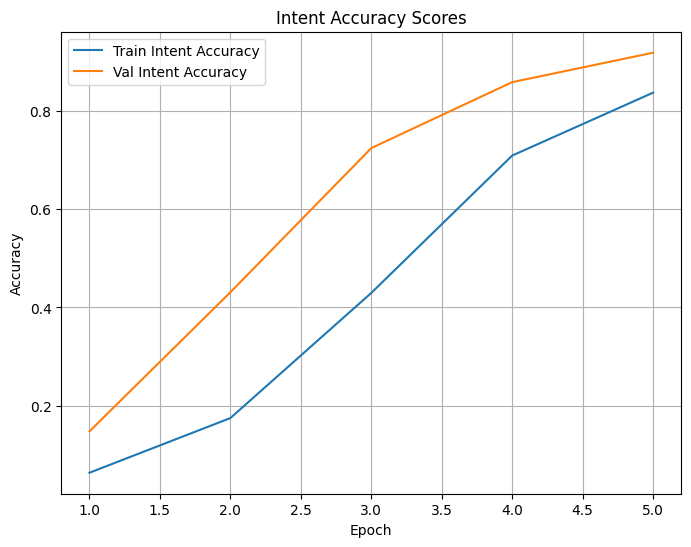

In [ ]:
# Intent Accuracy Plot
epochs = range(1, len(metrics["train_intent_acc"]) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, metrics["train_intent_acc"], label="Train Intent Accuracy")
plt.plot(epochs, metrics["val_intent_acc"], label="Val Intent Accuracy")
plt.title("Intent Accuracy Scores")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(SAVE_PATH, "intent_acc_plot.png"))
plt.show()
plt.close()

## Intent Confusion Matrix

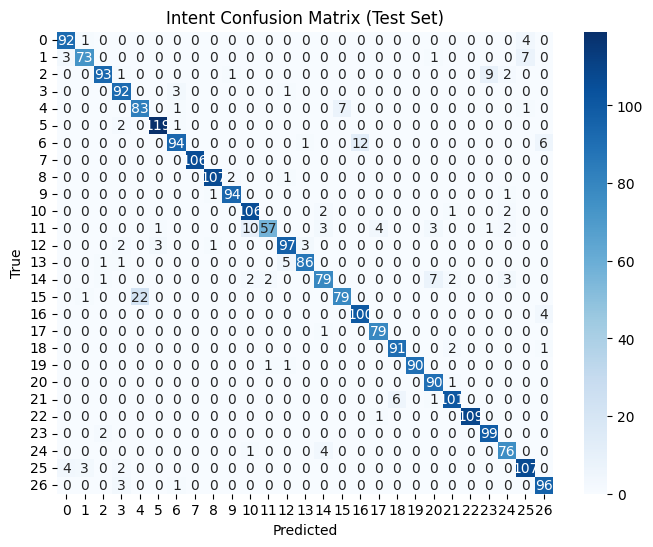

Intent Confusion Matrix saved to /content/drive/MyDrive/gpt2_hybrid_fusion_approach3_droupout_2/intent_cm.png


In [ ]:
# Intent Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_results["intent"]["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title("Intent Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
intent_cm_path = os.path.join(SAVE_PATH, "intent_cm.png")
plt.savefig(intent_cm_path)
plt.show()
plt.close()
print(f"Intent Confusion Matrix saved to {intent_cm_path}")


## Category F1 score weighted

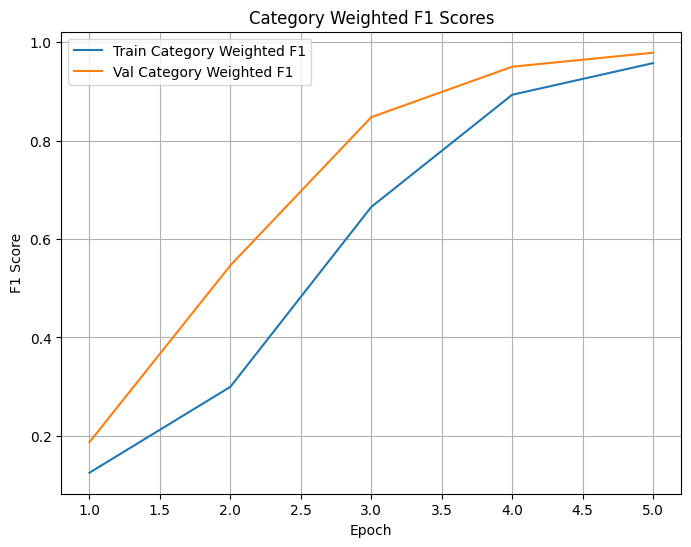

In [ ]:
# Category Weighted F1 Plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, metrics["train_category_f1"], label="Train Category Weighted F1")
plt.plot(epochs, metrics["val_category_f1"], label="Val Category Weighted F1")
plt.title("Category Weighted F1 Scores")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(SAVE_PATH, "category_f1_plot.png"))
plt.show()
plt.close()

## Category Confusion Matrix

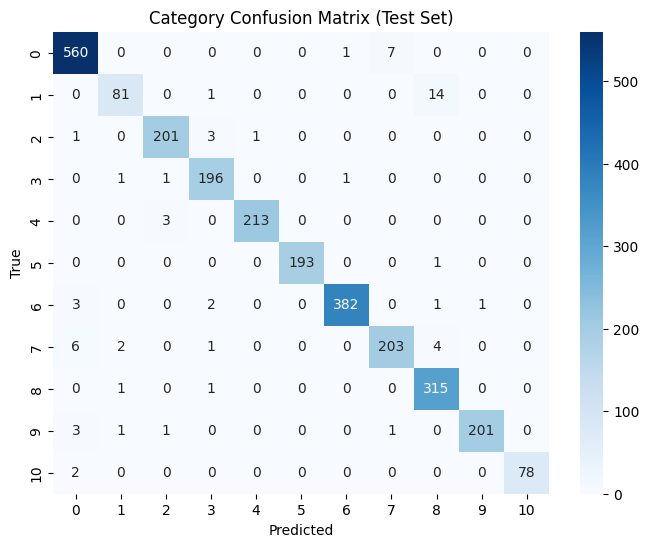

Category Confusion Matrix saved to /content/drive/MyDrive/gpt2_hybrid_fusion_approach3_droupout_2/category_cm.png


In [ ]:
# Category Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_results["category"]["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title("Category Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
category_cm_path = os.path.join(SAVE_PATH, "category_cm.png")
plt.savefig(category_cm_path)
plt.show()
plt.close()
print(f"Category Confusion Matrix saved to {category_cm_path}")

## NER F1 SCORE

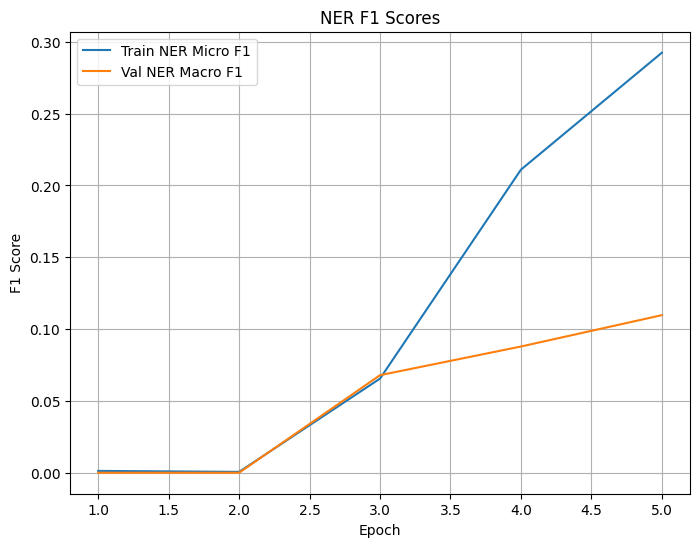

NER plot saved to /content/drive/MyDrive/gpt2_hybrid_fusion_approach3_droupout_2


In [ ]:
# NER F1 Plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, metrics["train_ner_micro_f1"], label="Train NER Micro F1")
plt.plot(epochs, metrics["val_ner_macro_f1"], label="Val NER Macro F1")
plt.title("NER F1 Scores")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(SAVE_PATH, "ner_f1_plot.png"))
plt.show()
plt.close()
print(f"NER plot saved to {SAVE_PATH}")